# <font color='008B8B'> Библиотеки </font> 📖

In [1]:
pip install pyod 

Looking in indexes: http://sehdbin-ip01.portal.cbr.ru:445/repository/pypi-offline/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
from impala.dbapi import connect

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy
import pylab
import math
import random

from decimal import Decimal
from IPython.display import display

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from pandas.api.types import is_numeric_dtype
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import haversine_distances
from sklearn.inspection import permutation_importance


from sklearn.ensemble import IsolationForest       #импортирование алгоритма “изолирующий лес”
from sklearn.svm import OneClassSVM                #импортирование алгоритма “OneClassSVM”
from pyod.models.copod import COPOD                #импортирование алгоритма “COPOD”
from pyod.models.pca import PCA                    #импортирование алгоритма “PCA”
from pyod.models.auto_encoder import AutoEncoder   #импортирование алгоритма “AutoEncoder”
from sklearn.neighbors import LocalOutlierFactor   #импортирование алгоритма “LocalOutlierFactor”


from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from math import sqrt

from catboost import CatBoostRegressor
from catboost import Pool, cv

from scipy.stats import t
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

import shap
import pickle


%matplotlib inline
sns.set()

/opt/conda/python37/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# настройки отображения
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 50

# <font color='008B8B'> Выгрузка из CIAN </font> 🚀🚀🚀

In [4]:
# коннект к базе
conn = connect(host = 'sbdaip01node01.vip.cbr.ru', port = 21052, auth_mechanism = 'GSSAPI', kerberos_service_name = 'impala')
conn.close()

In [5]:
zapros_date = ("SELECT distinct(ptn_dadd) FROM zp_dm_dmi_data.`07_secondary`")
#zapros_city = ("SELECT distinct(geo_city) FROM zp_dm_dmi_data.`07_secondary`")ё

In [6]:
# смотрим, какие даты срезов нам доступны
dates = pd.read_sql(zapros_date, conn)
dates

ptn_dadd
0 2025-01-22
1 2024-12-18
2 2024-10-16
3 2024-11-20

In [7]:
city_names = ('Нижний Новгород')  # выгрузку делаем по региону (тк у нас есть полигоны пригородов), затем лишнее отсечется 
date = ('2024-11-20', '2024-12-18', '2025-01-22')  # три последние даты среза

In [8]:
#zapros_second = (f"SELECT * FROM zp_dm_dmi_data.`07_secondary` where ptn_dadd in {date} and geo_city in {city_names}") # структура запроса с учетом одного региона и нескольких дат
zapros_second = (f"SELECT * FROM zp_dm_dmi_data.`07_secondary` where ptn_dadd in {date} and geo_city = '{city_names}'")

In [9]:
second = pd.read_sql(zapros_second, conn)

In [ ]:
second

In [11]:
#second['geo_city'].value_counts()

In [12]:
# сохраняем в csv, чтобы каждый раз не подключаться к базе  
second.to_csv('!Предобработка_Нижний_Новгород_2025.csv', index = False)

# <font color='008B8B'> 1. Посмотрим структуру df </font> 👀

In [13]:
# выгружаем из csv выборку
df_second = pd.read_csv('!Предобработка_Нижний_Новгород_2025.csv')

In [ ]:
df_second

In [15]:
df_second.info()  # смотрим инфо по df, в том числе пропуски, типы объектов и пр. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 87 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cian_id                   15012 non-null  int64  
 1   photo                     14935 non-null  object 
 2   url                       15012 non-null  object 
 3   bargainterms_price        15012 non-null  float64
 4   price_sqm                 15012 non-null  float64
 5   area_total                15012 non-null  float64
 6   rooms_count               15012 non-null  object 
 7   address                   15012 non-null  object 
 8   floor                     15011 non-null  float64
 9   floors_count              15012 non-null  int64  
 10  year_release              11009 non-null  float64
 11  wall_type                 14845 non-null  object 
 12  created                   15012 non-null  object 
 13  last_edited               15012 non-null  object 
 14  bargai

In [16]:
len(df_second)

15012

### Для удобства исключим столбцы, с которыми точно не будем работать
Описание содержимого - см. Описание_Cian.xslx.

In [17]:
df_second = df_second[['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
                       'floor', 'floors_count', 'year_release', 'wall_type', 'last_edited',
                       'bargainterms_currency', 'repair_type', 'is_apartments', 'nb_is_residence', 
                       'is_penthouse', 'bti_year_built', 'bti_isemergency', 'lat', 'lng', 'geo_region',
                       'geo_settlement', 'geo_city', 'geo_street', 'geo_house_num', 'geo_microdistrict',
                       'geo_city_district', 'subway_name', 'subway_time', 'subway_travel_type',
                       'description'
                      ]]

In [ ]:
df_second

In [19]:
df_second.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cian_id                15012 non-null  int64  
 1   url                    15012 non-null  object 
 2   bargainterms_price     15012 non-null  float64
 3   area_total             15012 non-null  float64
 4   address                15012 non-null  object 
 5   floor                  15011 non-null  float64
 6   floors_count           15012 non-null  int64  
 7   year_release           11009 non-null  float64
 8   wall_type              14845 non-null  object 
 9   last_edited            15012 non-null  object 
 10  bargainterms_currency  15012 non-null  object 
 11  repair_type            14099 non-null  object 
 12  is_apartments          13758 non-null  float64
 13  nb_is_residence        0 non-null      float64
 14  is_penthouse           770 non-null    float64
 15  bt

# <font color='008B8B'> 2. Исключаем дубли по cian_id </font> 🍅=🍅
т.к. мы делаем выгрузку за 3 месяца, необходимо убрать дублирующиеся объекты. Дубли убираем по cian_id, с учетом даты последнего изменения объекта - last_edited.
Таким образом, в выборке должны остаться только объекты с уникальными cian_id и наиболее поздними датами последнего изменения объекта last_edited.

In [20]:
len(df_second.cian_id.unique())  # количество уникальных cian_id

8001

In [21]:
# добавляем столбец - количество дней, прошедшее с даты обновления объявления до сегодняшней даты (05.02.2025)
dates = '2025-02-05'  # сегодня 
dates = pd.to_datetime(dates)

df_second['last_edited'] =  pd.to_datetime(df_second['last_edited'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_second['days_after_edit'] = (dates - df_second['last_edited']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
idx = df_second.groupby('cian_id')['days_after_edit'].idxmin()  # находим индексы объектов с мин количеством дней от обновления до текущей даты
second_nn = df_second.loc[idx]
second_nn.reset_index(drop = True , inplace = True )
second_nn 

In [24]:
len(second_nn)  # длина нового df совпадает с количеством уникальных значений cian_id, значит все ок 

8001

# <font color='008B8B'> 3. Исключение объектов, относящихся к апартам, пентхаусам, деревянным и аварийным домам </font> 🏠
Исключаем из полученного df апартаменты и пентхаусы.\
Исключаем из df объекты в деревянных домах .\
Исключаем из df объекты в аварийных.\
*Важно*: при любом изменении количества строк, удалении объектов в df необходимо сбрасывать индексы 

In [25]:
second_nn['is_apartments'].value_counts()

0.0    7159
1.0      74
Name: is_apartments, dtype: int64

In [26]:
second_nn['is_penthouse'].value_counts()

0.0    420
1.0      3
Name: is_penthouse, dtype: int64

In [27]:
second_nn['wall_type'].value_counts()

Кирпичный              3554
Панельный              2529
Монолитный              676
Блочный                 671
Монолитно-кирпичный     351
Иные типы стен           66
Деревянный               50
Name: wall_type, dtype: int64

In [28]:
second_nn['bti_isemergency'].value_counts()

0.0    1494
1.0       6
Name: bti_isemergency, dtype: int64

In [29]:
second_nn['nb_is_residence'].value_counts()

Series([], Name: nb_is_residence, dtype: int64)

In [ ]:
# убираем из выборки апартаменты, пентхаусы, деревянные и аварийные дома, затем сбрасываем индекс
second_nn = second_nn[second_nn['is_apartments'] != 1]
second_nn = second_nn[second_nn['is_penthouse'] != 1]
second_nn = second_nn[second_nn['bti_isemergency'] != 1]
second_nn = second_nn[second_nn['wall_type'] != 'Деревянный']
second_nn = second_nn.dropna(subset = ['geo_house_num'])
#second_nn = second_nn[second_nn['nb_is_residence'] != 'Апартаменты']

second_nn.reset_index(drop = True , inplace = True )
second_nn 

### Столбцы 'is_apartments', 'is_penthouse', 'bti_isemergency', 'nb_is_residence' нам больше не понадобятся, удаляем их

In [31]:
second_nn = second_nn.drop(columns=['is_apartments', 'is_penthouse', 'bti_isemergency', 'nb_is_residence'])

In [ ]:
second_nn.head(2)

# <font color='008B8B'> 4. Работа с полигонами </font> 📏
Необходимо прогнать нашу выборку через полигоны:
- районы Нижнего Новгорода
- микрорайоны Нижнего Новгорода

### 4.1 Округа Нижнего Новгорода

In [33]:
polygons_R = {'Автозаводский': [[(56.260345, 43.906099), (56.281433, 43.891699), (56.277136, 43.883202), (56.275202, 43.884575),
                                 (56.266247, 43.860929), (56.263719, 43.847476), (56.259083, 43.845983), (56.256182, 43.842592),
                                 (56.250866, 43.840562), (56.255428, 43.771727), (56.257262, 43.738), (56.242452, 43.741611),
                                 (56.242679, 43.758964), (56.205546, 43.778608), (56.198362, 43.777443), (56.198883, 43.81662),
                                 (56.218185, 43.874843), (56.222019, 43.868861), (56.230517, 43.890835), (56.242419, 43.874395), 
                                 (56.244696, 43.870852), (56.254412, 43.89557), (56.255713, 43.899075)],'lime'],
             'Ленинский': [[(56.303175, 43.954577), (56.30324, 43.948376), (56.308269, 43.948291), (56.309446, 43.948263),
                            (56.309454, 43.94612), (56.3095, 43.944509), (56.307207, 43.943634), (56.307642, 43.939329),
                            (56.307367, 43.939058), (56.306936, 43.936555), (56.300938, 43.939861), (56.296391, 43.936607),
                            (56.295969, 43.932253), (56.296959, 43.928802), (56.298832, 43.925706), (56.303349, 43.918455),
                            (56.304452, 43.90966), (56.306043, 43.906138), (56.295744, 43.881257), (56.289722, 43.887284),
                            (56.281815, 43.892417), (56.27329, 43.897531), (56.267318, 43.901244), (56.263465, 43.90575), 
                            (56.260079, 43.90839), (56.248533, 43.920097), (56.254467, 43.937524), (56.260977, 43.948182),
                            (56.273282, 43.955623), (56.28133, 43.956283), (56.28688, 43.957344), (56.299149, 43.955518)], 'salmon'],
             'Московский': [[(56.320115, 43.930763), (56.336018, 43.926631), (56.338811, 43.921724), (56.349749, 43.920754),
                             (56.351661, 43.904027), (56.343305, 43.899282), (56.344732, 43.890766), (56.343653, 43.888974),
                             (56.339439, 43.888309), (56.336494, 43.886026), (56.344099, 43.874203), (56.333887, 43.86894),
                             (56.333899, 43.865599), (56.331856, 43.86137), (56.339202, 43.844992), (56.338207, 43.841296),
                             (56.343053, 43.836985), (56.342908, 43.836637), (56.338628, 43.835619), (56.337563, 43.831455),
                             (56.328848, 43.836214), (56.317379, 43.654819), (56.35384, 43.67686), (56.359213, 43.549844),
                             (56.330764, 43.549093), (56.327469, 43.631529), (56.305737, 43.632384), (56.307072, 43.675504),
                             (56.309056, 43.734479), (56.309518, 43.760966), (56.312852, 43.849857), (56.311228, 43.850025),
                             (56.311827, 43.866655), (56.31351, 43.86626), (56.313638, 43.869075), (56.315045, 43.904258),
                             (56.318147, 43.920779)], 'coral'],
             'Сормовский': [[(56.397136, 43.740355), (56.378979, 43.731654), (56.372083, 43.755191), (56.362845, 43.78631),
                             (56.360961, 43.792384), (56.355236, 43.789051), (56.350475, 43.785278), (56.337042, 43.795219),
                             (56.335099, 43.79932), (56.334904, 43.817385), (56.338917, 43.823286), (56.33983, 43.833867),
                             (56.343237, 43.835681), (56.343496, 43.836579), (56.338277, 43.841173), (56.339428, 43.845069),
                             (56.332092, 43.861221), (56.33386, 43.865594), (56.333889, 43.868999), (56.338158, 43.87037),
                             (56.344283, 43.874295), (56.337192, 43.886105), (56.337672, 43.886979), (56.339493, 43.887936),
                             (56.344506, 43.889161), (56.345081, 43.891023), (56.343415, 43.899182), (56.350227, 43.903474),
                             (56.351508, 43.903158), (56.354791, 43.90389), (56.358999, 43.886465), (56.375226, 43.859643),
                             (56.372908, 43.853451), (56.398797, 43.82011), (56.393778, 43.790859)], 'magenta'],
             'Канавинский': [[(56.308423, 43.739552), (56.305751, 43.740024), (56.304797, 43.742556), (56.302864, 43.743328),
                              (56.304151, 43.74682), (56.305341, 43.752601), (56.307105, 43.756805), (56.307082, 43.760536),
                              (56.273763, 43.83299), (56.296328, 43.879731), (56.306216, 43.905509), (56.304312, 43.910268),
                              (56.30326, 43.918799), (56.297537, 43.927898), (56.296157, 43.932233), (56.296452, 43.936406),
                              (56.300789, 43.939569), (56.306613, 43.936631), (56.307728, 43.938827), (56.307228, 43.94375),
                              (56.310349, 43.945528), (56.30938, 43.948258), (56.30358, 43.94921), (56.303453, 43.952291),
                              (56.304375, 43.952193), (56.304264, 43.954327), (56.315802, 43.956106), (56.32045, 43.956769),
                              (56.324695, 43.960685), (56.330201, 43.968655), (56.334987, 43.978603), (56.352083, 43.923135),
                              (56.34917, 43.921508), (56.341685, 43.921532), (56.339144, 43.922896), (56.336116, 43.92617),
                              (56.319995, 43.930912), (56.315035, 43.902935), (56.313511, 43.866419), (56.31184, 43.866645),
                              (56.311219, 43.849966), (56.312886, 43.849789), (56.309301, 43.760007)], 'blue'],
             'Приокский': [[(56.219092, 43.936363), (56.220794, 43.938113), (56.221495, 43.934776), (56.230244, 43.928583),
                            (56.254728, 43.962642), (56.287489, 43.974498), (56.287135, 43.980865), (56.282137, 43.980645),
                            (56.280872, 43.995556), (56.274047, 43.994098), (56.270761, 43.997684), (56.261992, 44.006451),
                            (56.270686, 44.020247), (56.270557, 44.023971), (56.264895, 44.023281), (56.262161, 44.027809),
                            (56.254633, 44.007514), (56.249671, 44.006063), (56.243147, 44.028567), (56.239466, 44.02655),
                            (56.238162, 44.035972), (56.237307, 44.036826), (56.230869, 44.042011), (56.229649, 44.038593),
                            (56.23008, 44.035062), (56.22955, 44.029517), (56.228059, 44.024615), (56.229419, 44.017469),
                            (56.227512, 43.994704), (56.225254, 43.984986), (56.222335, 43.978305), (56.220153, 43.978168),
                            (56.21532, 43.978484), (56.21137, 43.972729), (56.214977, 43.962528), (56.216686, 43.945731)], 'violet'],
             'Советский': [[(56.303587, 43.975335), (56.304527, 43.970916), (56.286155, 43.9701), (56.287539, 43.97359),
                            (56.287396, 43.981057), (56.282338, 43.980599), (56.280939, 43.995582), (56.273748, 43.994301),
                            (56.27053, 43.998489), (56.270795, 44.0069), (56.27522, 44.017533), (56.275669, 44.020178),
                            (56.271029, 44.021964), (56.268847, 44.018563), (56.268387, 44.023606), (56.264373, 44.023613),
                            (56.257167, 44.038376), (56.253197, 44.031396), (56.245387, 44.05885), (56.243793, 44.078008),
                            (56.260813, 44.085434), (56.268608, 44.072918), (56.274764, 44.058887), (56.276732, 44.053856),
                            (56.280767, 44.052138), (56.286087, 44.056661), (56.294565, 44.056171), (56.2982, 44.054564),
                            (56.299519, 44.054081), (56.301285, 44.055291), (56.303643, 44.05124), (56.304187, 44.047789),
                            (56.306801, 44.046403), (56.308983, 44.044119), (56.31397, 44.042249), (56.320177, 44.04144),
                            (56.321995, 44.042325), (56.323567, 44.035518), (56.32179, 44.033226), (56.319661, 44.02904),
                            (56.318765, 44.025282), (56.31494, 44.012594), (56.31037, 43.999229), (56.308059, 43.987744),
                            (56.308232, 43.984809), (56.306779, 43.98434)], 'silver'],
             'Нижегородский': [[(56.307466, 43.96591), (56.304577, 43.978259), (56.30691, 43.984677), (56.30831, 43.985021),
                                (56.307998, 43.987667), (56.310165, 43.998343), (56.314874, 44.012128), (56.317894, 44.022044),
                                (56.319309, 44.027865), (56.320319, 44.031074), (56.323409, 44.035275), (56.32195, 44.042313),
                                (56.319624, 44.041775), (56.314016, 44.042272), (56.307353, 44.045524), (56.304075, 44.048186),
                                (56.301955, 44.055559), (56.298882, 44.05442), (56.287094, 44.057142), (56.281879, 44.05336),
                                (56.276967, 44.053761), (56.275708, 44.0577), (56.27099, 44.069411), (56.266205, 44.077395),
                                (56.267137, 44.083425), (56.269094, 44.082563), (56.270082, 44.086976), (56.271718, 44.086703),
                                (56.27459, 44.083858), (56.280939, 44.079404), (56.281902, 44.07987), (56.283015, 44.085478),
                                (56.279134, 44.096153), (56.285722, 44.097026), (56.292505, 44.093669), (56.293481, 44.102932),
                                (56.293985, 44.110151), (56.309992, 44.092224), (56.319987, 44.073657), (56.32954, 44.038651),
                                (56.334898, 43.994503), (56.326273, 43.976564), (56.317743, 43.968158)], 'lavender']
             }

#polygons_R # словарь с полигонами нет необходимости выводить и перегружать проект

In [34]:
def point_inside_polygon(x, y, poly, include_edges = True):
    '''
    Проверьте, находится ли точка (x,y) внутри многоугольника poly.

    poly - это многоугольник с N вершинами, определенный как 
    [(x1,y1),...,(xN,yN)] или [(x1,y1),...,(xN,yN),(x1,y1)]
    (функция отлично работает в обоих случаях)

    Геометрическая идея: точка находится внутри многоугольника, если горизонтальный луч
    справа от точки пересекает многоугольник четное число раз. 
    Отлично работает для невыпуклых многоугольников.
    '''
    n = len(poly)
    inside = False

    p1x, p1y = poly[0]
    for i in range(1, n + 1):
        p2x, p2y = poly[i % n]
        if p1y == p2y:
            if y == p1y:
                if min(p1x, p2x) <= x <= max(p1x, p2x):
                    #point is on horisontal edge
                    inside = include_edges
                    break
                elif x < min(p1x, p2x):  # point is to the left from current edge
                    inside = not inside
        else:   #p1y!= p2y
            if min(p1y, p2y) <= y <= max(p1y, p2y):
                xinters = (y - p1y) * (p2x - p1x) / float(p2y - p1y) + p1x

                if x == xinters:  # point is right on the edge
                    inside = include_edges
                    break

                if x < xinters:  # point is to the left from current edge
                    inside = not inside

        p1x, p1y = p2x, p2y

    return inside

In [35]:
polygons_R_ = []

for pol_name in list(polygons_R.keys()):
    polygons_R_.append(polygons_R[pol_name][0])

#polygons_R_

In [36]:
k = len(second_nn['lat']) #широта

districts_district = []

for i in tqdm(range(0, k, 1), 'Обработано'):
    for j, c, p in zip(range(1, len(polygons_R.keys()) + 1, 1), polygons_R.keys(), polygons_R_): #enumerate(polygons.items())
        poly = p
        x = second_nn['lat'][i] #широта
        y = second_nn['lng'][i] #долгота
        res = point_inside_polygon(x, y, poly, include_edges = True)  # функция из 4.1

        if res == True:
            district = c
            districts_district.append(district)
            break
        
        if (j == len(polygons_R.keys()) and res == False):
            district = 999
            districts_district.append(district)

Обработано: 100%|██████████| 7844/7844 [00:01<00:00, 4245.01it/s]


In [37]:
second_nn['poly_okrug'] = pd.DataFrame(districts_district, columns = ['poly_okrug']) 

#### Проверяем созданный столбец

In [38]:
second_nn[second_nn['poly_okrug'].isnull()] # фильтр по нулям, пропусков нет

Empty DataFrame
Columns: [cian_id, url, bargainterms_price, area_total, address, floor, floors_count, year_release, wall_type, last_edited, bargainterms_currency, repair_type, bti_year_built, lat, lng, geo_region, geo_settlement, geo_city, geo_street, geo_house_num, geo_microdistrict, geo_city_district, subway_name, subway_time, subway_travel_type, description, days_after_edit, poly_okrug]
Index: []

In [39]:
second_nn['poly_okrug'].value_counts() # смотрим распределение

Автозаводский    1485
Советский        1322
Нижегородский    1190
Канавинский      1038
Сормовский        828
Московский        705
Ленинский         688
Приокский         575
999                13
Name: poly_okrug, dtype: int64

In [ ]:
second_nn[second_nn['poly_okrug'] == 999]

In [41]:
second_nn[second_nn['poly_okrug'] == 999]['geo_street'].value_counts()

улица Богородского    5
улица Пушкина         4
Норвежская улица      2
Зеленый Город кп      1
улица Гончарова       1
Name: geo_street, dtype: int64

In [42]:
second_nn = second_nn[second_nn['poly_okrug'] != 999]
second_nn.reset_index(drop = True , inplace = True )

### 4.2 Районы Нижнего Новгорода

In [43]:
polygons_M = {'Старый_Нижний_Новгород': [[(56.31783, 43.968446), (56.326575, 43.976249), (56.334483, 43.998633), (56.330627, 44.023512), (56.32468, 44.03547),
               (56.322684, 44.034094), (56.319591, 44.028545), (56.318302, 44.023131), (56.315179, 44.012596), (56.310602, 43.999369), (56.308187, 43.987834),
               (56.308426, 43.984512), (56.306886, 43.984015), (56.304707, 43.97824), (56.307847, 43.967116)], 'red'],
 'Высоково': [[(56.30616, 44.025428), (56.308039, 44.035507), (56.313994, 44.041938), (56.319625, 44.041626), (56.320143, 44.041131), (56.322744, 44.042777),
               (56.323463, 44.035489), (56.321659, 44.034035), (56.319376, 44.028726), (56.316952, 44.019454), (56.314897, 44.012766), (56.310416, 43.999803),
               (56.308282, 44.001383)], 'gold'],
 'Усиловский': [[(56.322976, 44.04298), (56.321605, 44.049214), (56.321421, 44.052682), (56.320562, 44.057002), (56.319497, 44.063269),
                (56.318097, 44.067614), (56.31526, 44.06388), (56.313795, 44.055769), (56.31054, 44.054021), (56.308198, 44.049422),
                (56.309761, 44.044275), (56.313893, 44.041625), (56.315561, 44.043783), (56.320223, 44.041382)], 'violet'],
 'Печёрская_Долина': [[(56.315529, 44.069451), (56.317257, 44.066542), (56.31787, 44.067683), (56.311639, 44.087088), (56.299015, 44.095593),
                   (56.294233, 44.093538), (56.298752, 44.07991), (56.299839, 44.066041), (56.313205, 44.064779)], 'brown'],
 'Верхние_Печёры': [[(56.301056, 44.055914), (56.300269, 44.06006), (56.298774, 44.079776), (56.292805, 44.074788), (56.289399, 44.075505),
                   (56.281173, 44.080192), (56.278186, 44.069459), (56.278659, 44.056108), (56.288584, 44.059968), (56.294717, 44.058357),
                   (56.298205, 44.05576)], 'yellow'],
 'Александровская_слобода': [[(56.292903, 44.075147), (56.298734, 44.079818), (56.292809, 44.094149), (56.283773, 44.097799), (56.278713, 44.097344),
                   (56.278397, 44.094803), (56.280878, 44.090531), (56.282405, 44.086751), (56.282483, 44.083055), (56.281907, 44.080003),
                   (56.287364, 44.077028)], 'teal'],
 'Лапшиха': [[(56.305572, 44.023614), (56.307469, 44.036353), (56.308178, 44.045021), (56.302792, 44.048502), (56.303284, 44.045061), (56.300463, 44.031651),
           (56.291561, 44.035695), (56.291319, 44.015283), (56.297303, 44.012681), (56.298508, 44.018293), (56.302021, 44.023406)], 'indigo'],
 'Нагорный': [[(56.302812, 44.045391), (56.302903, 44.044033), (56.300334, 44.032015), (56.290256, 44.036321), (56.290123, 44.052333),
           (56.2927, 44.054736), (56.302263, 44.046719)], 'blue'],
 'Кузнечиха': [[(56.288855, 44.029897), (56.28898, 44.053834), (56.286911, 44.055832), (56.278315, 44.051349), (56.281893, 44.029739)], 'lime'],
 'Север_Советского_района ': [[(56.308262, 44.001132), (56.310431, 43.999259), (56.308052, 43.987943), (56.308297, 43.985188), (56.307032, 43.984797),
               (56.303795, 43.97608), (56.304236, 43.972149), (56.300054, 43.9704), (56.29846, 43.99132), (56.298047, 43.99205), (56.298711, 44.002286),
               (56.299962, 44.011314), (56.302216, 44.010298)], 'pink'],
 'Юг_Советского_района ': [[(56.299011, 43.984046), (56.29846, 43.99132), (56.298047, 43.99205), (56.298711, 44.002286), (56.299962, 44.011314),
               (56.291224, 44.015075), (56.289801, 44.004606), (56.291678, 44.003797), (56.290579, 43.995553), (56.281168, 43.99289),
               (56.282243, 43.980635), (56.289882, 43.981399)], 'olive'],
 'Каштановый_дворик': [[(56.267179, 44.031918), (56.273312, 44.026912), (56.276879, 44.032839), (56.277921, 44.042754), (56.276683, 44.052713),
               (56.274011, 44.057384), (56.270005, 44.046635)], 'navy'],
 'Суриковский': [[(56.282055, 43.980578), (56.280778, 43.995535), (56.273675, 43.993978), (56.275395, 43.977733)], 'coral'],
 'Караваиха': [[(56.275242, 43.977594), (56.274911, 43.980983), (56.274415, 43.980887), (56.270333, 43.986232), (56.26694, 43.98661),
               (56.263638, 43.978687), (56.261114, 43.977732), (56.261655, 43.973652)], 'orange'],
 'Новая_Стройка': [[(56.261889, 43.980069), (56.263872, 43.984436), (56.263646, 43.98824), (56.260789, 43.992173), (56.260183, 43.989486),
               (56.260933, 43.979671)], 'green'],
 'Дубёнки': [[(56.261647, 43.973669), (56.261147, 43.976176), (56.260126, 43.989583), (56.262192, 43.998371), (56.264458, 43.996435), (56.264921, 43.998304),
               (56.263044, 43.999984), (56.263634, 44.00304), (56.261631, 44.006029), (56.261874, 44.007232), (56.258233, 44.010889), (56.256181, 44.003997),
               (56.248261, 44.000995), (56.252196, 43.976314), (56.255109, 43.970172)], 'khaki'],
 'Стройгаз': [[(56.248198, 43.966776), (56.24952, 43.963298), (56.252204, 43.964654), (56.24856, 43.986975), (56.249762, 43.987865), (56.247965, 43.994741),
               (56.247115, 44.001014), (56.246755, 44.006987), (56.244563, 44.013547), (56.242807, 44.011171), (56.244177, 43.993903), (56.243755, 43.991058),
               (56.244943, 43.985644), (56.243466, 43.984815), (56.246315, 43.965898)], 'plum'],
 'Щербинки': [[(56.228153, 43.936343), (56.230006, 43.936943), (56.229741, 43.940132), (56.234005, 43.943313), (56.235452, 43.940998), (56.236386, 43.942746),
           (56.235228, 43.945132), (56.23994, 43.954395), (56.244036, 43.964928), (56.240947, 43.985385), (56.238915, 43.984587), (56.237602, 43.990918),
           (56.235652, 43.994111), (56.23394, 44.005416), (56.234416, 44.005689), (56.234083, 44.007738), (56.23337, 44.007396), (56.231395, 43.993812),
           (56.233967, 43.978178), (56.227955, 43.949269), (56.222787, 43.955046), (56.221414, 43.951465)], 'cyan'],
 'Цветы': [[(56.25836, 44.010899), (56.261897, 44.00732), (56.269084, 44.01901), (56.267738, 44.023651), (56.264029, 44.023478),
           (56.262338, 44.021927)], 'salmon'],
 'Мещерское_Озеро': [[(56.351521, 43.924975), (56.347386, 43.942299), (56.340199, 43.962788), (56.329232, 43.94809), (56.332095, 43.933101),
           (56.338842, 43.921843), (56.348072, 43.921912)], 'gray'],
 'Ярмарка': [[(56.329167, 43.948919), (56.335571, 43.957468), (56.331281, 43.968075), (56.32444, 43.958963), (56.323995, 43.957109), (56.323751, 43.952521),
           (56.325513, 43.951068), (56.326471, 43.953413), (56.327339, 43.951622)], 'silver'],
 'Гордеевский': [[(56.320027, 43.930857), (56.333225, 43.927384), (56.332671, 43.92889), (56.329415, 43.933479), (56.328381, 43.936757),
           (56.329301, 43.938127), (56.324915, 43.949362), (56.324104, 43.947144), (56.323078, 43.946436)], 'purple'],
 'Старое_Канавино': [[(56.323421, 43.949197), (56.32407, 43.959132), (56.315935, 43.955321), (56.316172, 43.953418), (56.315141, 43.953047),
            (56.315166, 43.952597), (56.313967, 43.95291), (56.308613, 43.950928), (56.30879, 43.948339), (56.31077, 43.94745),
            (56.314582, 43.946794), (56.315359, 43.944016), (56.319024, 43.945381), (56.319096, 43.945136), (56.320009, 43.945431),
            (56.320112, 43.944243), (56.320977, 43.94318)], 'lavender'],
 'Ленгородок': [[(56.316795, 43.938401), (56.317536, 43.937758), (56.32009, 43.944366), (56.31995, 43.945328), (56.318314, 43.944244),
           (56.318175, 43.944845), (56.31522, 43.943889), (56.315115, 43.945131), (56.313139, 43.944547), (56.312742, 43.945051), (56.307287, 43.943343),
           (56.307826, 43.938975), (56.307499, 43.938951), (56.306938, 43.93617), (56.301196, 43.939368), (56.296599, 43.936397), (56.296123, 43.932106),
           (56.296886, 43.929015), (56.302376, 43.920356), (56.305991, 43.928586), (56.307563, 43.926407), (56.309397, 43.926713), (56.311726, 43.930262),
           (56.312434, 43.930758), (56.313356, 43.929561), (56.315969, 43.936226), (56.315163, 43.93712), (56.31615, 43.938641),
           (56.316342, 43.938292)], 'magenta'],
 'посёлок_Володарского': [[(56.306213, 43.905791), (56.314463, 43.928061), (56.312547, 43.930535), (56.311837, 43.930036), (56.309608, 43.926441),
           (56.30732, 43.926401), (56.305988, 43.928455), (56.302404, 43.920304), (56.303445, 43.918197), (56.304567, 43.908917)], 'red'],
 '15_й_квартал': [[(56.314114, 43.880602), (56.315048, 43.904715), (56.316929, 43.914849), (56.315232, 43.916048), (56.312698, 43.915194), (56.313463, 43.9131),
           (56.314665, 43.91257), (56.313101, 43.903334), (56.310236, 43.899974), (56.307871, 43.894454), (56.307657, 43.885911),
           (56.308757, 43.880331)], 'gold'],
 'посёлок_Берёзовский': [[(56.303922, 43.872662), (56.305451, 43.879416), (56.305361, 43.885648), (56.300758, 43.885879), (56.297248, 43.878348),
           (56.300764, 43.87454)], 'violet'],
 'посёлок_Юдинцева': [[(56.313507, 43.868938), (56.313753, 43.874654), (56.310445, 43.8752), (56.310314, 43.869676)], 'brown'],
 'Вторчермет': [[(56.313769, 43.849931), (56.315187, 43.864934), (56.313435, 43.866428), (56.311936, 43.866632), (56.311304, 43.850091)], 'yellow'],
 'Лесной_Городок': [[(56.31003, 43.837364), (56.310418, 43.851401), (56.303582, 43.852251), (56.302097, 43.843095), (56.305057, 43.841183),
           (56.304941, 43.838958)], 'teal'],
 'Сортировочный': [[(56.302037, 43.843165), (56.30308, 43.849898), (56.303584, 43.852214), (56.294084, 43.860164), (56.294375, 43.861155),
           (56.293116, 43.862804), (56.296803, 43.872185), (56.294715, 43.875157), (56.283957, 43.846893), (56.292491, 43.837403),
           (56.295902, 43.847131)], 'indigo'],
 'Агрокомбинат_Горьковский': [[(56.31094, 43.800705), (56.31165, 43.819868), (56.307186, 43.821541), (56.305085, 43.818575), (56.305405, 43.817413),
           (56.309227, 43.817242), (56.308796, 43.801044)], 'blue'],
 'Комсомольский_район': [[(56.307004, 43.936391), (56.307476, 43.938979), (56.307722, 43.939152), (56.307212, 43.943969), (56.309641, 43.944734),
           (56.309321, 43.948065), (56.308173, 43.948473), (56.303206, 43.948224), (56.303201, 43.954302), (56.298877, 43.954723),
           (56.298905, 43.950135), (56.29761, 43.944196), (56.297059, 43.9411), (56.296514, 43.936484), (56.301151, 43.939592)], 'lime'],
 'Молитовка': [[(56.297626, 43.944245), (56.298804, 43.950011), (56.295222, 43.952066), (56.285825, 43.95326), (56.282963, 43.950242),
           (56.285299, 43.940111), (56.289372, 43.940913), (56.29428, 43.943532), (56.294397, 43.943178), (56.295481, 43.943676),
           (56.296366, 43.943219)], 'pink'],
 'Комсомольская_площадь': [[(56.29617, 43.93382), (56.296461, 43.936368), (56.297489, 43.943301), (56.294289, 43.942934), (56.290811, 43.941652),
           (56.289358, 43.940748), (56.285276, 43.940104), (56.288106, 43.928048)], 'olive'],
 'Молитовский_Затон': [[(56.282153, 43.948759), (56.280914, 43.957354), (56.273428, 43.95627), (56.273884, 43.951095), (56.274444, 43.94755),
           (56.278143, 43.950495), (56.279096, 43.946274)], 'navy'],
 'Станкозавод': [[(56.287568, 43.930211), (56.283206, 43.949079), (56.27905, 43.945715), (56.278018, 43.950318), (56.274634, 43.947839),
           (56.274905, 43.946048), (56.272214, 43.939143), (56.276044, 43.935386), (56.274902, 43.930947), (56.274844, 43.928671),
           (56.276483, 43.921844)], 'coral'],
 'Двигатель_Революции': [[(56.276508, 43.921508), (56.274806, 43.928605), (56.274873, 43.931072), (56.275939, 43.935451), (56.273335, 43.937575),
           (56.271442, 43.936589), (56.269794, 43.934005), (56.268605, 43.935466), (56.264936, 43.931568), (56.271758, 43.917958)], 'orange'],
 'Карповка': [[(56.262696, 43.929752), (56.260307, 43.934888), (56.264992, 43.941744), (56.26264, 43.947779), (56.255108, 43.936875),
           (56.256009, 43.928252), (56.253181, 43.922061), (56.256684, 43.917283), (56.259193, 43.921839)], 'green'],
 'Стройплощадка': [[(56.264796, 43.905935), (56.268133, 43.914434), (56.265722, 43.918945), (56.262472, 43.91073), (56.263706, 43.907233)], 'khaki'],
 'посёлок_Дачный': [[(56.30419, 43.906588), (56.302418, 43.918058), (56.301049, 43.917531), (56.300306, 43.916612), (56.299011, 43.913165),
           (56.299612, 43.899261), (56.300193, 43.899498)], 'plum'],
 'Красная_Этна': [[(56.290263, 43.886667), (56.295276, 43.894183), (56.292631, 43.901746), (56.295325, 43.923718), (56.288385, 43.925921),
           (56.285178, 43.923102), (56.286427, 43.917538), (56.278568, 43.911562), (56.275645, 43.904816), (56.280267, 43.898748),
           (56.278839, 43.893993)], 'cyan'],
 'Ипподромный': [[(56.286341, 43.917713), (56.284255, 43.927032), (56.268796, 43.915611), (56.268504, 43.914465), (56.275668, 43.904875),
           (56.278169, 43.911164)], 'salmon'],
 'Северный': [[(56.265946, 43.860134), (56.275623, 43.885552), (56.273828, 43.889296), (56.273043, 43.888233), (56.271892, 43.889588),
           (56.272239, 43.89343), (56.270747, 43.896333), (56.270418, 43.895486), (56.263943, 43.903853), (56.261719, 43.897835),
           (56.260722, 43.899148), (56.252423, 43.87619)], 'gray'],
 'Соцгород': [[(56.25895, 43.845526), (56.263936, 43.846707), (56.266147, 43.857676), (56.257514, 43.868525), (56.255281, 43.867299), (56.255068, 43.869704),
           (56.254365, 43.870656), (56.243536, 43.867544), (56.2417, 43.862948), (56.243936, 43.839032), (56.257381, 43.842803)], 'silver'],
 'Мончегорский': [[(56.237031, 43.825109), (56.235991, 43.83707), (56.232099, 43.838333), (56.226906, 43.844645), (56.223805, 43.83658),
            (56.222945, 43.833211), (56.222051, 43.830228), (56.227128, 43.824475), (56.226065, 43.821356), (56.226399, 43.818432),
            (56.234434, 43.820702), (56.234543, 43.824629)], 'purple'],
 'посёлок_Колхозный ': [[(56.248389, 43.824459), (56.246983, 43.839543), (56.243655, 43.838511), (56.242587, 43.84891), (56.231998, 43.84646), (56.230133, 43.842088),
           (56.232265, 43.838675), (56.236206, 43.836987), (56.237646, 43.821419)], 'lavender'],
 'Народная_Стройка': [[(56.228985, 43.842795), (56.232075, 43.847403), (56.233689, 43.847618), (56.235092, 43.851653), (56.226653, 43.862455),
           (56.222332, 43.851593)], 'magenta'],
 'Юго_Западный': [[(56.222182, 43.85147), (56.224135, 43.856478), (56.219795, 43.862056), (56.217764, 43.856659)], 'red'],
 'Юг': [[(56.217157, 43.856746), (56.221129, 43.867241), (56.217695, 43.871888), (56.214008, 43.860881)], 'gold'],
 '6_й_микрорайон': [[(56.224155, 43.856466), (56.233783, 43.881157), (56.229556, 43.887289), (56.219794, 43.862052)], 'violet'],
 'завод_ГАЗ': [[(56.235141, 43.851829), (56.240275, 43.864446), (56.241555, 43.862882), (56.244891, 43.871356), (56.235502, 43.885447),
           (56.226579, 43.862756)], 'brown'],
 'посёлок_Стахановский': [[(56.219297, 43.815734), (56.226268, 43.818521), (56.225939, 43.821748), (56.226407, 43.823917), (56.221699, 43.830563),
           (56.222692, 43.833439), (56.224317, 43.83604), (56.218774, 43.842838), (56.213541, 43.825834), (56.212015, 43.823068)], 'yellow'],
 'Мостоотряд': [[(56.217586, 43.799946), (56.219865, 43.805102), (56.206195, 43.805686), (56.212341, 43.832979), (56.209473, 43.83711),
           (56.199605, 43.811641), (56.199295, 43.80526)], 'teal'],
 'Cовхоз_Доскино': [[(56.250598, 43.743109), (56.25165, 43.753999), (56.243918, 43.752399), (56.243032, 43.745087)], 'indigo'],
 'посёлок_Левинка': [[(56.347891, 43.902309), (56.351502, 43.904319), (56.350881, 43.912866), (56.346241, 43.910623)], 'blue'],
 'Бурнаковский_север': [[(56.339223, 43.918004), (56.340288, 43.9127), (56.342076, 43.904615), (56.345529, 43.906602), (56.345729, 43.916237),
           (56.341372, 43.91938)], 'lime'],
 'Бурнаковский_юг': [[(56.339223, 43.918004), (56.340288, 43.9127), (56.330802, 43.900633), (56.325032, 43.913776),
           (56.338397, 43.921409)], 'pink'],
 'Бурнаковский_Гордеевский': [[(56.325044, 43.913789), (56.338826, 43.921636), (56.33596, 43.925946), (56.332906, 43.92746), (56.32003, 43.930917),
           (56.317193, 43.916276)], 'olive'],
 'Спортивный': [[(56.330897, 43.865592), (56.333938, 43.86542), (56.333822, 43.869076), (56.343823, 43.873889), (56.337588, 43.883765), (56.33667, 43.881795),
           (56.333159, 43.880388), (56.334088, 43.873301), (56.333504, 43.872797), (56.33068, 43.873618), (56.330523, 43.868478)], 'navy'],
 'Калининский': [[(56.333855, 43.873847), (56.332951, 43.880455), (56.336612, 43.88212), (56.337531, 43.884219), (56.335929, 43.887324),
           (56.324012, 43.88219), (56.326675, 43.87668), (56.326213, 43.867797), (56.327893, 43.868237), (56.330349, 43.867785),
           (56.33058, 43.874057), (56.333342, 43.873361)], 'coral'],
 'Берёзовский': [[(56.326059, 43.871605), (56.326484, 43.875681), (56.32356, 43.881135), (56.323574, 43.885816), (56.31627, 43.909966), (56.315338, 43.904593),
           (56.314233, 43.881467), (56.317572, 43.881173), (56.321178, 43.878933)], 'orange'],
 'Красные_Зори': [[(56.320723, 43.863871), (56.325889, 43.867293), (56.326134, 43.870048), (56.324861, 43.870565), (56.320336, 43.876818),
           (56.317939, 43.879645), (56.314336, 43.880671), (56.313914, 43.868904)], 'green'],
 'Авиационный_квартал': [[(56.331406, 43.834641), (56.331561, 43.840355), (56.328506, 43.854903), (56.326996, 43.853611), (56.326124, 43.850779),
           (56.32863, 43.842073), (56.327026, 43.839373), (56.32702, 43.837035)], 'khaki'],
 'посёлок_Орджоникидзе': [[(56.339414, 43.832146), (56.342957, 43.834429), (56.343526, 43.836503), (56.338143, 43.841216), (56.339146, 43.84504),
           (56.331957, 43.861188), (56.327843, 43.858103), (56.331546, 43.840438), (56.331427, 43.834672), (56.33705, 43.831597)], 'plum'],
 'Берёзовая_Пойма': [[(56.344555, 43.607475), (56.344193, 43.62837), (56.331211, 43.627522), (56.331338, 43.606692)], 'cyan'],
 'Дарьино': [[(56.345438, 43.863945), (56.347776, 43.869447), (56.344654, 43.87322), (56.338308, 43.869188), (56.33863, 43.866707)], 'salmon'],
 'Сормова': [[(56.356368, 43.857633), (56.355544, 43.8673), (56.349723, 43.878527), (56.344432, 43.873735), (56.348046, 43.86924), (56.344193, 43.860487),
           (56.345476, 43.85337), (56.348629, 43.852873), (56.34884, 43.857556), (56.350511, 43.857309), (56.350809, 43.860329), (56.35176, 43.860252),
           (56.352997, 43.858952)], 'gray'],
 'Вождей_Революции': [[(56.350568, 43.837816), (56.353643, 43.844337), (56.356006, 43.857404), (56.350858, 43.860037), (56.350743, 43.857282), (56.348915, 43.857555),
           (56.348413, 43.848054), (56.346371, 43.84412)], 'silver'],
 '10_й_микрорайон_Сормова': [[(56.345349, 43.842138), (56.34839, 43.847955), (56.348689, 43.852619), (56.345453, 43.853058), (56.339674, 43.84695)], 'purple'],
 'Кооперативный_посёлок': [[(56.341296, 43.818083), (56.345473, 43.822587), (56.349357, 43.836637), (56.347719, 43.840012), (56.339653, 43.846996),
           (56.338155, 43.841243), (56.343633, 43.8364), (56.343148, 43.834567), (56.339639, 43.832257), (56.338843, 43.823258)], 'lavender'],
 'микрорайон_Новый': [[(56.347449, 43.799681), (56.348391, 43.804498), (56.343046, 43.808254), (56.342366, 43.812946), (56.340543, 43.806195),
           (56.340564, 43.801653)], 'magenta'],
 'Володарский_посёлок': [[(56.358542, 43.838867), (56.365742, 43.854309), (56.364893, 43.859026), (56.361772, 43.862786), (56.359239, 43.870853),
           (56.356171, 43.865783), (56.356458, 43.857665), (56.354382, 43.845914)], 'red'],
 'Светлоярский': [[(56.357558, 43.828151), (56.360553, 43.83639), (56.357143, 43.840248), (56.352288, 43.840421), (56.350326, 43.83525), (56.351991, 43.833389),
           (56.353882, 43.825503)], 'gold'],
 'Комсомольский_посёлок': [[(56.369023, 43.812937), (56.370706, 43.824495), (56.362755, 43.833704), (56.359093, 43.824648), (56.363863, 43.817153),
           (56.364248, 43.81814)], 'violet'],
 '5_7_микрорайоны': [[(56.361426, 43.792438), (56.372971, 43.799939), (56.36933, 43.812571), (56.364657, 43.817544), (56.36411, 43.816412),
           (56.359136, 43.824314), (56.354669, 43.820006)], 'brown'],
 'Народный_посёлок': [[(56.380475, 43.777281), (56.385121, 43.780781), (56.38121, 43.800042), (56.376451, 43.797461)], 'yellow'],
 'посёлок_Дубравный': [[(56.394157, 43.738665), (56.392956, 43.747912), (56.385278, 43.745238), (56.385936, 43.736349)], 'teal']
             }
#polygons_M # словарь с полигонами нет необходимости выводить и перегружать проект

In [44]:
polygons_M_ = []

for pol_name in list(polygons_M.keys()):
    polygons_M_.append(polygons_M[pol_name][0])

In [45]:
k = len(second_nn['lat']) #широта

districts_microdistrict = []

for i in tqdm(range(0, k, 1), 'Обработано'):
    for j, c, p in zip(range(1, len(polygons_M.keys()) + 1, 1), polygons_M.keys(), polygons_M_): #enumerate(polygons.items())
        poly = p
        x = second_nn['lat'][i] #широта
        y = second_nn['lng'][i] #долгота
        res = point_inside_polygon(x, y, poly, include_edges = True)  # функция из 4.1

        if res == True:
            district = c
            districts_microdistrict.append(district)
            break
        
        if (j == len(polygons_M.keys()) and res == False):
            district = 999
            districts_microdistrict.append(district)

Обработано: 100%|██████████| 7831/7831 [00:06<00:00, 1191.82it/s]


In [46]:
second_nn['poly_district'] = pd.DataFrame(districts_microdistrict, columns = ['poly_district']) 

#### Проверяем созданный столбец

In [47]:
second_nn[second_nn['poly_district'].isnull()] # фильтр по нулям, пропусков нет

Empty DataFrame
Columns: [cian_id, url, bargainterms_price, area_total, address, floor, floors_count, year_release, wall_type, last_edited, bargainterms_currency, repair_type, bti_year_built, lat, lng, geo_region, geo_settlement, geo_city, geo_street, geo_house_num, geo_microdistrict, geo_city_district, subway_name, subway_time, subway_travel_type, description, days_after_edit, poly_okrug, poly_district]
Index: []

In [48]:
second_nn['poly_district'].value_counts() # смотрим распределение

Старый_Нижний_Новгород      557
Высоково                    358
Соцгород                    354
Мещерское_Озеро             316
Северный                    278
                           ... 
Агрокомбинат_Горьковский     12
посёлок_Дубравный            11
посёлок_Юдинцева              7
посёлок_Левинка               6
Берёзовая_Пойма               2
Name: poly_district, Length: 79, dtype: int64

#### Проверяем 999

In [ ]:
second_nn[second_nn['poly_district'] == 999]  # выведем объекты с 999

In [50]:
len(second_nn[second_nn['poly_district'] == 999]) # выведем количество объектов - их не много, можем удалить 

30

In [51]:
second_nn[second_nn['poly_district'] == 999]['geo_street'].value_counts()

Вязниковская улица        5
проспект Ленина           3
проспект Ильича           2
улица Вторчермета         2
улица Айвазовского        2
Московское шоссе          2
проспект Гагарина         2
улица Кащенко             1
улица Студгородок ГСХИ    1
Хальзовская улица         1
Архангельская улица       1
улица Танкистов           1
Анкудиновское шоссе       1
Деловая улица             1
улица Стеклова            1
переулок Стригинский      1
улица Новые Полянки       1
Красногорская улица       1
улица Малоэтажная         1
Name: geo_street, dtype: int64

Делаем проверку какие улицы не попали в полигон и почему.

In [52]:
second_nn[(second_nn['poly_district'] == 999) & (second_nn['geo_street'] == 'улица Окская')]['geo_house_num'].value_counts()

Series([], Name: geo_house_num, dtype: int64)

#### Удаляем 999

In [53]:
second_nn = second_nn[second_nn['poly_district'] != 999]
second_nn.reset_index(drop = True , inplace = True )

# <font color='008B8B'> 5. Редактирование полигонов </font> ✍

#### 5.1 Объединяем районы Казани poly_district с малым количеством объектов

In [54]:
len(second_nn['poly_district'].unique())

78

In [55]:
second_nn['poly_district'].value_counts(ascending=True)[0:50] # вывели список с кол-вом районов по возрастанию 

Берёзовая_Пойма              2
посёлок_Левинка              6
посёлок_Юдинцева             7
посёлок_Дубравный           11
Агрокомбинат_Горьковский    12
посёлок_Дачный              15
Юго_Западный                16
Cовхоз_Доскино              17
Старое_Канавино             18
Новая_Стройка               18
микрорайон_Новый            19
Стройплощадка               22
Вторчермет                  24
10_й_микрорайон_Сормова     28
Стройгаз                    29
посёлок_Стахановский        29
Авиационный_квартал         31
Карповка                    34
посёлок_Берёзовский         35
Дарьино                     39
Александровская_слобода     39
Молитовский_Затон           41
посёлок_Володарского        42
Вождей_Революции            47
Народный_посёлок            48
Народная_Стройка            51
Суриковский                 53
Юг                          55
Светлоярский                55
Комсомольская_площадь       57
Кооперативный_посёлок       60
Ярмарка                     61
Дубёнки 

Видим, что есть районы с количеством объектов менее 100 - их нужно объединить с другими.\
Например, объединить можно по фактору местоположения и медианной цене в районе (ее нужно рассчитать).  
Объединяем районы :  
- Объекты в пос. Левинка, Дубравный, Доскино удаляем, там очень мало объектов и они на окраине города.
- Спортивный и Калининский: Спортивный_Калининский
- Берёзовая_Пойма, посёлок_Юдинцева, посёлок_Берёзовский, Карповка, 15_й_квартал: Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_15_й_квартал
- Народная_Стройка, завод_ГАЗ: Народная_Стройка_завод_ГАЗ
- Комсомольский и Ленгородок: Комсомольский_Ленгородок
- Стройплощадка и Северный: Стройплощадка_Северный
- Юго_Западный, 6_й_микрорайон и Юг: Юго_Западный_Юг_6_й_мкр
- Красная_Этна и Ипподромный: Красная_Этна_Ипподромный
- Новая_Стройка, Караваиха, Стройгаз, Суриковский, Дубёнки, Цветы: Новая_Стройка_Караваиха_Стройгаз_Суриковский_Дубенки_Цветы
- Бурнаковский_юг, Бурнаковский_север, Бурнаковский_Гордеевский, Гордеевский: Бурнаковский_Гордеевский
- Старое_Канавино, Ярмарка: Ярмарка_Старое_Канавино
- Комсомольская_площадь, Молитовка: Комсомольская_площадь_Молитовка
- Агрокомбинат_Горьковский, микрорайон_Новый, Народный_посёлок: Агрокомбинат_Горьковский_микрорайон_Новый_Народный_посёлок
- посёлок_Дачный и посёлок_Володарского: Володарского_Дачный_посёлок
- Лесной_Городок, Сортировочный и Вторчермет: Лесной_Городок_Вторчермет_Сортировочный
- Светлоярский, 5_7_микрорайоны, Комсомольский_посёлок: Светлоярский_5_7_мкр_Комсомольский_посёлок
- 10_й_микрорайон_Сормова, Вождей_Революции, Сормова, Дарьино: Сормова_Вождей_Революции_10_мкр
- посёлок_Стахановский, Мостоотряд: Мостоотряд_посёлок_Стахановский
- Авиационный_квартал, посёлок_Орджоникидзе, Кооперативный_посёлок: Авиационный_квартал_Орджоникидзе_Кооперативный_посёлок
- Берёзовский, Красные_Зори: Берёзовский_Красные_Зори
- Александровская_слобода, Верхние_Печёры: Александровская_слобода_Верхние_Печёры
- Молитовский_Затон, Двигатель_Революции, Станкозавод: Молитовский_Затон_Двигатель_Революции_Станкозавод
- Лапшиха, Нагорный: Лапшиха_Нагорный

In [56]:
second_nn = second_nn[second_nn['poly_district'] != 'посёлок_Левинка']
second_nn = second_nn[second_nn['poly_district'] != 'посёлок_Дубравный']
second_nn = second_nn[second_nn['poly_district'] != 'Cовхоз_Доскино']
second_nn.reset_index(drop = True , inplace = True )

second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Спортивный', 'Калининский']), 'Спортивный_Калининский', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Берёзовая_Пойма', 'посёлок_Юдинцева', 'посёлок_Берёзовский', 'Карповка', '15_й_квартал']), 'Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_15_й_квартал', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Народная_Стройка', 'завод_ГАЗ']), 'Народная_Стройка_завод_ГАЗ', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Комсомольский_район', 'Ленгородок']), 'Комсомольский_Ленгородок', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Стройплощадка', 'Северный']), 'Стройплощадка_Северный', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Юго_Западный', 'Юг', '6_й_микрорайон']), 'Юго_Западный_Юг_6_й_мкр', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Красная_Этна', 'Ипподромный']), 'Красная_Этна_Ипподромный', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Новая_Стройка', 'Караваиха', 'Стройгаз', 'Суриковский', 'Дубёнки', 'Цветы']), 'Новая_Стройка_Караваиха_Стройгаз_Суриковский_Дубенки_Цветы', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Бурнаковский_юг', 'Бурнаковский_север', 'Бурнаковский_Гордеевский', 'Гордеевский']), 'Бурнаковский_Гордеевский', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Старое_Канавино', 'Ярмарка']), 'Ярмарка_Старое_Канавино', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Комсомольская_площадь', 'Молитовка']), 'Комсомольская_площадь_Молитовка', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Агрокомбинат_Горьковский', 'микрорайон_Новый', 'Народный_посёлок']), 'Агрокомбинат_Горьковский_микрорайон_Новый_Народный_посёлок', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['посёлок_Дачный', 'посёлок_Володарского']), 'Володарского_Дачный_посёлок', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Лесной_Городок', 'Вторчермет', 'Сортировочный']), 'Лесной_Городок_Вторчермет_Сортировочный', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Светлоярский', '5_7_микрорайоны', 'Комсомольский_посёлок']), 'Светлоярский_5_7_мкр_Комсомольский_посёлок', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['10_й_микрорайон_Сормова', 'Вождей_Революции', 'Сормова', 'Дарьино']), 'Сормова_Вождей_Революции_10_мкр_Дарьино', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Мостоотряд', 'посёлок_Стахановский']), 'Мостоотряд_посёлок_Стахановский', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Авиационный_квартал', 'посёлок_Орджоникидзе', 'Кооперативный_посёлок']), 'Авиационный_квартал_Орджоникидзе_Кооперативный_посёлок', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Берёзовский', 'Красные_Зори']), 'Берёзовский_Красные_Зори', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Александровская_слобода', 'Верхние_Печёры']), 'Александровская_слобода_Верхние_Печёры', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Молитовский_Затон', 'Двигатель_Революции', 'Станкозавод']), 'Молитовский_Затон_Двигатель_Революции_Станкозавод', second_nn['poly_district'])
second_nn['poly_district'] = np.where(second_nn['poly_district'].isin(['Лапшиха', 'Нагорный']), 'Лапшиха_Нагорный', second_nn['poly_district'])

In [57]:
second_nn['poly_district'].value_counts(ascending=True).head(50) # вывели топ

Володарского_Дачный_посёлок                                    57
Ярмарка_Старое_Канавино                                        79
Агрокомбинат_Горьковский_микрорайон_Новый_Народный_посёлок     79
Володарский_посёлок                                            92
Мостоотряд_посёлок_Стахановский                               105
Усиловский                                                    119
Комсомольская_площадь_Молитовка                               129
Каштановый_дворик                                             146
Спортивный_Калининский                                        156
Кузнечиха                                                     161
Мончегорский                                                  169
Берёзовский_Красные_Зори                                      171
Север_Советского_района                                       174
Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_15_й_квартал    174
посёлок_Колхозный                                             175
Красная_Эт

# <font color='008B8B'> 6. Работа с данными </font> 🤖

In [58]:
second_nn.columns

Index(['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
       'floor', 'floors_count', 'year_release', 'wall_type', 'last_edited',
       'bargainterms_currency', 'repair_type', 'bti_year_built', 'lat', 'lng',
       'geo_region', 'geo_settlement', 'geo_city', 'geo_street',
       'geo_house_num', 'geo_microdistrict', 'geo_city_district',
       'subway_name', 'subway_time', 'subway_travel_type', 'description',
       'days_after_edit', 'poly_okrug', 'poly_district'],
      dtype='object')

#### 6.1 Валюта предложения - bargainterms_currency

In [59]:
second_nn['bargainterms_currency'].isna().sum()  # еще один способ посмотреть пропуски - показывает их кол-во в %. У нас пропусков нет

0

In [60]:
second_nn['bargainterms_currency'].value_counts()

rur    7767
Name: bargainterms_currency, dtype: int64

In [61]:
second_nn = second_nn.drop(columns=['bargainterms_currency'])

#### 6.2 Цена предложения (общая) bargainterms_price

In [62]:
second_nn['bargainterms_price'].describe()

count    7.767000e+03
mean     8.595005e+06
std      7.450917e+06
min      1.100000e+06
25%      4.952778e+06
50%      6.550000e+06
75%      9.370000e+06
max      1.690000e+08
Name: bargainterms_price, dtype: float64

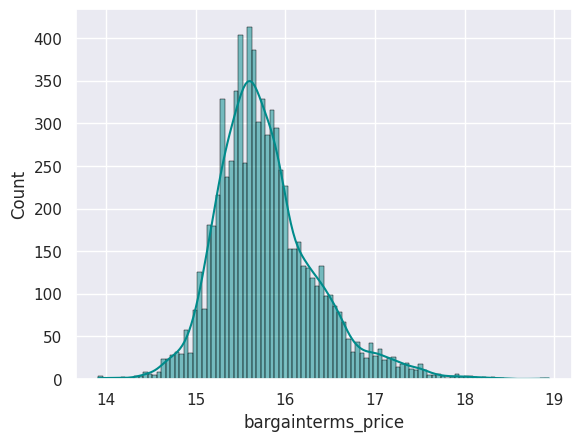

In [63]:
sns.histplot(np.log(second_nn['bargainterms_price']),
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=100  # тут можно изменять количество интервалов гистограммы и делать ее более презентабильной
            )
plt.show()

Посмотрим аномально (экстримально) дешевые / дорогие объекты и отсечем их.  

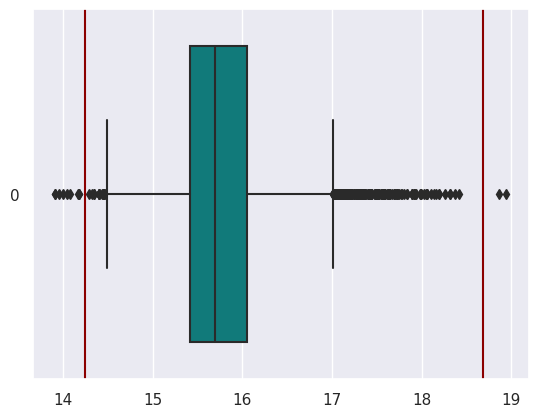

In [64]:
sns.boxplot(np.log(second_nn['bargainterms_price']),
            color='darkcyan',
            orient = 'h'
            )

plt.axvline(14.24, color = 'darkred') # подбираем пороги для отсечения
plt.axvline(18.68, color = 'darkred')  # подбираем пороги для отсечения

plt.show()

In [65]:
second_nn['bargainterms_price_ln'] = np.log(second_nn['bargainterms_price'])

In [ ]:
f_1 = second_nn['bargainterms_price_ln'] >= 14.24
f_2 = second_nn['bargainterms_price_ln'] <= 18.68

second_nn = second_nn[f_1 & f_2]
second_nn.reset_index(drop = True , inplace = True)
second_nn

#### 6.3 Общая площадь area_total

In [67]:
second_nn['area_total'].describe()

count    7756.000000
mean       53.754395
std        25.110290
min         9.000000
25%        38.600000
50%        48.000000
75%        63.000000
max       382.600000
Name: area_total, dtype: float64

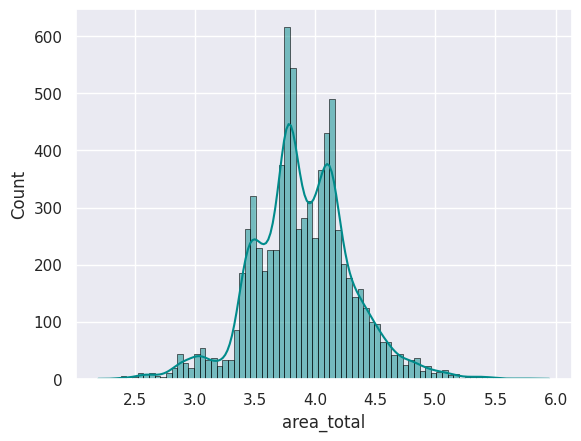

In [68]:
sns.histplot(np.log(second_nn['area_total']),
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=80 # тут можно изменять количество интервалов гистограммы и делать ее более презентабильной
            )
plt.show()

In [ ]:
second_nn[second_nn['area_total'] >= 350]

In [ ]:
second_nn[second_nn['area_total'] <= 15]

In [71]:
len(second_nn[second_nn['area_total'] <= 13])

19

In [72]:
second_nn = second_nn[second_nn['area_total'] > 15]
#second_kaz = second_kaz[second_kaz['area_total'] < 350]
second_nn.reset_index(drop = True , inplace = True)

#### 6.4 Год ввода year_release или год постройки bti_year_built

Смотрим, в каком из столбцов меньше пропусков, его и возьмем в модель

In [73]:
print(second_nn['year_release'].isna().mean())
print(second_nn['bti_year_built'].isna().mean())

0.31099299974073114
0.811122634171636


In [74]:
second_nn['year_release'].describe()

count    5315.000000
mean     1989.477140
std        25.397095
min      1813.000000
25%      1969.000000
50%      1987.000000
75%      2014.000000
max      2026.000000
Name: year_release, dtype: float64

In [75]:
len(second_nn[second_nn['year_release'] >= 2025])

5

In [76]:
second_nn = second_nn[(second_nn['year_release'].isnull()) | (second_nn['year_release'] < 2025)]
second_nn.reset_index(drop = True , inplace = True )

Посмотрим на график распределения годов ввода:

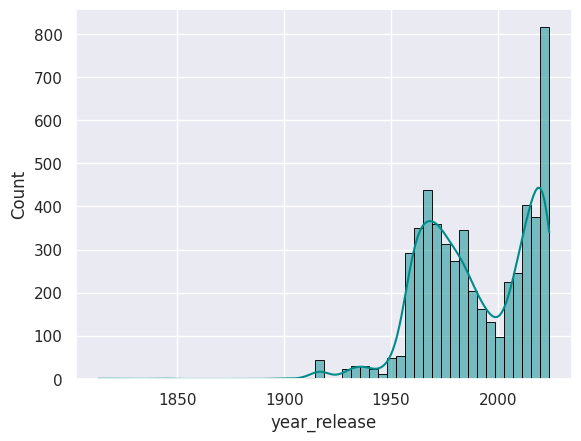

In [77]:
sns.histplot(second_nn['year_release'],
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=50 # тут можно изменять количество интервалов гистограммы и делать ее более презентабильной
            )
plt.show()

#### 6.5 Проверяем этаж floor и этажность floors_count

In [78]:
print(second_nn['floor'].isna().mean())
print(second_nn['floors_count'].isna().mean())

0.0
0.0


In [79]:
second_nn['floors_count'].describe()  # описательная статистика по этажности

count    7709.000000
mean        9.258529
std         5.422638
min         1.000000
25%         5.000000
50%         9.000000
75%        10.000000
max        90.000000
Name: floors_count, dtype: float64

In [ ]:
second_nn[second_nn['floors_count'] < 2]  # выводим объекты с этажностью 0 и 1

Удаляем объекты с этажностью < 2:

In [81]:
second_nn = second_nn[second_nn['floors_count'] >= 2]
second_nn.reset_index(drop = True , inplace = True )

In [82]:
second_nn['floor'].describe() # описательная статистика по этажу расположения

count    7702.000000
mean        5.164373
std         4.021109
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        25.000000
Name: floor, dtype: float64

Смотрим и удаляем объекты с этажом 0 и 1

In [83]:
second_nn[second_nn['floor'] < 1]

Empty DataFrame
Columns: [cian_id, url, bargainterms_price, area_total, address, floor, floors_count, year_release, wall_type, last_edited, repair_type, bti_year_built, lat, lng, geo_region, geo_settlement, geo_city, geo_street, geo_house_num, geo_microdistrict, geo_city_district, subway_name, subway_time, subway_travel_type, description, days_after_edit, poly_okrug, poly_district, bargainterms_price_ln]
Index: []

Смотрим объекты, где этаж расположения > этажности здания и удаляем как ошибочные

In [ ]:
second_nn[second_nn['floors_count'] < 2]  # выводим объекты с этажностью 0 и 1

In [85]:
second_nn = second_nn[second_nn['floor'] <= second_nn['floors_count']]
second_nn.reset_index(drop = True , inplace = True )

#### 6.6 Проверяем объекты на актуальность объявления
Выведем объекты, последнее обновление по которым было более года назад.  
Отфильтровать их можно либо по колонке 'last_edited', либо по колонке 'days_after_edit'  
Удаляем их из выборки

In [ ]:
# вариант 1
second_nn[second_nn['last_edited'] <= '2024-02-10'] 

In [ ]:
# вариант 2
second_nn[second_nn['days_after_edit'] >= 365]

Объем предложений больше 140 дней: 9


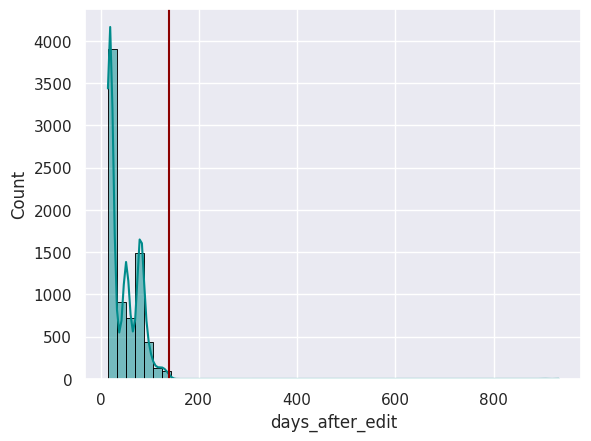

In [88]:
tr = 140 # порог, по которому производится отсечение
print(f'Объем предложений больше {tr} дней:', len(second_nn[second_nn['days_after_edit'] >= tr]))

sns.histplot(second_nn['days_after_edit'],
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=50
            )

plt.axvline(tr, color = 'darkred') # подбираем границы для удаления

plt.show()

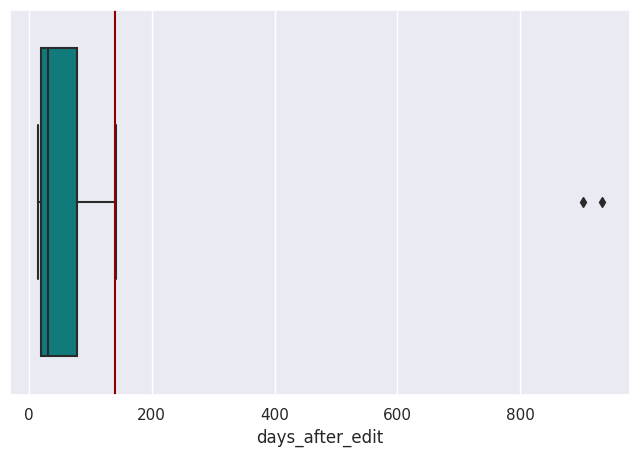

In [89]:
plt.figure(figsize = (8, 5))

sns.boxplot(data = second_nn,
            x = 'days_after_edit',
            color = 'darkcyan'
            )

plt.axvline(tr, color = 'darkred') # подбираем границы для удаления

In [90]:
second_nn = second_nn[second_nn['days_after_edit'] < tr] # оставляем объявления со сроком экспозиции до 140 дней
second_nn.reset_index(drop = True , inplace = True)
len(second_nn)

7688

# <font color='008B8B'> 7. Добавление новых фичей </font> ✨

#### 7.1 Определим цену за кв.м., LN цены и LN цены за кв.м.

In [91]:
second_nn['unit_price'] = second_nn['bargainterms_price'] // second_nn['area_total'] # цена за кв.м.

In [92]:
second_nn['unit_price'].isna().mean()

0.0

In [93]:
second_nn['unit_price'].describe()

count      7688.000000
mean     153025.228668
std       56685.685602
min       25387.000000
25%      115292.250000
50%      139121.000000
75%      176996.000000
max      899900.000000
Name: unit_price, dtype: float64

In [94]:
second_nn['bargainterms_price_LN'] = np.log(second_nn['bargainterms_price']) # LN цены

In [95]:
second_nn['bargainterms_price_LN'].isna().mean()

0.0

In [96]:
second_nn['bargainterms_price_LN'].describe()

count    7688.000000
mean       15.788394
std         0.544364
min        14.403297
25%        15.424948
50%        15.701064
75%        16.059936
max        18.420681
Name: bargainterms_price_LN, dtype: float64

In [97]:
second_nn['unit_price_LN'] = np.log(second_nn['unit_price']) # LN цены за кв.м.

In [98]:
second_nn['unit_price_LN'].isna().mean()

0.0

In [99]:
second_nn['unit_price_LN'].describe()

count    7688.000000
mean       11.883427
std         0.320166
min        10.141993
25%        11.655225
50%        11.843099
75%        12.083882
max        13.710039
Name: unit_price_LN, dtype: float64

Для удобства построим боксплоты LN цены и LN цены за кв.м.:

<function matplotlib.pyplot.show(close=None, block=None)>

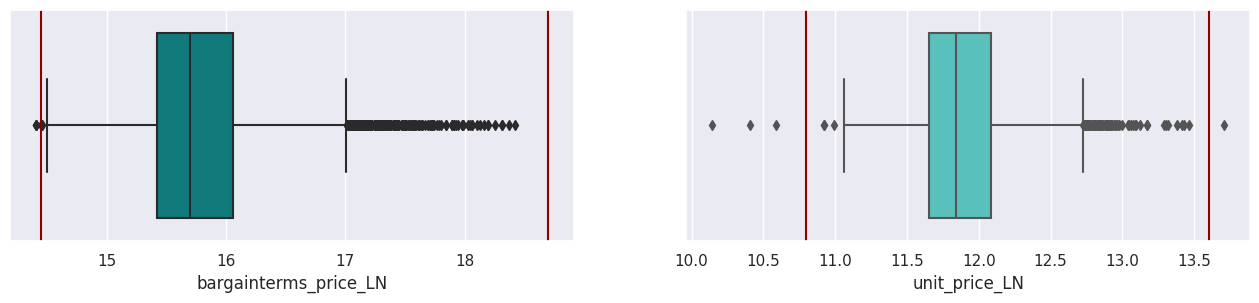

In [100]:
fig, ax = plt.subplots(1, 2, figsize = (16, 3))

sns.boxplot(data = second_nn,
            x = second_nn['bargainterms_price_LN'],
            color = 'darkcyan',
            ax = ax[0]
             )

ax[0].axvline(14.45, color = 'darkred') # подбираем границы для удаления
ax[0].axvline(18.7, color = 'darkred') # подбираем границы для удаления

sns.boxplot(data = second_nn,
            x = second_nn['unit_price_LN'],
            color = 'mediumturquoise',
            ax = ax[1]
            )

ax[1].axvline(10.8, color = 'darkred') # подбираем границы для удаления
ax[1].axvline(13.6, color = 'darkred') # подбираем границы для удаления

plt.show

In [101]:
#second_nn = second_nn[(second_nn['bargainterms_price_LN'] > 14.45) & (second_nn['bargainterms_price_LN'] < 18.7)]
second_nn = second_nn[(second_nn['unit_price_LN'] > 10.8) & (second_nn['unit_price_LN'] < 13.6)]
second_nn.reset_index(drop = True , inplace = True )
len(second_nn)

7684

#### 7.2 Определим ближайшую станцию метро и расстояние до нее (функция haversine)
Загружаем файл с названием станций, широтой и долготой

In [102]:
Stm_all_1 = {'Название_станции': ['Горьковская', 'Московская', 'Чкаловская', 'Ленинская', 'Заречная', 'Двигатель_Революции', 'Пролетарская', 
                                  'Автозаводская', 'Комсомольская', 'Кировская', 'Парк_культуры', 'Стрелка', 'Московская', 'Канавинская',
                                  'Бурнаковская', 'Буревестник'],
             'Широта': [56.314012, 56.321327, 56.310595, 56.299071, 56.285123, 56.276457, 56.266455, 56.257345, 56.252661, 56.247409, 56.242006, 
                     56.335286, 56.321330, 56.320737, 56.325778, 56.333524],
             'Долгота': [43.994238, 43.948137, 43.937027, 43.937926, 43.927521, 43.921167, 43.913385, 43.902207, 43.889879, 43.876728, 43.858125, 
                     43.949533, 43.948128, 43.926701, 43.911996, 43.894013]
            }

In [103]:
metro = pd.DataFrame(Stm_all_1)
metro

Название_станции     Широта    Долгота
0           Горьковская  56.314012  43.994238
1            Московская  56.321327  43.948137
2            Чкаловская  56.310595  43.937027
3             Ленинская  56.299071  43.937926
4              Заречная  56.285123  43.927521
5   Двигатель_Революции  56.276457  43.921167
6          Пролетарская  56.266455  43.913385
7         Автозаводская  56.257345  43.902207
8         Комсомольская  56.252661  43.889879
9             Кировская  56.247409  43.876728
10        Парк_культуры  56.242006  43.858125
11              Стрелка  56.335286  43.949533
12           Московская  56.321330  43.948128
13          Канавинская  56.320737  43.926701
14         Бурнаковская  56.325778  43.911996
15          Буревестник  56.333524  43.894013

In [104]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Радиус Земли в километрах
    lat1_rad = np.radians(lat1) #широта квартиры
    lon1_rad = np.radians(lon1) #долгота квартиры
    lat2_rad = np.radians(lat2) #широта метро
    lon2_rad = np.radians(lon2) #долгота метро

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c  # Расстояние в километрах
    return distance

# Загрузка данных
apartments = second_nn[['lat', 'lng']] #.iloc[0:1000]
metro_stations =  metro[['Название_станции', 'Широта', 'Долгота']]

# Создаем новые столбцы для ближайшей станции и расстояния
apartments['nearest_metro'] = None
apartments['distance_to_nearest_metro'] = None

# Вычисляем расстояния
for i, apartment in tqdm(apartments.iterrows(), total = apartments.shape[0], position = 0):
    min_distance = float('inf')
    nearest_station = None
    
    #for j, station in tqdm(metro_stations.iterrows(), total = metro_stations.shape[0], desc = 'Поиск ближайшей станции метро', leave = False):
    for j, station in metro_stations.iterrows():
        distance = haversine(apartment['lat'], apartment['lng'], station['Широта'], station['Долгота'])
        
        if distance < min_distance:
            min_distance = distance
            nearest_station = station['Название_станции']  # Предполагается, что в таблице метро есть столбец 'name'
    
    apartments.at[i, 'nearest_metro'] = nearest_station
    apartments.at[i, 'distance_to_nearest_metro'] = min_distance

apartments


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 7684/7684 [00:20<00:00, 366.78it/s]


lat       lng  nearest_metro distance_to_nearest_metro
0     56.30257  44.07780    Горьковская                  5.309017
1     56.31702  43.95014     Московская                  0.494588
2     56.24159  43.84796  Парк_культуры                  0.629795
3     56.23016  43.86029  Парк_культуры                  1.323993
4     56.30937  44.00477    Горьковская                   0.82969
...        ...       ...            ...                       ...
7679  56.26037  43.85841      Кировская                  1.832311
7680  56.31739  43.87716    Буревестник                  2.073202
7681  56.23016  43.86029  Парк_культуры                  1.323993
7682  56.21701  43.86342  Парк_культуры                  2.798631
7683  56.34446  43.86781    Буревестник                  2.021594

[7684 rows x 4 columns]

In [ ]:
second_nn['nearest_metro'] = apartments['nearest_metro']
second_nn['distance_to_nearest_metro'] = apartments['distance_to_nearest_metro']
second_nn

#### 7.3 Сцепка_к ('lat_lng')
Создаем новый столбец с объединенными координатами в формате ‘Широта Долгота’

In [106]:
second_nn['lat_lng'] = ((second_nn['lat'].astype(str)).str.cat(second_nn['lng'].astype(str), sep = ' '))

In [ ]:
second_nn.head(2)

#### 7.4 Расстояние до центра (числовое и категориальное) 
При помощи функции haversine определяем расстояние до центра от каждого из объектов в километрах и записываем в столбец ‘distance_to_centre’

In [108]:
apartments = second_nn[['lat', 'lng']] #.iloc[0:1000]

apartments['distance_to_centre'] = None

## Координата центра - Нижегородский Кремль
lat_center = 56.328437
lng_center = 44.003111

# Вычисляем расстояния
for i, apartment in tqdm(apartments.iterrows(), total = apartments.shape[0], position = 0):
    distance = haversine(apartment['lat'], apartment['lng'], lat_center, lng_center)
        
    apartments.at[i, 'distance_to_centre'] = distance

apartments


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 7684/7684 [00:01<00:00, 5857.38it/s]


lat       lng distance_to_centre
0     56.30257  44.07780           5.430419
1     56.31702  43.95014           3.504196
2     56.24159  43.84796          13.599813
3     56.23016  43.86029          14.040834
4     56.30937  44.00477            2.12262
...        ...       ...                ...
7679  56.26037  43.85841          11.705042
7680  56.31739  43.87716           7.862544
7681  56.23016  43.86029          14.040834
7682  56.21701  43.86342          15.096257
7683  56.34446  43.86781           8.527746

[7684 rows x 3 columns]

In [109]:
second_nn['distance_to_centre'] = apartments['distance_to_centre']

Построим график зависимости цены от расстояния до центра, и на основании его, создадим бины для категориального расстояния до центра

Смотрим зависимость цены за кв.м. от расстояния до центра.  

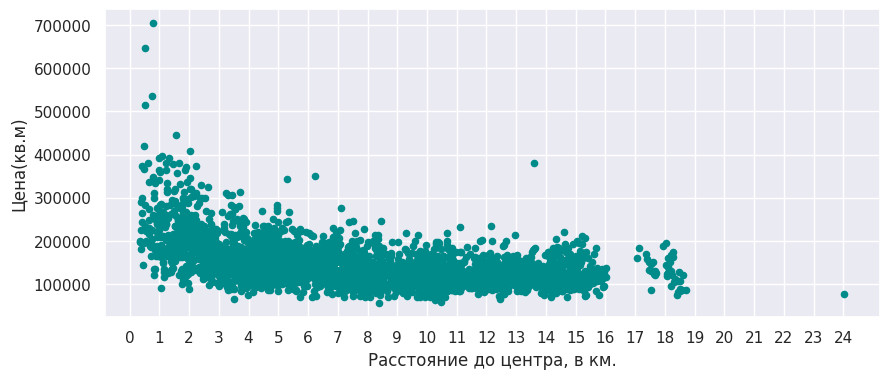

In [110]:
centre = second_nn.groupby('distance_to_centre')['unit_price'].agg(['count','median'])
centre = centre.reset_index()

centre.plot.scatter(x = 'distance_to_centre', 
                    y = 'median', 
                    figsize = (10, 4),
                    color = 'darkcyan'
                   )

plt.xlabel('Расстояние до центра, в км.')
plt.ylabel('Цена(кв.м)')
plt.xticks(range(0, 25, 1))  # 0 - начало шкалы, 25 - конец, 1 - это шаг делений. Нужно прописать свои
plt.show()

In [111]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

def bining_dt(data, x, y, max_depth = 2, min_samples_leaf = 10, min_samples_split = 10, max_features = None, rotation = 0):
    '''
    x - фактор, который мы разбиваем на бины. Например, 'Этаж_1'.
    y - таргет, на который ориентируемся при разбиении x на бины (цена за 1 кв.м). Например, 'LN(Цена_кв.м)'.
    max_depth - глубина дерева (чем глубже дерево, тем больше бинов).
    min_samples_leaf - минимальный объем выборки, который должен быть в каждом листе после разбиения.
    min_samples_split - минимальный объем выборки, который должен быть в узле, чтобы этот узел мог быть разделен на 2.
    max_features - максимальное количество факторов, по которым ищется лучшее разбиение в дереве (при большом количестве факторов дорого искать лучшее решение). 
                   В нашем случае используются только 1 фактор, поэтому устанавливаем None (все факторы).
    rotation - поворот значений по оси Х (по умолчанию 0).
    '''
    df_bins = data.copy()
    
    DT = DecisionTreeRegressor(max_depth = max_depth,                                                                       # глубина дерева, см. описание выше
                               min_samples_leaf = min_samples_leaf,                                                         # см. описание выше
                               min_samples_split = min_samples_split,                                                       # см. описание выше
                               max_features = max_features,                                                                 # см. описание выше
                               random_state = 42                                                                            # см. описание выше
                              ) 
    DT.fit(df_bins[[x]], df_bins[y])                                                                                        # обучаем модель DT
 
    thresholds = []                                                                                                         # список границ бинов
    for i in range(DT.tree_.node_count):                                                                                    # перебираем все узлы в дереве
        if DT.tree_.children_left[i] != -1:                                                                                 # только узлы, где происходит разбиение (-1 в узле нет разбиения)
            thresholds.append(int(DT.tree_.threshold[i] + 0.5))                                                             # вытаскиваем пороги разбиения с учетом округления

    thresholds.sort()                                                                                                       # сортируем границы от мин до макс
    thresholds_list = [df_bins[x].min()] + list(thresholds) + [df_bins[x].max() + 1]                                        # список границ бинов
    thresholds_list = list(set(thresholds_list))                                                                            # удаляются дубликаты при их наличии
    thresholds_list.sort()

    bins = pd.cut(df_bins[x], bins = thresholds_list, right = False, include_lowest = True)                                 # делим фактор на бины
    
    df_bins['bins'] = bins
    variance_in_bins = np.sqrt(df_bins.groupby('bins')[y].var())                                                            # разброс внутри бина
    average_variance_in_bins = np.sqrt(df_bins.groupby('bins')[y].var()).mean()                                             # средний разброс по всем бинам
        
    plt.figure(figsize = (16, 10))
    
    plt.subplot(2, 2, 1)                                                                                                    # строка, столбец, индекс
    sns.boxplot(
                x = 'bins', 
                y = y, 
                data = df_bins,
                #color = 'grey',
                #ax = ax[1]
                )
    plt.xticks(rotation = rotation)

    plt.subplot(2, 2, 2)
    sns.lineplot(
                 df_bins.groupby(x)[y].median()       
                 #x = 'bins', 
                 #y = y, 
                 #data = data,
                 #color = 'grey',
                 #ax = ax[1]
                 )
    sns.lineplot(
                 df_bins.groupby(x)[y].mean()       
                 #x = 'bins', 
                 #y = y, 
                 #data = data,
                 #color = 'grey',
                 #ax = ax[1]
                 )
    
    plt.subplot(2, 1, 2)
    plot_tree(DT, feature_names = [x], filled = True, rounded = True)
    
    plt.show()
    
    return bins, variance_in_bins, average_variance_in_bins

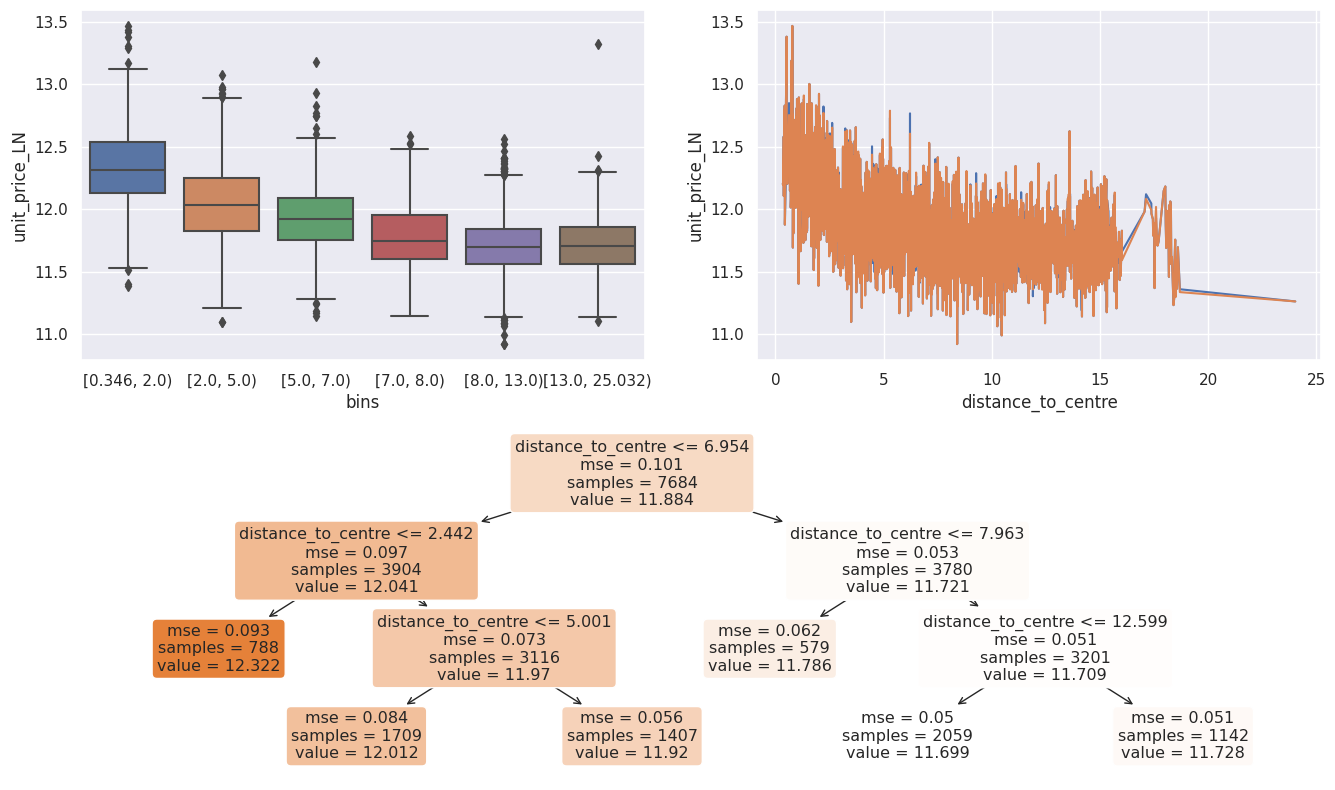

In [112]:
bins, variance_in_bins, average_variance_in_bins = bining_dt(data = second_nn, 
                                                             x = 'distance_to_centre', 
                                                             y = 'unit_price_LN',
                                                             max_depth = 3, 
                                                             min_samples_leaf = 500, 
                                                             min_samples_split = 500
                                                            )

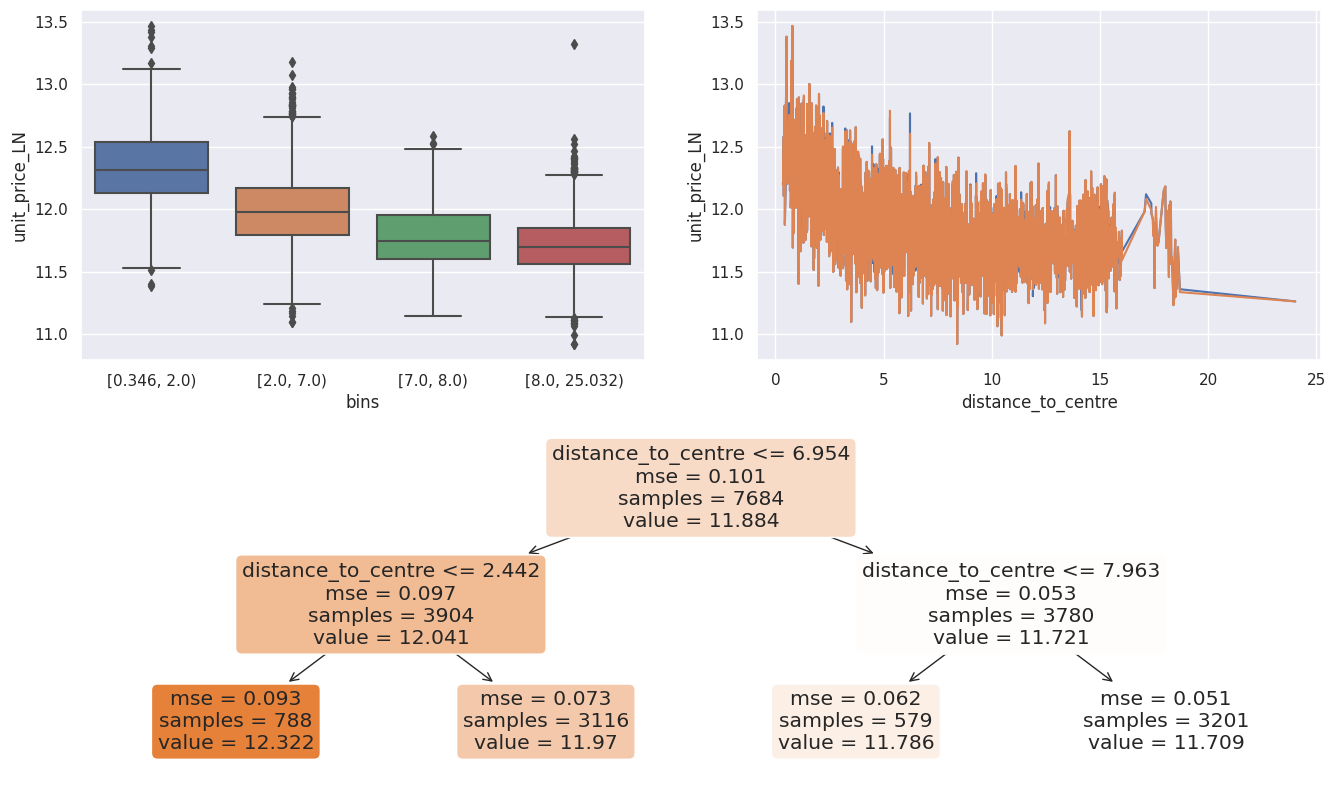

In [113]:
bins, variance_in_bins, average_variance_in_bins = bining_dt(data = second_nn, 
                                                             x = 'distance_to_centre', 
                                                             y = 'unit_price_LN',
                                                             max_depth = 2, 
                                                             min_samples_leaf = 500, 
                                                             min_samples_split = 500
                                                            )

In [114]:
# разбиваем на бины
с_labels = ['до_2_км ', 'от_2_до_5_км', 'от_5_до_7_км', 'от_7_до_8_км', 'от_8_км']  
с_bins = [-1, 2, 5, 7, 8, 1000]
second_nn['distance_to_centre_1'] = pd.cut(second_nn['distance_to_centre'], bins = с_bins, labels = с_labels)

In [115]:
second_nn['distance_to_centre_1'].value_counts()

от_8_км         3164
от_2_до_5_км    1970
от_5_до_7_км    1422
от_7_до_8_км     601
до_2_км          527
Name: distance_to_centre_1, dtype: int64

Построим боксплоты по созданным категориям

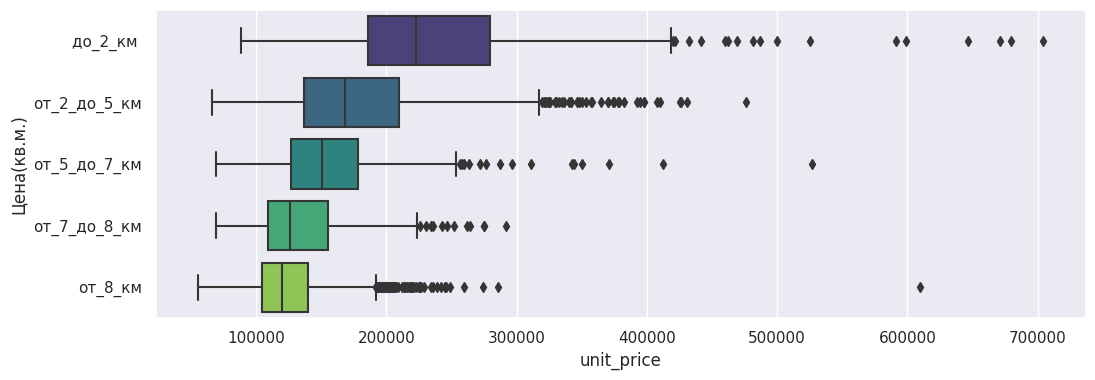

In [116]:
plt.figure(figsize = (12, 4))
sns.boxplot(data = second_nn,
            x = second_nn['unit_price'],
            y = second_nn['distance_to_centre_1'],
            palette = 'viridis'
            )
plt.ylabel('Цена(кв.м.)')
plt.show()

#### 7.5 Категориальная площадь объекта
Создаем дополнительный столбец с общей площадью объекта в виде категории.  
Используем для всех объектов следующие бины: 'до_28', 'от_28_до_42', 'от_42_до_65', 'от_65_до_85', 'от_85_до_105', 'более_105'.

In [215]:
s_labels = ['до_28', 'от_28_до_42', 'от_42_до_65', 'от_65_до_85', 'от_85_до_105', 'более_105']  
s_bins = [0, 28, 42, 65, 85, 105, 1000] 
second_nn['area_total_1'] = pd.cut(second_nn['area_total'], bins = s_bins, labels = s_labels)

In [216]:
second_nn['area_total_1'].isna().mean()

0.0

In [217]:
second_nn['area_total_1'].value_counts()

от_42_до_65     3643
от_28_до_42     2041
от_65_до_85      975
до_28            393
от_85_до_105     351
более_105        272
Name: area_total_1, dtype: int64

#### 7.6 Создание интервалов цен

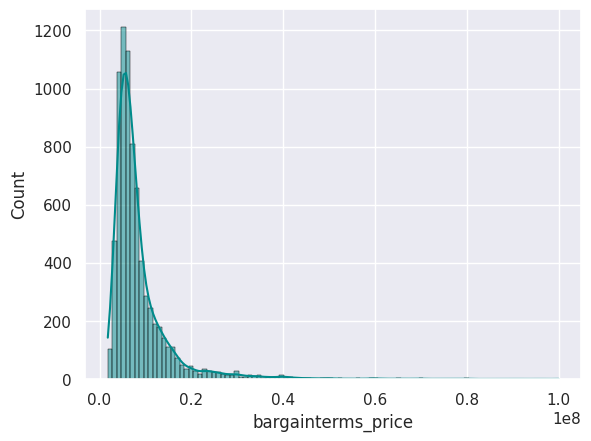

In [118]:
sns.histplot(second_nn['bargainterms_price'],
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=100)
plt.show()

Разбиваем выборку на категории, исходя из цены объекта bargainterms_price  
Создаем новый столбец bargainterms_price_bins

In [119]:
# разбиваем на бины
p_labels = ['до_3_млн','от_3_до_6_млн ', 'от_6_до_9_млн', 'от_9_до_12_млн', 'от_12_до_15_млн', 'от_15_до_20_млн', 'свыше_20_млн']  
p_bins = [0, 3000000, 6000000, 9000000, 12000000, 15000000, 20000000, 900000000]
second_nn['bargainterms_price_bins'] = pd.cut(second_nn['bargainterms_price'], bins = p_bins, labels = p_labels)

In [120]:
second_nn['bargainterms_price_bins'].value_counts()

от_3_до_6_млн      3098
от_6_до_9_млн      2367
от_9_до_12_млн      831
от_12_до_15_млн     474
свыше_20_млн        386
от_15_до_20_млн     346
до_3_млн            182
Name: bargainterms_price_bins, dtype: int64

#### 7.7 Сравниваем объекты с базой элитки 
Создаем столбец с новым фактором ‘is_elit’, где отображается, относится ли объект к элитному сегменту рынка.   
Для создания фактора элитности используем полигоны, в результате столбец будет содержать для каждого объекта категорию ‘престижный’, ‘престижный+’ или ‘нет’

In [121]:
elit_dict = {'ЖК': ['ЖК «Дворянский»', 'ЖК «Trinity (Тринити)»', 'ЖК «КМ Residence Prime»', 'ЖК «Royal Landmark (Роял Лэндмарк)»', 'ЖК «Шаляпин»',
                    'ЖК «Георгиевский»', 'ЖК «Плотничный»', 'ЖК «Минин»', 'ЖК «Изумрудный замок»', 'ЖК «Renaissance (Ренессанс)»', 'ЖК «Коллекция»',
                    'ЖК «Дом на Гребешке»', 'ЖК «Симфония Нижнего»', 'ЖК «Клубный дом на Ярославской»', 'ЖК «Атлант Сити»', 'ЖК «Riverside»',
                    'Дом на Свободе', 'Либерти', 'Командор', 'Георгиеский', 'Аристократ', 'Дом с Террасами', 'Минина 1'],
             'Координаты': [[(56.318997, 43.983134), (56.31908, 43.98404), (56.319611, 43.984217), (56.319572, 43.985032),
                             (56.319167, 43.98508), (56.319143, 43.985697), (56.318836, 43.985681), (56.318761, 43.985037), 
                             (56.318376, 43.985096), (56.318382, 43.985622), (56.318144, 43.985611), (56.318141, 43.984366),
                             (56.318747, 43.984286), (56.318731, 43.983251)],
                            [(56.322563, 44.017009), (56.322956, 44.017331), (56.322809, 44.017842), (56.322433, 44.017509)],
                            [(56.311314, 43.972708), (56.311068, 43.975437), (56.310778, 43.975304), (56.310756, 43.972762)],
                            [(56.328143, 44.020328), (56.328459, 44.020597), (56.328047, 44.022232), (56.327729, 44.021947)],
                            [(56.322106, 44.001879), (56.322391, 44.001806), (56.322979, 44.00237), (56.322949, 44.003561),
                             (56.322569, 44.003522), (56.322356, 44.002812), (56.322171, 44.002858)],
                            [(56.329627, 44.010576), (56.329245, 44.010593), (56.3289, 44.01047), (56.328758, 44.012155),
                             (56.32958, 44.01221)],
                            [(56.323224, 43.993969), (56.323097, 43.994202), (56.322867, 43.993955), (56.322592, 43.994637),
                             (56.323418, 43.995784), (56.323542, 43.995462), (56.323562, 43.99502), (56.323534, 43.99445)],
                            [(56.327078, 44.008611), (56.327629, 44.008868), (56.327463, 44.009655), (56.327143, 44.009393),
                             (56.327018, 44.009064)],
                            [(56.313312, 43.997401), (56.313991, 43.997447), (56.314261, 43.99903), (56.313294, 43.998997)],
                            [(56.313355, 44.002222), (56.313749, 44.002843), (56.313191, 44.003469), (56.313361, 44.004026),
                             (56.313125, 44.004249), (56.312696, 44.002921)],
                            [(56.321529, 44.005432), (56.3211, 44.005894), (56.321274, 44.006382), (56.321638, 44.00618)],
                            [(56.319819, 43.976268), (56.319566, 43.976221), (56.319496, 43.977256), (56.320034, 43.97729),
                             (56.3201, 43.976719), (56.319796, 43.976635)],
                            [(56.312607, 43.985521), (56.313137, 43.988135), (56.313728, 43.987742), (56.313978, 43.986238)],
                            [(56.319363, 43.977475), (56.31875, 43.977426), (56.318707, 43.978384), (56.318976, 43.978401),
                             (56.318998, 43.977861), (56.319351, 43.977805)],
                            [(56.30933, 44.070359), (56.309829, 44.071981), (56.310792, 44.07427), (56.309832, 44.075486),
                             (56.307971, 44.070922)],
                            [(56.325027, 43.988854), (56.325009, 43.989361), (56.325092, 43.989886), (56.324529, 43.990339),
                             (56.324512, 43.989508), (56.324647, 43.988924)],
                            [(56.318581, 44.01567), (56.320065, 44.016844), (56.319516, 44.017862), (56.318823, 44.016704),
                             (56.318594, 44.016829), (56.318366, 44.015919)],
                            [(56.320504, 44.017278), (56.32033, 44.017983), (56.319601, 44.018119), (56.31952, 44.017949),
                             (56.320133, 44.016992)],
                            [(56.32064, 44.017397), (56.320534, 44.017807), (56.321172, 44.0183), (56.32127, 44.017868)],
                            [(56.328889, 44.010488), (56.329622, 44.010599), (56.329564, 44.012202), (56.32876, 44.012163)],
                            [(56.322782, 44.024718), (56.323516, 44.025253), (56.323411, 44.025624), (56.323224, 44.025486),
                             (56.323037, 44.026288), (56.323454, 44.02665), (56.323377, 44.02709), (56.322399, 44.026309)],
                            [(56.311819, 43.981621), (56.312453, 43.981994), (56.312384, 43.982512), (56.312594, 43.98343),
                             (56.312802, 43.983585), (56.31268, 43.984498), (56.312396, 43.984619)],
                            [(56.327647, 44.010844), (56.327758, 44.010308), (56.328003, 44.010423), (56.328258, 44.010204),
                             (56.328592, 44.008908), (56.328919, 44.009181), (56.328825, 44.010369), (56.328435, 44.010416),
                             (56.328258, 44.0112)]],
              'Статус': ['престижный', 'престижный', 'престижный', 'престижный', 'престижный', 'престижный', 'престижный',
                         'престижный', 'престижный', 'престижный', 'престижный', 'престижный', 'престижный', 'престижный',
                         'престижный', 'престижный', 'престижный', 'престижный', 'престижный', 'престижный', 'престижный',
                         'престижный', 'престижный']
            }

In [122]:
def point_inside_polygon(x, y, poly, include_edges = True):
    '''
    Проверьте, находится ли точка (x,y) внутри многоугольника poly.

    poly - это многоугольник с N вершинами, определенный как 
    [(x1,y1),...,(xN,yN)] или [(x1,y1),...,(xN,yN),(x1,y1)]
    (функция отлично работает в обоих случаях)

    Геометрическая идея: точка находится внутри многоугольника, если горизонтальный луч
    справа от точки пересекает многоугольник четное число раз. 
    Отлично работает для невыпуклых многоугольников.
    '''
    n = len(poly)
    inside = False

    p1x, p1y = poly[0]
    for i in range(1, n + 1):
        p2x, p2y = poly[i % n]
        if p1y == p2y:
            if y == p1y:
                if min(p1x, p2x) <= x <= max(p1x, p2x):
                    #point is on horisontal edge
                    inside = include_edges
                    break
                elif x < min(p1x, p2x):  # point is to the left from current edge
                    inside = not inside
        else:   #p1y!= p2y
            if min(p1y, p2y) <= y <= max(p1y, p2y):
                xinters = (y - p1y) * (p2x - p1x) / float(p2y - p1y) + p1x

                if x == xinters:  # point is right on the edge
                    inside = include_edges
                    break

                if x < xinters:  # point is to the left from current edge
                    inside = not inside

        p1x, p1y = p2x, p2y

    return inside

In [123]:
from tqdm import tqdm

k = len(second_nn['lat']) #широта

status_elite = []
housing_complex = []

for i in tqdm(range(0, k, 1), 'Обработано'):
    for j, c, st, p in zip(range(1, len(elit_dict['ЖК']) + 1, 1), elit_dict['ЖК'], elit_dict['Статус'], elit_dict['Координаты']): #enumerate(polygons.items())
        poly = p
        x = second_nn['lat'][i] #широта
        y = second_nn['lng'][i] #долгота
        res = point_inside_polygon(x, y, poly, include_edges = True)

        if res == True:
            st_elite = st
            hc = c
            status_elite.append(st_elite)
            housing_complex.append(hc)
            break
        
        if (j == len(elit_dict['ЖК']) and res == False): # 
            st_elite = 999
            hc = 999
            status_elite.append(st_elite)
            housing_complex.append(hc)

Обработано: 100%|██████████| 7684/7684 [00:04<00:00, 1862.00it/s]


In [124]:
second_nn['status_elite'] = status_elite
second_nn['housing_complex'] = housing_complex

In [125]:
print(second_nn['status_elite'].unique())
print(second_nn['housing_complex'].unique())

[999 'престижный']
[999 'ЖК «Атлант Сити»' 'ЖК «Renaissance (Ренессанс)»' 'ЖК «Минин»'
 'Минина 1' 'Либерти' 'ЖК «КМ Residence Prime»' 'Командор'
 'Дом с Террасами' 'ЖК «Шаляпин»' 'ЖК «Дворянский»'
 'ЖК «Изумрудный замок»' 'Дом на Свободе' 'ЖК «Коллекция»'
 'ЖК «Дом на Гребешке»' 'Аристократ' 'ЖК «Riverside»' 'ЖК «Георгиевский»'
 'ЖК «Симфония Нижнего»' 'ЖК «Клубный дом на Ярославской»'
 'ЖК «Плотничный»']


In [ ]:
second_nn['status_elite'] = np.where(second_nn['status_elite'] == 999, 'нет', second_nn['status_elite'])
second_nn['housing_complex'] = np.where(second_nn['housing_complex'] == 999, 'нет', second_nn['housing_complex'])
second_nn

In [127]:
print(len(second_nn[second_nn['status_elite'] != 'нет']))
print(len(second_nn[second_nn['housing_complex'] != 'нет']))

153
153


In [128]:
second_nn['status_elite'].value_counts()

нет           7531
престижный     153
Name: status_elite, dtype: int64

In [ ]:
second_nn = second_nn.rename(columns={'status_elite': 'is_elit'})
second_nn.head(2)

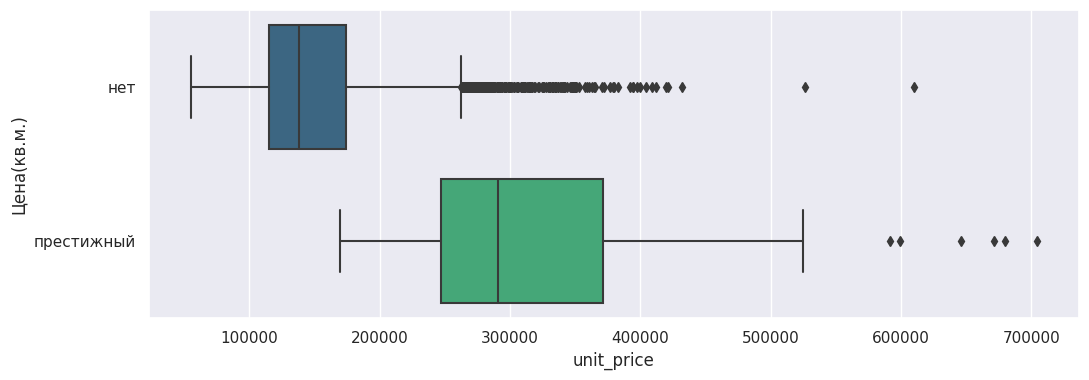

In [130]:
plt.figure(figsize = (12, 4))
sns.boxplot(data = second_nn,
            x = second_nn['unit_price'],
            y = second_nn['is_elit'],
            palette = 'viridis'
            )
plt.ylabel('Цена(кв.м.)')
plt.show()

Необходимо проверить цены по не престижным объектам с порогом более 400 000 руб./кв.м.

In [131]:
not_elit = second_nn[['cian_id', 'area_total', 'bargainterms_price', 'unit_price', 'geo_street', 'geo_house_num', 'is_elit', 'poly_district']] #отбираем нужные столбцы для удобства

f_1 = not_elit['is_elit'] == 'нет'
f_2 = not_elit['unit_price'] >= 400000

not_elit[f_1 & f_2]

cian_id  area_total  bargainterms_price  unit_price  \
2     200527485        41.0          25000000.0    609756.0   
1073  302080146       116.3          49000000.0    421324.0   
1486  304132453        65.5          27000000.0    412213.0   
1862  305317721       161.3          69700000.0    432114.0   
6083  310855910        91.2          36900000.0    404605.0   
6527  311299236       129.1          52800000.0    408985.0   
7092  312163217        65.5          34500000.0    526717.0   
7171  312237937        90.0          36000000.0    400000.0   
7345  312366361       106.0          44500000.0    419811.0   

               geo_street geo_house_num is_elit           poly_district  
2     Молодежный проспект          31к1     нет      посёлок_Колхозный   
1073         улица Минина          19/6     нет  Старый_Нижний_Новгород  
1486      улица Родионова         192к4     нет        Печёрская_Долина  
1862     Варварская улица            6а     нет  Старый_Нижний_Новгород  
6083     улица Белинского            66     нет  Старый_Нижний_Новгород  
6527     Варварская улица            6а     нет  Старый_Нижний_Новгород  
7092      улица Родионова         192к4     нет        Печёрская_Долина  
7171      улица Нестерова            22     нет  Старый_Нижний_Новгород  
7345     улица Белинского         58/60     нет  Старый_Нижний_Новгород

In [132]:
list(not_elit[f_1 & f_2].index)

[2, 1073, 1486, 1862, 6083, 6527, 7092, 7171, 7345]

По все указанным квартирам выявлены завышенные ожидания продавцов, в связи с чем удаляем их.

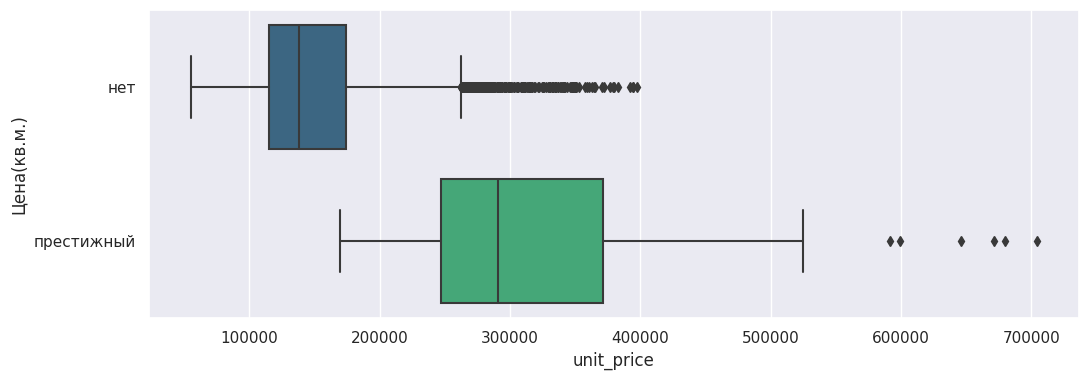

In [133]:
#del_idx = [2, 2912, 3304, 3337, 4219, 7114, 7619] #индексы для удаления
del_idx = list(not_elit[f_1 & f_2].index)

second_nn = second_nn.drop(del_idx)
second_nn.reset_index(drop = True , inplace = True)

plt.figure(figsize = (12, 4))
sns.boxplot(data = second_nn,
            x = second_nn['unit_price'],
            y = second_nn['is_elit'],
            palette = 'viridis'
            )
plt.ylabel('Цена(кв.м.)')
plt.show()

#### 7.8 Этаж категориальный
Создаем дополнительный столбец с этажом объекта ‘floor_1’, куда записываем этаж расположение объекта в виде категории.  
Как и в случае с расстоянием до центра, необходимо построить график зависимости удельной цены от этажа расположения объекта, и на основании визуального анализа определить категории. 

Для построения графика отфильтруем элитный сегмент и объекты на последних этажах

In [134]:
no_elit_last = second_nn[(second_nn['floor'] != second_nn['floors_count']) & (second_nn['floor'] != 1) & (second_nn['is_elit'] == 'нет')] # df для построения графика

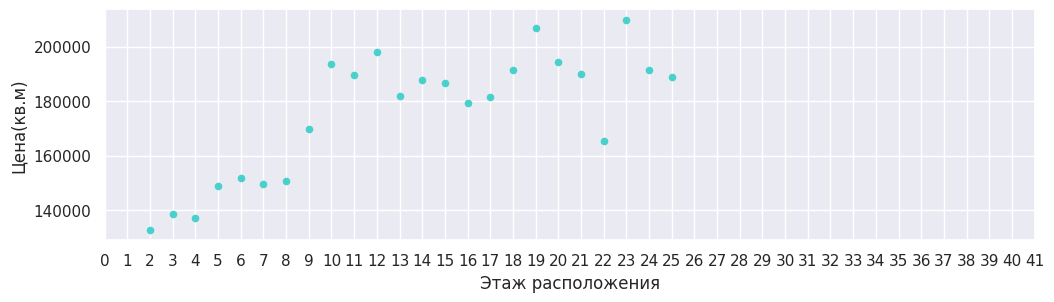

In [135]:
floors_cut = no_elit_last.groupby('floor')['unit_price'].agg(['count','median'])
floors_cut = floors_cut.reset_index()

floors_cut.plot.scatter(x = 'floor', 
                        y = 'median', 
                        figsize = (12, 3),
                        color = 'mediumturquoise'
                        )

plt.xlabel('Этаж расположения')
plt.ylabel('Цена(кв.м)')
plt.xticks(range(0, 42, 1))  # 0 - начало шкалы, 42 - конец, 1 - это шаг делений. Нужно прописать свои
plt.show()

**На графике визуально видим следующие бины:**
- до 4 этажа
- от 5 до 9 этажа
- от 10 и более

In [136]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

def bining_dt(data, x, y, max_depth = 2, min_samples_leaf = 10, min_samples_split = 10, max_features = None, rotation = 0):
    '''
    x - фактор, который мы разбиваем на бины. Например, 'Этаж_1'.
    y - таргет, на который ориентируемся при разбиении x на бины (цена за 1 кв.м). Например, 'LN(Цена_кв.м)'.
    max_depth - глубина дерева (чем глубже дерево, тем больше бинов).
    min_samples_leaf - минимальный объем выборки, который должен быть в каждом листе после разбиения.
    min_samples_split - минимальный объем выборки, который должен быть в узле, чтобы этот узел мог быть разделен на 2.
    max_features - максимальное количество факторов, по которым ищется лучшее разбиение в дереве (при большом количестве факторов дорого искать лучшее решение). 
                   В нашем случае используются только 1 фактор, поэтому устанавливаем None (все факторы).
    rotation - поворот значений по оси Х (по умолчанию 0).
    '''
    df_bins = data.copy()
    
    DT = DecisionTreeRegressor(max_depth = max_depth,                                                                       # глубина дерева, см. описание выше
                               min_samples_leaf = min_samples_leaf,                                                         # см. описание выше
                               min_samples_split = min_samples_split,                                                       # см. описание выше
                               max_features = max_features,                                                                 # см. описание выше
                               random_state = 42                                                                            # см. описание выше
                              ) 
    DT.fit(df_bins[[x]], df_bins[y])                                                                                        # обучаем модель DT
 
    thresholds = []                                                                                                         # список границ бинов
    for i in range(DT.tree_.node_count):                                                                                    # перебираем все узлы в дереве
        if DT.tree_.children_left[i] != -1:                                                                                 # только узлы, где происходит разбиение (-1 в узле нет разбиения)
            thresholds.append(int(DT.tree_.threshold[i] + 0.5))                                                             # вытаскиваем пороги разбиения с учетом округления

    thresholds.sort()                                                                                                       # сортируем границы от мин до макс
    thresholds_list = [df_bins[x].min()] + list(thresholds) + [df_bins[x].max() + 1]                                        # список границ бинов
    thresholds_list = list(set(thresholds_list))                                                                            # удаляются дубликаты при их наличии
    thresholds_list.sort()

    bins = pd.cut(df_bins[x], bins = thresholds_list, right = False, include_lowest = True)                                 # делим фактор на бины
    
    df_bins['bins'] = bins
    variance_in_bins = np.sqrt(df_bins.groupby('bins')[y].var())                                                            # разброс внутри бина
    average_variance_in_bins = np.sqrt(df_bins.groupby('bins')[y].var()).mean()                                             # средний разброс по всем бинам
        
    plt.figure(figsize = (16, 10))
    
    plt.subplot(2, 2, 1)                                                                                                    # строка, столбец, индекс
    sns.boxplot(
                x = 'bins', 
                y = y, 
                data = df_bins,
                #color = 'grey',
                #ax = ax[1]
                )
    plt.xticks(rotation = rotation)

    plt.subplot(2, 2, 2)
    sns.lineplot(
                 df_bins.groupby(x)[y].median()       
                 #x = 'bins', 
                 #y = y, 
                 #data = data,
                 #color = 'grey',
                 #ax = ax[1]
                 )
    sns.lineplot(
                 df_bins.groupby(x)[y].mean()       
                 #x = 'bins', 
                 #y = y, 
                 #data = data,
                 #color = 'grey',
                 #ax = ax[1]
                 )
    
    plt.subplot(2, 1, 2)
    plot_tree(DT, feature_names = [x], filled = True, rounded = True)
    
    plt.show()
    
    return bins, variance_in_bins, average_variance_in_bins

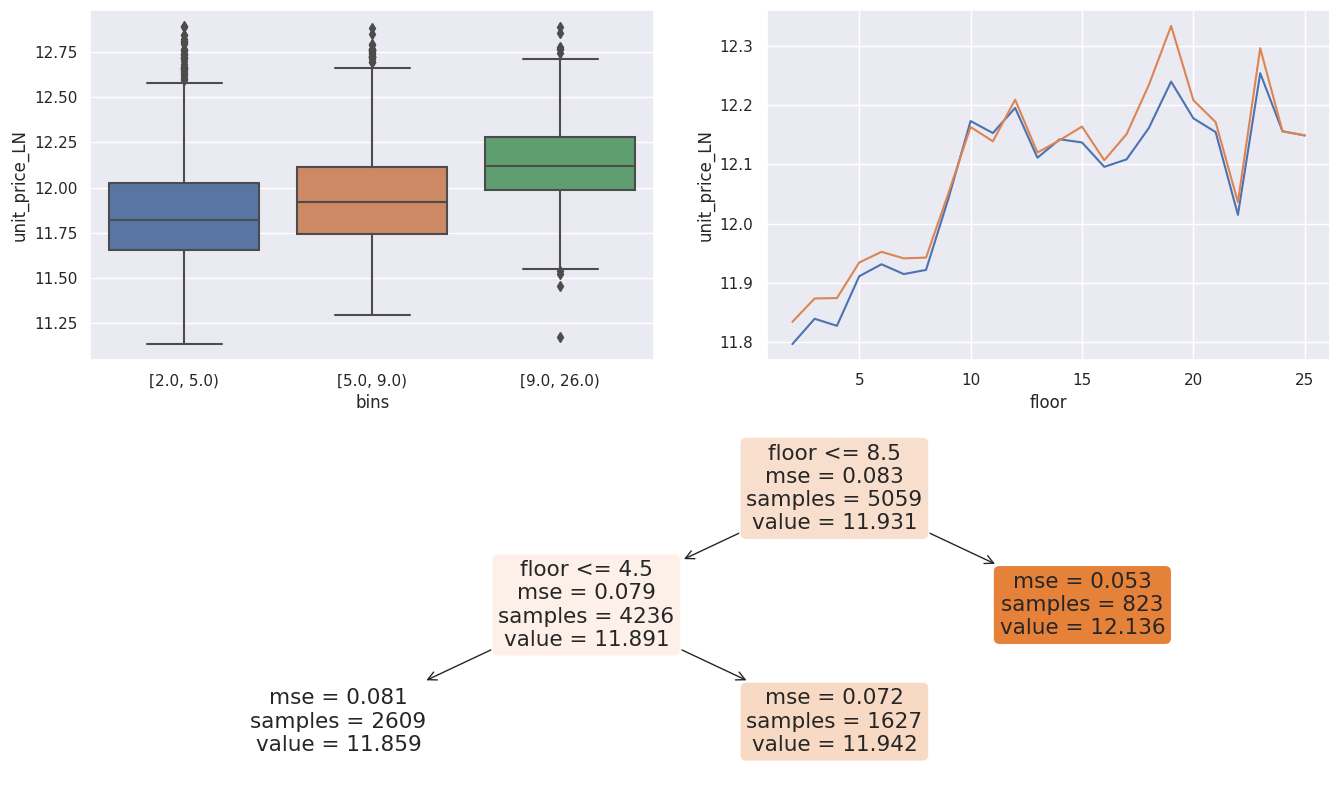

In [137]:
bins, variance_in_bins, average_variance_in_bins = bining_dt(data = no_elit_last, 
                                                             x = 'floor', 
                                                             y = 'unit_price_LN',
                                                             max_depth = 2, 
                                                             min_samples_leaf = 500, 
                                                             min_samples_split = 500
                                                            )

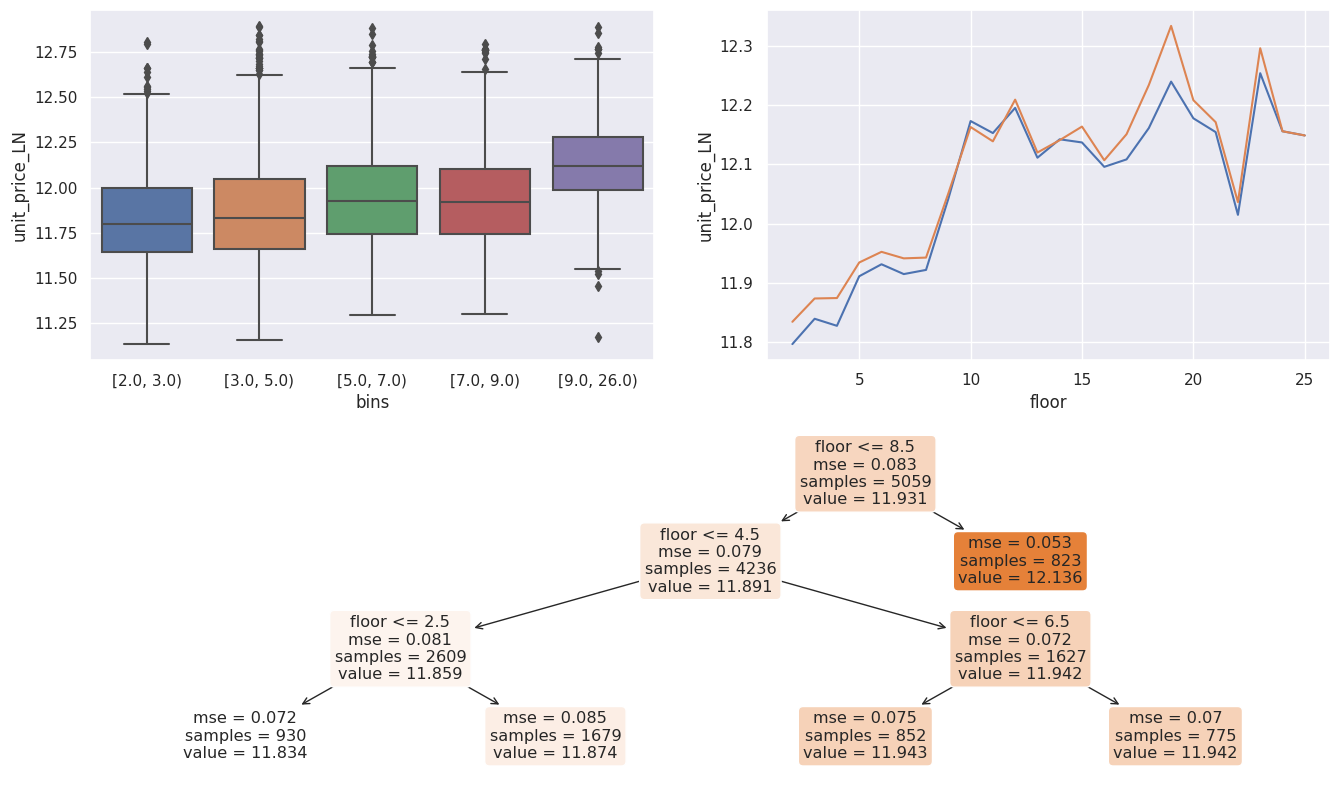

In [138]:
bins, variance_in_bins, average_variance_in_bins = bining_dt(data = no_elit_last, 
                                                             x = 'floor', 
                                                             y = 'unit_price_LN',
                                                             max_depth = 3, 
                                                             min_samples_leaf = 500, 
                                                             min_samples_split = 500
                                                            )

In [139]:
# разбиваем на бины
f_labels = ['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более']  
f_bins = [0, 4, 9, 40]
second_nn['floor_1'] = pd.cut(second_nn['floor'], bins = f_bins, labels = f_labels)

Заменим значение на 'первый' и 'последний' для объектов на последнем этаже:

In [140]:
second_nn['floor_1'] = np.where((second_nn['floor'] == 1), 'первый', second_nn['floor_1'])
second_nn['floor_1'] = np.where((second_nn['floor'] == second_nn['floors_count']), 'последний', second_nn['floor_1'])

In [141]:
second_nn['floor_1'].value_counts()

от_2_до_4_этажа    2645
от_5_до_9_этажа    1853
последний          1314
первый             1169
10_и_более          694
Name: floor_1, dtype: int64

In [ ]:
fl = '10_и_более'

print('Мин:', second_nn[second_nn['floor_1'] == fl]['floor'].min())
print('Мах:', second_nn[second_nn['floor_1'] == fl]['floor'].max())
second_nn[second_nn['floor_1'] == fl]

**В каждом отдельном городе нужно смотреть, влияет ли расположение на этаже на цену для элитки.**

In [143]:
second_nn[second_nn['is_elit'] != 'нет']['floor_1'].value_counts()

10_и_более         55
от_5_до_9_этажа    42
от_2_до_4_этажа    36
последний          12
первый              8
Name: floor_1, dtype: int64

Мы исключаем классы по floor_1 с маленьким объемом данных (первый, последний). Далее строим график boxplot.

Text(0.5, 1.0, 'Показатель цены (кв.м.) относительно этажа расположения для элитной недвижимости')

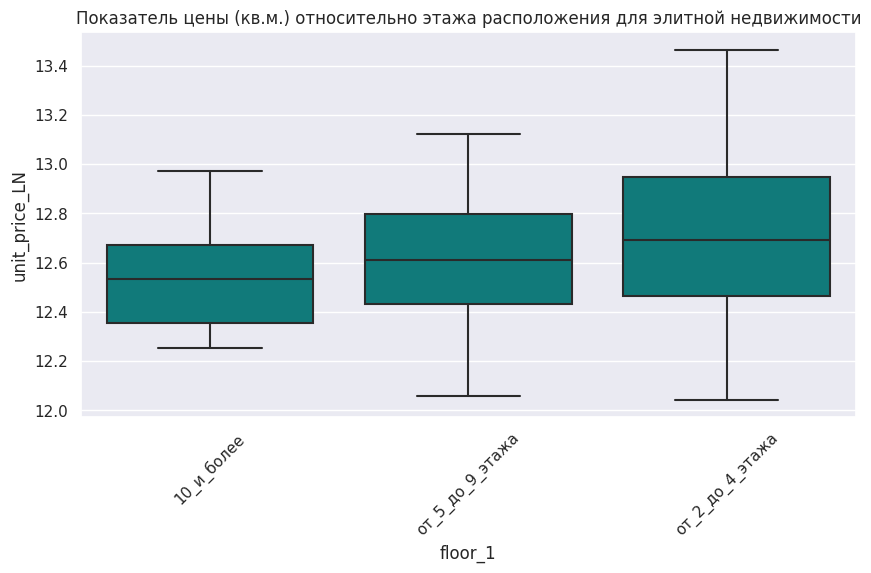

In [144]:
plt.figure(figsize = (10, 5))

sns.boxplot(data = second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])],
            x = 'floor_1', 
            y = 'unit_price_LN', 
            color = 'darkcyan'
           )

plt.xticks(rotation = 45)
plt.title('Показатель цены (кв.м.) относительно этажа расположения для элитной недвижимости')

На графике видно, что удельная цена изменяется в зависимости от этажа расположения. Необходимо проанализировать основные факторы, которые могут повлиять на изменение удельной цены внутри бина.  
Проводим анализ по факторам: отделка, район, статус ЖК:

#### Анализ отделки

In [145]:
pd.crosstab(second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])]['repair_type'],
            second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])]['floor_1'],
            normalize = 'columns'
           ).round(2)

floor_1      10_и_более  от_2_до_4_этажа  от_5_до_9_этажа
repair_type                                              
cosmetic           0.39             0.00             0.10
design             0.17             0.35             0.34
euro               0.00             0.09             0.12
no                 0.44             0.56             0.44

Бин от_2_до_4_этажа имеет высокую долю с дизайнерской отделкой и , в то же время, высокую долю без отделки.

#### Анализ района

In [146]:
pd.crosstab(second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])]['poly_district'],
            second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])]['floor_1'],
            normalize = 'columns'
           ).round(2)

floor_1                 10_и_более  от_2_до_4_этажа  от_5_до_9_этажа
poly_district                                                       
Печёрская_Долина              0.82             0.22             0.29
Старый_Нижний_Новгород        0.18             0.78             0.71

Бины от_2_до_4_этажа и от_5_до_9_этажа имеют высокую долю квартир, которые находятся в центре города (Старый_НН) в отличии от бина 10_и_более.

#### Анализ статуса

In [147]:
pd.crosstab(second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])]['is_elit'],
            second_nn[(second_nn['is_elit'] != 'нет') & second_nn['floor_1'].isin(['от_2_до_4_этажа', 'от_5_до_9_этажа', '10_и_более'])]['floor_1'],
            normalize = 'columns'
           ).round(2)

floor_1     10_и_более  от_2_до_4_этажа  от_5_до_9_этажа
is_elit                                                 
престижный         1.0              1.0              1.0

Таким образом, изменение удельной цены по элитному сегменту объясняется влиянием выше проанализированных факторов, а конкретно местоположение.

В этой связи, заменим значение на 'не_важно' для элитки.  

In [148]:
second_nn['floor_1'] = np.where((second_nn['is_elit'] != 'нет'), 'не_важно', second_nn['floor_1'])

In [149]:
second_nn['floor_1'].value_counts()

от_2_до_4_этажа    2609
от_5_до_9_этажа    1811
последний          1302
первый             1161
10_и_более          639
не_важно            153
Name: floor_1, dtype: int64

Посмотрим боксплоты по созданным категориям  

Для того, чтобы боксплоты шли по возрастанию, найдем медианную цену по категории

In [150]:
df_floor = second_nn.copy()  # делаем копию df и работаем с ней
df_floor['floor_med'] = df_floor.groupby('floor_1')['unit_price'].transform('median')
df_floor_sort = df_floor.sort_values('floor_med')

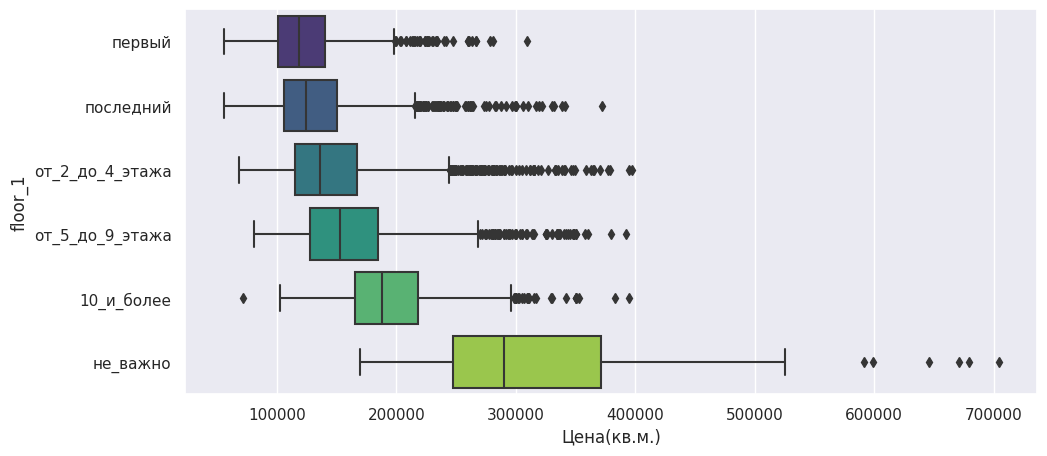

In [151]:
plt.figure(figsize = (11, 5))
sns.boxplot(data = df_floor_sort,
            x = df_floor_sort['unit_price'],
            y = df_floor_sort['floor_1'],
            palette = 'viridis'
            )
plt.xlabel('Цена(кв.м.)')
plt.show()

#### 7.9 Районы KMeans
Сгруппируем районы poly_district, разделив их на кластеры  

In [152]:
second_nn.columns

Index(['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
       'floor', 'floors_count', 'year_release', 'wall_type', 'last_edited',
       'repair_type', 'bti_year_built', 'lat', 'lng', 'geo_region',
       'geo_settlement', 'geo_city', 'geo_street', 'geo_house_num',
       'geo_microdistrict', 'geo_city_district', 'subway_name', 'subway_time',
       'subway_travel_type', 'description', 'days_after_edit', 'poly_okrug',
       'poly_district', 'bargainterms_price_ln', 'unit_price',
       'bargainterms_price_LN', 'unit_price_LN', 'nearest_metro',
       'distance_to_nearest_metro', 'lat_lng', 'distance_to_centre',
       'distance_to_centre_1', 'bargainterms_price_bins', 'is_elit',
       'housing_complex', 'floor_1'],
      dtype='object')

In [153]:
second_nn.poly_district.value_counts()

Старый_Нижний_Новгород                                        545
Светлоярский_5_7_мкр_Комсомольский_посёлок                    364
Высоково                                                      353
Соцгород                                                      349
Мещерское_Озеро                                               316
Новая_Стройка_Караваиха_Стройгаз_Суриковский_Дубенки_Цветы    304
Бурнаковский_Гордеевский                                      303
Стройплощадка_Северный                                        298
Александровская_слобода_Верхние_Печёры                        269
Щербинки                                                      254
Лапшиха_Нагорный                                              246
Печёрская_Долина                                              242
Лесной_Городок_Вторчермет_Сортировочный                       239
Сормова_Вождей_Революции_10_мкр_Дарьино                       229
Юг_Советского_района                                          229
Молитовски

Находим для каждого района медианную цену за 1 кв.м.  

In [154]:
second_nn['med_price'] = second_nn.groupby('poly_district')['unit_price'].transform('median').round()

In [155]:
X_clust = second_nn[['poly_district', 'med_price']].copy()
X_clust = X_clust.sort_values('med_price', ascending = False)
X_clust = X_clust.drop_duplicates(['poly_district']).reset_index().drop(columns = 'index') 
X_clust

poly_district  med_price
0                              Старый_Нижний_Новгород   223865.0
1                                    Печёрская_Долина   202658.0
2                            Север_Советского_района    200218.0
3                                            Высоково   194117.0
4                                   Каштановый_дворик   183788.0
5                                     Мещерское_Озеро   180412.0
6                               Юг_Советского_района    168943.0
7              Александровская_слобода_Верхние_Печёры   153846.0
8                                          Усиловский   150000.0
9   Новая_Стройка_Караваиха_Стройгаз_Суриковский_Д...   149296.0
10                           Бурнаковский_Гордеевский   145555.0
11                                          Кузнечиха   143390.0
12                                   Лапшиха_Нагорный   141086.0
13                           Комсомольский_Ленгородок   140271.0
14                                           Щербинки   139984.0
15                            Ярмарка_Старое_Канавино   137436.0
16                    Комсомольская_площадь_Молитовка   136000.0
17  Молитовский_Затон_Двигатель_Революции_Станкозавод   131578.0
18                            Юго_Западный_Юг_6_й_мкр   130563.0
19            Сормова_Вождей_Революции_10_мкр_Дарьино   129545.0
20                                           Соцгород   126005.0
21                    Мостоотряд_посёлок_Стахановский   125490.0
22                                 посёлок_Колхозный    124851.0
23                             Спортивный_Калининский   122503.0
24                           Красная_Этна_Ипподромный   121921.0
25                             Стройплощадка_Северный   121576.0
26                                Володарский_посёлок   121042.0
27                                       Мончегорский   120460.0
28                         Народная_Стройка_завод_ГАЗ   115820.0
29  Авиационный_квартал_Орджоникидзе_Кооперативный...   115730.0
30  Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_...   112903.0
31                        Володарского_Дачный_посёлок   112734.0
32                           Берёзовский_Красные_Зори   112727.0
33         Светлоярский_5_7_мкр_Комсомольский_посёлок   111668.0
34            Лесной_Городок_Вторчермет_Сортировочный   110375.0
35  Агрокомбинат_Горьковский_микрорайон_Новый_Наро...    98328.0

In [156]:
features = ['med_price']

In [157]:
current_label = 11

scaler = StandardScaler()  # Стандартизируем данные
scaled_features = scaler.fit_transform(X_clust[features])

kmeans = KMeans(n_clusters = current_label, random_state = 42)
kmeans.fit(scaled_features)   

X_clust['Kmeans_2'] = kmeans.labels_
X_clust

poly_district  med_price  Kmeans_2
0                              Старый_Нижний_Новгород   223865.0         6
1                                    Печёрская_Долина   202658.0         2
2                            Север_Советского_района    200218.0         2
3                                            Высоково   194117.0         2
4                                   Каштановый_дворик   183788.0         7
5                                     Мещерское_Озеро   180412.0         7
6                               Юг_Советского_района    168943.0         1
7              Александровская_слобода_Верхние_Печёры   153846.0        10
8                                          Усиловский   150000.0        10
9   Новая_Стройка_Караваиха_Стройгаз_Суриковский_Д...   149296.0        10
10                           Бурнаковский_Гордеевский   145555.0         3
11                                          Кузнечиха   143390.0         3
12                                   Лапшиха_Нагорный   141086.0         9
13                           Комсомольский_Ленгородок   140271.0         9
14                                           Щербинки   139984.0         9
15                            Ярмарка_Старое_Канавино   137436.0         9
16                    Комсомольская_площадь_Молитовка   136000.0         9
17  Молитовский_Затон_Двигатель_Революции_Станкозавод   131578.0         8
18                            Юго_Западный_Юг_6_й_мкр   130563.0         8
19            Сормова_Вождей_Революции_10_мкр_Дарьино   129545.0         8
20                                           Соцгород   126005.0         0
21                    Мостоотряд_посёлок_Стахановский   125490.0         0
22                                 посёлок_Колхозный    124851.0         0
23                             Спортивный_Калининский   122503.0         0
24                           Красная_Этна_Ипподромный   121921.0         0
25                             Стройплощадка_Северный   121576.0         0
26                                Володарский_посёлок   121042.0         0
27                                       Мончегорский   120460.0         0
28                         Народная_Стройка_завод_ГАЗ   115820.0         5
29  Авиационный_квартал_Орджоникидзе_Кооперативный...   115730.0         5
30  Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_...   112903.0         5
31                        Володарского_Дачный_посёлок   112734.0         5
32                           Берёзовский_Красные_Зори   112727.0         5
33         Светлоярский_5_7_мкр_Комсомольский_посёлок   111668.0         5
34            Лесной_Городок_Вторчермет_Сортировочный   110375.0         5
35  Агрокомбинат_Горьковский_микрорайон_Новый_Наро...    98328.0         4

In [158]:
# проставим метки так, чтобы они шли по убыванию от самого дорогого кластера
mapping = {}

for i, row in X_clust.iterrows():                                                    
    if row['Kmeans_2'] not in mapping:
        mapping[row['Kmeans_2']] = current_label
        current_label -= 1

X_clust['Kmeans_2'] = X_clust['Kmeans_2'].map(mapping)
X_clust = X_clust.sort_values('Kmeans_2', ascending = False) 
X_clust.reset_index(drop = True , inplace = True )
X_clust

poly_district  med_price  Kmeans_2
0                              Старый_Нижний_Новгород   223865.0        11
1                            Север_Советского_района    200218.0        10
2                                            Высоково   194117.0        10
3                                    Печёрская_Долина   202658.0        10
4                                   Каштановый_дворик   183788.0         9
5                                     Мещерское_Озеро   180412.0         9
6                               Юг_Советского_района    168943.0         8
7                                          Усиловский   150000.0         7
8   Новая_Стройка_Караваиха_Стройгаз_Суриковский_Д...   149296.0         7
9              Александровская_слобода_Верхние_Печёры   153846.0         7
10                           Бурнаковский_Гордеевский   145555.0         6
11                                          Кузнечиха   143390.0         6
12                                   Лапшиха_Нагорный   141086.0         5
13                           Комсомольский_Ленгородок   140271.0         5
14                                           Щербинки   139984.0         5
15                            Ярмарка_Старое_Канавино   137436.0         5
16                    Комсомольская_площадь_Молитовка   136000.0         5
17            Сормова_Вождей_Революции_10_мкр_Дарьино   129545.0         4
18                            Юго_Западный_Юг_6_й_мкр   130563.0         4
19  Молитовский_Затон_Двигатель_Революции_Станкозавод   131578.0         4
20                           Красная_Этна_Ипподромный   121921.0         3
21                                           Соцгород   126005.0         3
22                                Володарский_посёлок   121042.0         3
23                             Стройплощадка_Северный   121576.0         3
24                                       Мончегорский   120460.0         3
25                             Спортивный_Калининский   122503.0         3
26                                 посёлок_Колхозный    124851.0         3
27                    Мостоотряд_посёлок_Стахановский   125490.0         3
28                         Народная_Стройка_завод_ГАЗ   115820.0         2
29  Авиационный_квартал_Орджоникидзе_Кооперативный...   115730.0         2
30  Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_...   112903.0         2
31                        Володарского_Дачный_посёлок   112734.0         2
32                           Берёзовский_Красные_Зори   112727.0         2
33         Светлоярский_5_7_мкр_Комсомольский_посёлок   111668.0         2
34            Лесной_Городок_Вторчермет_Сортировочный   110375.0         2
35  Агрокомбинат_Горьковский_микрорайон_Новый_Наро...    98328.0         1

In [159]:
# выводим таблицу 
table_comp = X_clust.groupby('Kmeans_2')['med_price'].agg(['min', 'max'])
table_comp.columns = ['median_min', 'median_max']
table_comp['Прирост_med'] = table_comp['median_max'].pct_change() 
table_comp['poly_district'] = X_clust.groupby('Kmeans_2').apply(lambda x: list(x['poly_district']))
pd.set_option('display.max_colwidth', None)
table_comp

median_min  median_max  Прирост_med  \
Kmeans_2                                        
1            98328.0     98328.0          NaN   
2           110375.0    115820.0     0.177894   
3           120460.0    126005.0     0.087938   
4           129545.0    131578.0     0.044228   
5           136000.0    141086.0     0.072261   
6           143390.0    145555.0     0.031676   
7           149296.0    153846.0     0.056961   
8           168943.0    168943.0     0.098131   
9           180412.0    183788.0     0.087870   
10          194117.0    202658.0     0.102673   
11          223865.0    223865.0     0.104644   

                                                                                                                                                                                                                                                                                         poly_district  
Kmeans_2                                                                                                                                                                                                                                                                                                
1                                                                                                                                                                                                                                         [Агрокомбинат_Горьковский_микрорайон_Новый_Народный_посёлок]  
2         [Народная_Стройка_завод_ГАЗ, Авиационный_квартал_Орджоникидзе_Кооперативный_посёлок, Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_15_й_квартал, Володарского_Дачный_посёлок, Берёзовский_Красные_Зори, Светлоярский_5_7_мкр_Комсомольский_посёлок, Лесной_Городок_Вторчермет_Сортировочный]  
3                                                                                                                         [Красная_Этна_Ипподромный, Соцгород, Володарский_посёлок, Стройплощадка_Северный, Мончегорский, Спортивный_Калининский, посёлок_Колхозный , Мостоотряд_посёлок_Стахановский]  
4                                                                                                                                                                                [Сормова_Вождей_Революции_10_мкр_Дарьино, Юго_Западный_Юг_6_й_мкр, Молитовский_Затон_Двигатель_Революции_Станкозавод]  
5                                                                                                                                                                                     [Лапшиха_Нагорный, Комсомольский_Ленгородок, Щербинки, Ярмарка_Старое_Канавино, Комсомольская_площадь_Молитовка]  
6                                                                                                                                                                                                                                                                [Бурнаковский_Гордеевский, Кузнечиха]  
7                                                                                                                                                                                     [Усиловский, Новая_Стройка_Караваиха_Стройгаз_Суриковский_Дубенки_Цветы, Александровская_слобода_Верхние_Печёры]  
8                                                                                                                                                                                                                                                                              [Юг_Советского_района ]  
9                                                                                                                                                                                                                                                                 [Каштановый_дворик, Мещерское_Озеро]  
10                                                                                                       

In [160]:
# возвращаем нормальные настройки
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 50

После получения меток кластеров, нужно их проставить в наш df

In [ ]:
mapping = dict(zip(X_clust['poly_district'], X_clust['Kmeans_2']))  # Делаем словарь, который сопоставляет районы и Районы_Kmeans
second_nn['Районы_Kmeans'] = second_nn['poly_district'].apply(lambda x: mapping.get(x))  # добавляем столбец в df
second_nn.head(2)

In [162]:
second_nn['Районы_Kmeans'].value_counts(ascending=True)

1       76
8      229
9      462
6      463
11     545
4      638
7      692
10     769
5      920
2     1383
3     1498
Name: Районы_Kmeans, dtype: int64

# <font color='008B8B'> 8. Заполнение пропусков </font> 😱
<font color='brightred'> !!! По всем факторам, использующимся в модели, должны отсутствовать пропуски.  
Проверить наличие пропусков можно, например, с помощью функции df.info() !!! </font> 


In [163]:
second_nn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   cian_id                    7675 non-null   int64         
 1   url                        7675 non-null   object        
 2   bargainterms_price         7675 non-null   float64       
 3   area_total                 7675 non-null   float64       
 4   address                    7675 non-null   object        
 5   floor                      7675 non-null   float64       
 6   floors_count               7675 non-null   int64         
 7   year_release               5280 non-null   float64       
 8   wall_type                  7596 non-null   object        
 9   last_edited                7675 non-null   datetime64[ns]
 10  repair_type                7148 non-null   object        
 11  bti_year_built             1446 non-null   float64       
 12  lat   

#### 8.1 Заполняем пропуски по году ввода (year_release)

**Этап I**  
Год ввода пробуем восстановить по ключу lat_lng  
Создаем табличку с уникальными координатами и годом постройки

In [164]:
df_year_release = second_nn[['lat_lng', 'year_release']]
df_year_release = df_year_release.dropna()
df_year_release = df_year_release.drop_duplicates(subset = ['lat_lng'], ignore_index = True)
df_year_release.reset_index(drop = True , inplace = True )
df_year_release.head()

lat_lng  year_release
0   56.30257 44.0778        2009.0
1  56.31702 43.95014        1905.0
2  56.23016 43.86029        1973.0
3  56.30937 44.00477        2015.0
4  56.30296 43.97566        2020.0

Заполняем пропуски, создавая новый столбец year_release_2

In [ ]:
second_nn['year_release_2'] = second_nn['year_release'].copy()  
coor_dict = df_year_release.set_index('lat_lng')['year_release'].to_dict()  # создаем словарь

# заполняем пропуски в year_release_2
for index, row in second_nn[second_nn['year_release'].isnull()].iterrows():
    coordinates = row['lat_lng']
    if coordinates in coor_dict: 
        second_nn.loc[index, 'year_release_2'] = coor_dict[coordinates]
    else:
        second_nn.loc[index, 'year_release_2'] = 'нет_данных'
        
second_nn

In [ ]:
second_nn[second_nn['year_release_2'] == 'нет_данных']

Посмотрим, сколько уникальных адресов/координат имеют пропуски:

In [167]:
print(second_nn[second_nn['year_release_2'] == 'нет_данных']['address'].nunique())
print(second_nn[second_nn['year_release_2'] == 'нет_данных']['lat_lng'].nunique())

870
864


**Этап II**  
Восстанавливаем оставшиеся пропуски через KNNImputer

In [168]:
# возвращаем Nan вместо 'нет_данных'
second_nn['year_release_2'] = np.where(second_nn['year_release_2'] == 'нет_данных', np.nan, second_nn['year_release_2'])
second_nn['year_release_2'].unique()

array([2009.0, 1905.0, 1973.0, 2015.0, 2020.0, 1971.0, 1970.0, 1994.0,
       2007.0, 2021.0, 1960.0, 1939.0, 1937.0, 2011.0, nan, 1961.0,
       1966.0, 2022.0, 1986.0, 2019.0, 1965.0, 2016.0, 1980.0, 1982.0,
       1940.0, 2006.0, 1968.0, 2004.0, 1958.0, 1952.0, 2023.0, 2001.0,
       1983.0, 1962.0, 1949.0, 2013.0, 1959.0, 1985.0, 1963.0, 2012.0,
       1988.0, 1957.0, 2017.0, 1946.0, 1969.0, 1989.0, 2008.0, 1974.0,
       1929.0, 1990.0, 1979.0, 1991.0, 1964.0, 1992.0, 1967.0, 2005.0,
       1993.0, 1984.0, 1999.0, 2002.0, 1978.0, 1977.0, 1975.0, 2018.0,
       2024.0, 2010.0, 1997.0, 2000.0, 1972.0, 1981.0, 1941.0, 1976.0,
       1950.0, 2003.0, 1987.0, 1917.0, 1938.0, 2014.0, 1955.0, 1956.0,
       1995.0, 1996.0, 1896.0, 1998.0, 1947.0, 1931.0, 1916.0, 1934.0,
       1932.0, 1951.0, 1953.0, 1954.0, 1912.0, 1943.0, 1935.0, 1930.0,
       1948.0, 1936.0, 1813.0, 1900.0, 1942.0, 1822.0, 1842.0, 1933.0],
      dtype=object)

In [169]:
second_nn['year_release_2'] = second_nn['year_release_2'].astype(float)

In [170]:
from sklearn.impute import KNNImputer

In [171]:
X = second_nn[['unit_price', 'area_total', 'floors_count', 'lat', 'lng', 'year_release_2']]

In [172]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   unit_price      7675 non-null   float64
 1   area_total      7675 non-null   float64
 2   floors_count    7675 non-null   int64  
 3   lat             7675 non-null   float64
 4   lng             7675 non-null   float64
 5   year_release_2  6629 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 359.9 KB


In [173]:
imputer = KNNImputer(n_neighbors=3)
X_imp = imputer.fit_transform(X)

In [174]:
X_imp_2 = pd.DataFrame(X_imp, columns = X.columns)
X_imp_2

unit_price  area_total  floors_count       lat       lng  year_release_2
0       167883.0        82.2          10.0  56.30257  44.07780          2009.0
1        66000.0       250.0           3.0  56.31702  43.95014          1905.0
2       116483.0        45.5           5.0  56.23016  43.86029          1973.0
3       200000.0        98.0          17.0  56.30937  44.00477          2015.0
4       193625.0       125.5          17.0  56.30937  44.00477          2015.0
...          ...         ...           ...       ...       ...             ...
7670    126703.0        63.1          13.0  56.26037  43.85841          1987.0
7671    140845.0        28.4           9.0  56.31739  43.87716          1987.0
7672    117381.0        44.3           5.0  56.23016  43.86029          1973.0
7673    195833.0        24.0          17.0  56.21701  43.86342          2014.0
7674    145161.0        31.0           5.0  56.34446  43.86781          1964.0

[7675 rows x 6 columns]

In [175]:
X_imp_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   unit_price      7675 non-null   float64
 1   area_total      7675 non-null   float64
 2   floors_count    7675 non-null   float64
 3   lat             7675 non-null   float64
 4   lng             7675 non-null   float64
 5   year_release_2  7675 non-null   float64
dtypes: float64(6)
memory usage: 359.9 KB


In [176]:
X_imp_2['year_release_2'].unique()

array([2009.        , 1905.        , 1973.        , 2015.        ,
       2020.        , 1971.        , 1970.        , 1994.        ,
       2007.        , 2021.        , 1960.        , 1939.        ,
       1937.        , 2011.        , 1996.        , 1961.        ,
       1966.        , 1967.66666667, 2022.        , 1986.        ,
       1956.66666667, 2019.        , 1965.        , 2016.        ,
       1980.        , 1982.        , 1940.        , 2006.        ,
       1968.        , 1971.33333333, 2004.        , 1958.        ,
       1987.66666667, 1992.66666667, 1952.        , 2023.        ,
       2001.        , 1983.        , 1962.        , 1975.        ,
       1949.        , 2013.        , 1959.        , 1985.        ,
       1963.        , 1966.33333333, 2012.        , 1957.33333333,
       1988.        , 1957.        , 2017.        , 1976.66666667,
       1946.        , 1977.        , 1969.        , 1989.        ,
       2008.        , 1977.66666667, 1974.        , 1929.     

In [177]:
X_imp_2['year_release_2'] = X_imp_2['year_release_2'].astype(int)

In [178]:
second_nn['year_release_2'] = X_imp_2['year_release_2']

In [179]:
second_nn['year_release_2'].unique()

array([2009, 1905, 1973, 2015, 2020, 1971, 1970, 1994, 2007, 2021, 1960,
       1939, 1937, 2011, 1996, 1961, 1966, 1967, 2022, 1986, 1956, 2019,
       1965, 2016, 1980, 1982, 1940, 2006, 1968, 2004, 1958, 1987, 1992,
       1952, 2023, 2001, 1983, 1962, 1975, 1949, 2013, 1959, 1985, 1963,
       2012, 1957, 1988, 2017, 1976, 1946, 1977, 1969, 1989, 2008, 1974,
       1929, 1990, 1979, 1991, 1964, 2005, 1993, 1984, 1999, 2002, 1978,
       2018, 2024, 2010, 1997, 2000, 1972, 1981, 1941, 1950, 1995, 2003,
       1917, 1938, 2014, 1998, 1955, 1896, 1947, 1931, 1916, 1934, 1954,
       1932, 1951, 1953, 1912, 1943, 1935, 1930, 1948, 1936, 1813, 1900,
       1945, 1942, 1822, 1842, 1933])

Удалим столбец с первоначальным годом ввода в эксплуатацию

In [180]:
second_nn = second_nn.drop(columns=['year_release'])

In [ ]:
second_nn = second_nn.rename(columns={'year_release_2': 'year_release'})
second_nn.head(2)

#### 8.2 Заполняем пропуски по отделке (repair_type)

In [182]:
second_nn['repair_type'].isna().mean() # % пропусков

0.06866449511400652

In [183]:
second_nn['repair_type'].value_counts()

cosmetic    3920
no          1416
euro        1269
design       543
Name: repair_type, dtype: int64

Пропуски по отделке заполним наиболее часто встречающимся классом - **'cosmetic'**

In [184]:
second_nn['repair_type'] = np.where(second_nn['repair_type'].isna(), 'cosmetic', second_nn['repair_type'])
second_nn['repair_type'].value_counts()

cosmetic    4447
no          1416
euro        1269
design       543
Name: repair_type, dtype: int64

#### 8.3 Заполняем пропуски по метро (информация по Циан) + добавляем категорию по метро
Заполняем пропуски по ближайшей станции метро ‘subway_name’ и расстоянию до метро ‘subway_time’ (в минутах) и типу достижения станции метро ‘subway_travel_type’ по данным Cian.  
Пропуски восстанавливаем по ключу ‘lat_lng’, используя заполненные значения ближайшей станции метро в связке с расстоянием до метро и типом достижения станции метро у объектов с теми же координатами (по данным Cian).

In [185]:
second_nn.columns

Index(['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
       'floor', 'floors_count', 'wall_type', 'last_edited', 'repair_type',
       'bti_year_built', 'lat', 'lng', 'geo_region', 'geo_settlement',
       'geo_city', 'geo_street', 'geo_house_num', 'geo_microdistrict',
       'geo_city_district', 'subway_name', 'subway_time', 'subway_travel_type',
       'description', 'days_after_edit', 'poly_okrug', 'poly_district',
       'bargainterms_price_ln', 'unit_price', 'bargainterms_price_LN',
       'unit_price_LN', 'nearest_metro', 'distance_to_nearest_metro',
       'lat_lng', 'distance_to_centre', 'distance_to_centre_1',
       'bargainterms_price_bins', 'is_elit', 'housing_complex', 'floor_1',
       'med_price', 'Районы_Kmeans', 'year_release'],
      dtype='object')

In [186]:
print(second_nn.subway_name.isna().mean())
print(second_nn.subway_time.isna().mean())
print(second_nn.subway_travel_type.isna().mean())

0.13680781758957655
0.13680781758957655
0.13680781758957655


In [187]:
len(second_nn[second_nn.subway_time.isna()])

1050

**Этап I**  
Пробуем восстановить по ключу lat_lng  

In [188]:
df_metro = second_nn[['lat_lng', 'subway_name', 'subway_time', 'subway_travel_type']]
df_metro.head()

lat_lng    subway_name  subway_time subway_travel_type
0   56.30257 44.0778    Горьковская         10.0          transport
1  56.31702 43.95014     Московская          7.0               walk
2  56.23016 43.86029  Парк культуры         21.0               walk
3  56.30937 44.00477    Горьковская         12.0               walk
4  56.30937 44.00477    Горьковская         12.0               walk

In [189]:
df_metro = df_metro.dropna()
df_metro = df_metro.drop_duplicates(subset = ['lat_lng'], ignore_index = True)
df_metro.reset_index(drop = True , inplace = True )
df_metro

lat_lng    subway_name  subway_time subway_travel_type
0      56.30257 44.0778    Горьковская         10.0          transport
1     56.31702 43.95014     Московская          7.0               walk
2     56.23016 43.86029  Парк культуры         21.0               walk
3     56.30937 44.00477    Горьковская         12.0               walk
4     56.30296 43.97566    Горьковская         24.0               walk
...                 ...            ...          ...                ...
3372  56.22554 43.82861  Парк культуры          5.0          transport
3373  56.29525 44.06164    Горьковская         12.0          transport
3374  56.34231 43.92596        Стрелка         21.0               walk
3375  56.21701 43.86342  Парк культуры          7.0          transport
3376  56.34446 43.86781    Буревестник          4.0          transport

[3377 rows x 4 columns]

In [190]:
second_nn['subway_time_2'] = second_nn['subway_time'].copy()  
coor_dict = df_metro.set_index('lat_lng')['subway_time'].to_dict()  # создаем словарь

# заполняем пропуски в subway_time_2
for index, row in second_nn[second_nn['subway_time'].isnull()].iterrows():
    coordinates = row['lat_lng']
    if coordinates in coor_dict: 
        second_nn.loc[index, 'subway_time_2'] = coor_dict[coordinates]
    else:
        second_nn.loc[index, 'subway_time_2'] = 'нет_данных'

In [ ]:
second_nn[second_nn['subway_time_2'] == 'нет_данных']

**Восстановилось 73% пропусков** 

Так же восстанавливаем станцию метро и тип достижения станции

In [192]:
second_nn['subway_name_2'] = second_nn['subway_name'].copy()  
coor_dict = df_metro.set_index('lat_lng')['subway_name'].to_dict()  # создаем словарь

# заполняем пропуски в subway_name_2
for index, row in second_nn[second_nn['subway_name'].isnull()].iterrows():
    coordinates = row['lat_lng']
    if coordinates in coor_dict: 
        second_nn.loc[index, 'subway_name_2'] = coor_dict[coordinates]
    else:
        second_nn.loc[index, 'subway_name_2'] = 'нет_данных'

In [193]:
second_nn['subway_travel_type_2'] = second_nn['subway_travel_type'].copy()  
coor_dict = df_metro.set_index('lat_lng')['subway_travel_type'].to_dict()  # создаем словарь

# заполняем пропуски в subway_travel_type_2
for index, row in second_nn[second_nn['subway_travel_type'].isnull()].iterrows():
    coordinates = row['lat_lng']
    if coordinates in coor_dict: 
        second_nn.loc[index, 'subway_travel_type_2'] = coor_dict[coordinates]
    else:
        second_nn.loc[index, 'subway_travel_type_2'] = 'нет_данных'

In [194]:
print(len(second_nn[second_nn['subway_name_2'] == 'нет_данных']))
print(len(second_nn[second_nn['subway_travel_type_2'] == 'нет_данных']))

284
284


In [195]:
second_nn = second_nn.drop(columns=['subway_name', 'subway_time', 'subway_travel_type'])

In [ ]:
second_nn = second_nn.rename(columns={'subway_name_2': 'subway_name', 'subway_travel_type_2': 'subway_travel_type',
                                        'subway_time_2': 'subway_time'})
second_nn.head(2)

**Этап II**  
Для тех объектов, по которым информация по ключу ‘lat_lng’ не восстановилась:
-	в качестве ближайшей станции метро ‘subway_name’ метро указываем ранее самостоятельно определенную ближайшую станцию из столбца ‘nearest_metro’,  
-	время в минутах ‘subway_time’ определяем как рассчитанное по функции haversine расстояние до метро в километрах,
-	типу достижения станции метро ‘subway_travel_type’ указываем как ‘walk’.  

Расчет среднего и медианного времени затрачиваемого на 1 км приведен ниже:

Среднее: 13.403127992339611
Медиана: 13.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


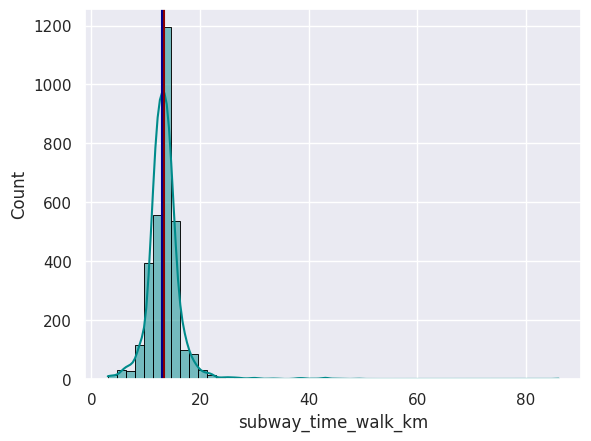

In [197]:
df_walk = second_nn[second_nn['subway_travel_type'] == 'walk']
df_walk['subway_time_walk_km'] = df_walk['subway_time'] // df_walk['distance_to_nearest_metro']

mean = df_walk['subway_time_walk_km'].mean()
median = df_walk['subway_time_walk_km'].median()

print('Среднее:', mean)
print('Медиана:', median)

sns.histplot(df_walk['subway_time_walk_km'],
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=50
            )

plt.axvline(mean, color = 'darkred')
plt.axvline(median, color = 'darkblue')

plt.show()

In [198]:
print(len(second_nn[second_nn['subway_name'] == 'нет_данных']))
print(len(second_nn[second_nn['subway_travel_type'] == 'нет_данных']))

284
284


Для восстановления subway_time будем использовать медианное время. 

In [199]:
second_nn['subway_name'] = np.where(second_nn['subway_name'] == 'нет_данных', second_nn['nearest_metro'], second_nn['subway_name'])
second_nn['subway_time'] = np.where(second_nn['subway_time'] == 'нет_данных', second_nn['distance_to_nearest_metro'] * 13.0, second_nn['subway_time'])
second_nn['subway_travel_type'] = np.where(second_nn['subway_travel_type'] == 'нет_данных', 'walk', second_nn['subway_travel_type'])

In [200]:
print(len(second_nn[second_nn['subway_name'] == 'нет_данных']))
print(len(second_nn[second_nn['subway_travel_type'] == 'нет_данных']))

0
0


**Этап III**  
Создаем категорию subway_time_1  
Создаем новый столбец ‘subway_time_1’с временем достижения ближайшей станции метро в виде категорий, определенный на основании столбцов ‘subway_time’ и ‘subway_travel_type’.   
Категории определяем на основании визуализации – строим график зависимости удельной цены объекта от времени до метро в минутах, предварительно отфильтровав  df  
- df для графика не должен содержать элитный сегмент – ‘is_elit’ == ‘нет’  
- должны быть также отфильтрованы объекты, до которых нет пешей доступности –  т.е. ‘subway_travel_type’ == ‘walk’ и ‘subway_time’ <= 30


In [201]:
second_nn.subway_travel_type.value_counts()

transport    4258
walk         3417
Name: subway_travel_type, dtype: int64

In [202]:
# отфильтруем df для построения графика
df_metro_cut = second_nn[(second_nn['is_elit'] == 'нет') & ((second_nn['subway_travel_type'] == 'walk') & (second_nn['subway_time'] <= 30))]

In [203]:
len(df_metro_cut)

3222

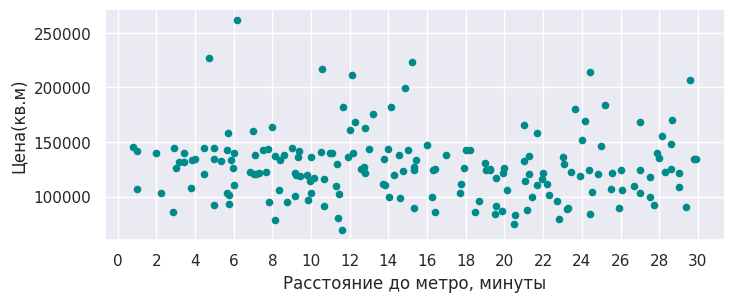

In [204]:
metro_cut = df_metro_cut.groupby('subway_time')['unit_price'].agg(['count','median'])
metro_cut = metro_cut.reset_index()

metro_cut.plot.scatter(x = 'subway_time', 
                       y = 'median', 
                       figsize = (8, 3),
                       color = 'darkcyan'
                       )

plt.xlabel('Расстояние до метро, минуты')
plt.ylabel('Цена(кв.м)')
plt.xticks(range(0, 31, 2))  # 0 - начало шкалы, 31 - конец, 1 - это шаг делений
plt.show()

**По графику не видим явной зависимости - возможно влияют еще другие факторы.**

In [205]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

def bining_dt(data, x, y, max_depth = 2, min_samples_leaf = 10, min_samples_split = 10, max_features = None, rotation = 0):
    '''
    x - фактор, который мы разбиваем на бины. Например, 'Этаж_1'.
    y - таргет, на который ориентируемся при разбиении x на бины (цена за 1 кв.м). Например, 'LN(Цена_кв.м)'.
    max_depth - глубина дерева (чем глубже дерево, тем больше бинов).
    min_samples_leaf - минимальный объем выборки, который должен быть в каждом листе после разбиения.
    min_samples_split - минимальный объем выборки, который должен быть в узле, чтобы этот узел мог быть разделен на 2.
    max_features - максимальное количество факторов, по которым ищется лучшее разбиение в дереве (при большом количестве факторов дорого искать лучшее решение). 
                   В нашем случае используются только 1 фактор, поэтому устанавливаем None (все факторы).
    rotation - поворот значений по оси Х (по умолчанию 0).
    '''
    df_bins = data.copy()
    
    DT = DecisionTreeRegressor(max_depth = max_depth,                                                                       # глубина дерева, см. описание выше
                               min_samples_leaf = min_samples_leaf,                                                         # см. описание выше
                               min_samples_split = min_samples_split,                                                       # см. описание выше
                               max_features = max_features,                                                                 # см. описание выше
                               random_state = 42                                                                            # см. описание выше
                              ) 
    DT.fit(df_bins[[x]], df_bins[y])                                                                                        # обучаем модель DT
 
    thresholds = []                                                                                                         # список границ бинов
    for i in range(DT.tree_.node_count):                                                                                    # перебираем все узлы в дереве
        if DT.tree_.children_left[i] != -1:                                                                                 # только узлы, где происходит разбиение (-1 в узле нет разбиения)
            thresholds.append(int(DT.tree_.threshold[i] + 0.5))                                                             # вытаскиваем пороги разбиения с учетом округления

    thresholds.sort()                                                                                                       # сортируем границы от мин до макс
    thresholds_list = [df_bins[x].min()] + list(thresholds) + [df_bins[x].max() + 1]                                        # список границ бинов
    thresholds_list = list(set(thresholds_list))                                                                            # удаляются дубликаты при их наличии
    thresholds_list.sort()

    bins = pd.cut(df_bins[x], bins = thresholds_list, right = False, include_lowest = True)                                 # делим фактор на бины
    
    df_bins['bins'] = bins
    variance_in_bins = np.sqrt(df_bins.groupby('bins')[y].var())                                                            # разброс внутри бина
    average_variance_in_bins = np.sqrt(df_bins.groupby('bins')[y].var()).mean()                                             # средний разброс по всем бинам
        
    plt.figure(figsize = (16, 10))
    
    plt.subplot(2, 2, 1)                                                                                                    # строка, столбец, индекс
    sns.boxplot(
                x = 'bins', 
                y = y, 
                data = df_bins,
                #color = 'grey',
                #ax = ax[1]
                )
    plt.xticks(rotation = rotation)

    plt.subplot(2, 2, 2)
    sns.lineplot(
                 df_bins.groupby(x)[y].median()       
                 #x = 'bins', 
                 #y = y, 
                 #data = data,
                 #color = 'grey',
                 #ax = ax[1]
                 )
    sns.lineplot(
                 df_bins.groupby(x)[y].mean()       
                 #x = 'bins', 
                 #y = y, 
                 #data = data,
                 #color = 'grey',
                 #ax = ax[1]
                 )
    
    plt.subplot(2, 1, 2)
    plot_tree(DT, feature_names = [x], filled = True, rounded = True)
    
    plt.show()
    
    return bins, variance_in_bins, average_variance_in_bins

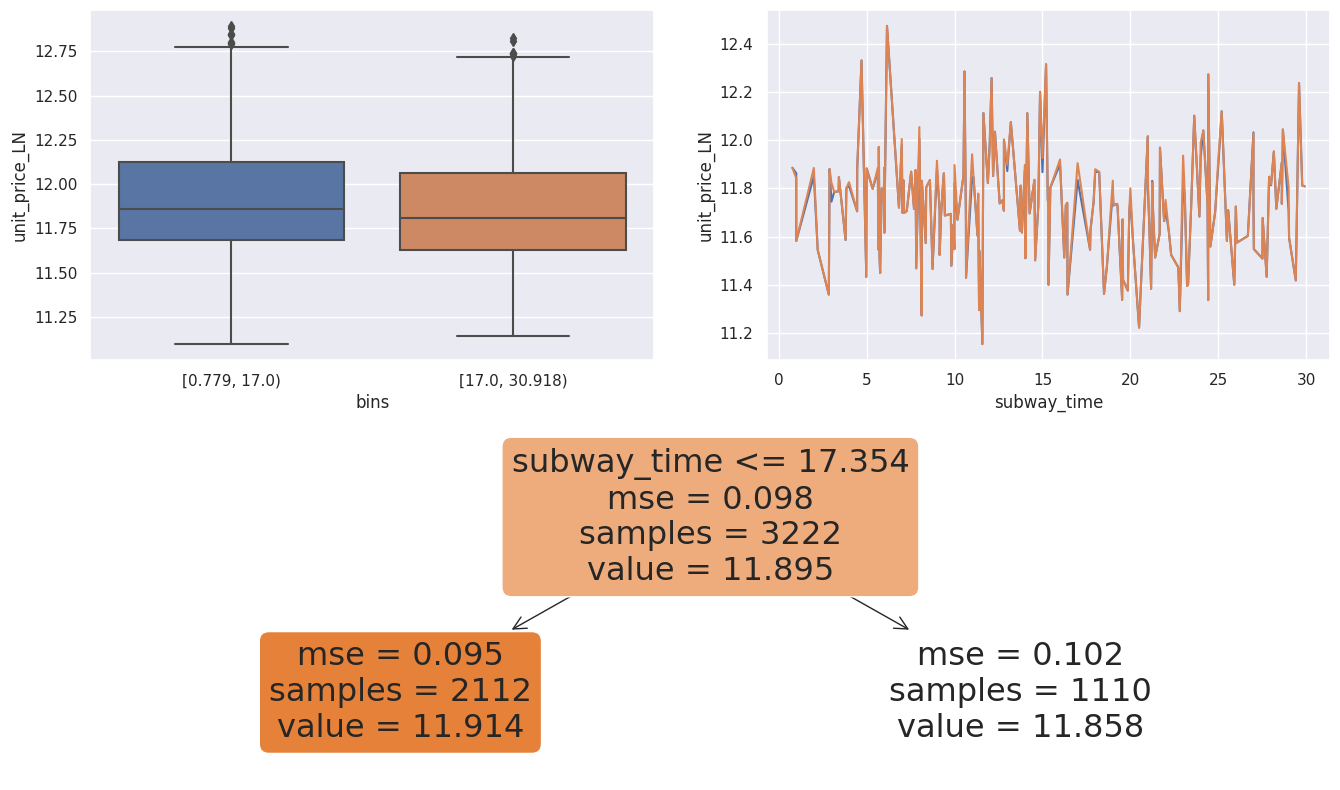

In [206]:
bins, variance_in_bins, average_variance_in_bins = bining_dt(data = df_metro_cut, 
                                                             x = 'subway_time', 
                                                             y = 'unit_price_LN',
                                                             max_depth = 1, 
                                                             min_samples_leaf = 1000, 
                                                             min_samples_split = 1000
                                                            )

В рамках логиги делим на 2 бина до_10_минут_пешком и больше_10_минут_пешком.

In [207]:
# разбиваем на бины
m_labels = ['до_10_минут_пешком', 'больше_10_минут_пешком']  
m_bins = [-1, 10, 1000]
second_nn['subway_time_1'] = pd.cut(second_nn['subway_time'], bins = m_bins, labels = m_labels)

In [208]:
second_nn['subway_time_1'].value_counts()

до_10_минут_пешком        4434
больше_10_минут_пешком    3241
Name: subway_time_1, dtype: int64

In [209]:
second_nn['subway_time_1'].isna().mean()

0.0

Теперь там, где subway_time > 30 минут **или** subway_travel_type = 'transport', мы проставляем значение 'нет_пешей_доступности'

In [210]:
second_nn['subway_time_1'] = np.where((second_nn['subway_time'] > 30) | (second_nn['subway_travel_type'] == 'transport'),
                                       'нет_пешей_доступности', second_nn['subway_time_1'])

**В последнюю очередь** для элитных объектов проставляем категорию 'неважно'

In [211]:
second_nn['subway_time_1'] = np.where(second_nn['is_elit'] != 'нет', 'неважно', second_nn['subway_time_1'])

In [212]:
second_nn['subway_time_1'].value_counts()

нет_пешей_доступности     4300
больше_10_минут_пешком    2150
до_10_минут_пешком        1072
неважно                    153
Name: subway_time_1, dtype: int64

Построим боксплоты по новой категории

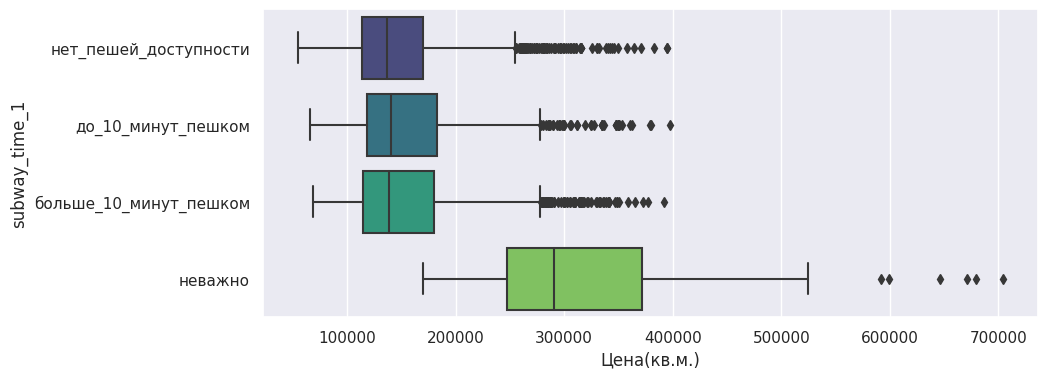

In [213]:
plt.figure(figsize = (10, 4))
sns.boxplot(data = second_nn,
            x = second_nn['unit_price'],
            y = second_nn['subway_time_1'],
            palette = 'viridis'
            )
plt.xlabel('Цена(кв.м.)')
plt.show()

# <font color='008B8B'> 9. Объем рынка </font> 💰
После всей предобработки df последний этап – это определение объема рынка по каждой из категорий площади ‘area_total_1’.   
Значения в данном столбце определяется как количество объектов в выборке, относящихся к каждой категории площади.  

**Перед тем, как принять в модель фактор "объема рынка", необходимо проанализировать зависимость цен от объема рынка.**

In [218]:
medians_ = second_nn.groupby('area_total_1')['unit_price'].agg('median')
counts_ = second_nn.groupby('area_total_1')['unit_price'].agg('count')
medians_ = pd.DataFrame(medians_)
counts_ = pd.DataFrame(counts_)
medians_.reset_index(inplace = True)
counts_.reset_index(inplace = True)
medians_['counts'] = counts_['unit_price']
medians_ 

area_total_1  unit_price  counts
0         до_28    162162.0     393
1   от_28_до_42    141274.0    2041
2   от_42_до_65    128630.0    3643
3   от_65_до_85    155882.0     975
4  от_85_до_105    177257.0     351
5     более_105    215232.0     272

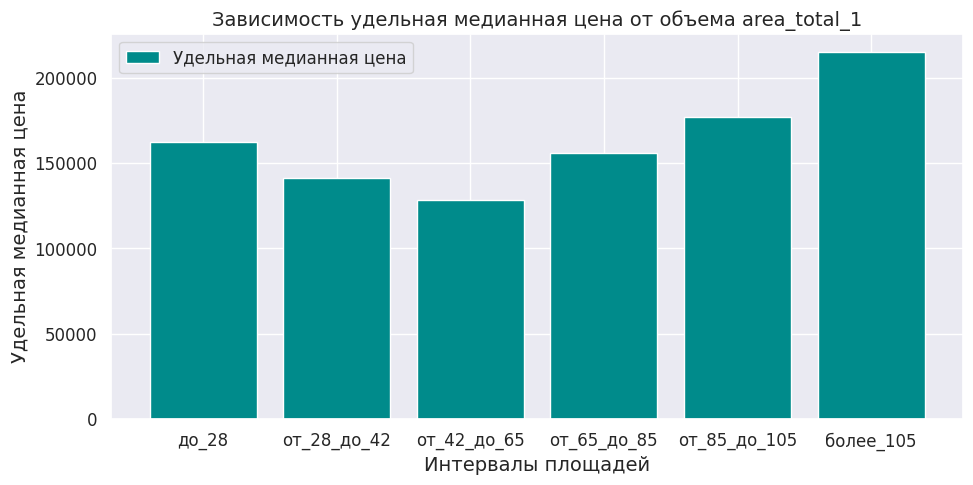

In [219]:
plt.figure(figsize = (11, 5))
ax = plt.subplot(111)

ax.bar(
       medians_['area_total_1'], 
       medians_['unit_price'], 
       label = 'Удельная медианная цена', 
       #width = 0.35,
       color = 'darkcyan'
      )


# for i in range(len(medians_msk['medians'])):
#     plt.text(i - 0.03, medians_['unit_price'][i] - 160000, f'{medians_["unit_price"][i]:,.0f}', ha = 'right', va = 'bottom', fontsize = 12, rotation = 90)

ax.set_xlabel('Интервалы площадей', fontsize = 14)
ax.set_ylabel('Удельная медианная цена', fontsize = 14)
ax.set_title('Зависимость удельная медианная цена от объема area_total_1', fontsize = 14)

#plt.xticks(rotation = 90, fontsize = 7)
#ax.set_ylim((0, 850000))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

ax.legend(fontsize = 12)

plt.show();

На графике видно, что по мере увеличения площади сначала удельная медианная цена снижается, а начиная с 65 кв.м растет.  
Обращаю внимание, что квариры до 28 кв.м имеют высокую удельную цену, так как влияет эффект масштаба. Квартиры площадью от 105 кв.м и более также имеют высокую удельную цену, так как частично влияние оказывает элитный сегмент, что доказывает таблица ниже (доля элитных квартир в "более_105" составляет 15.8%).

In [220]:
for i in second_nn['area_total_1'].unique():
    area_ = second_nn[second_nn['area_total_1'] == i]
    d = len(area_[area_["is_elit"] != "нет"]) / len(area_)
    print(f'{i}: {round(d, 3)}')

от_65_до_85: 0.043
более_105: 0.158
от_42_до_65: 0.007
от_85_до_105: 0.071
от_28_до_42: 0.008
до_28: 0.0


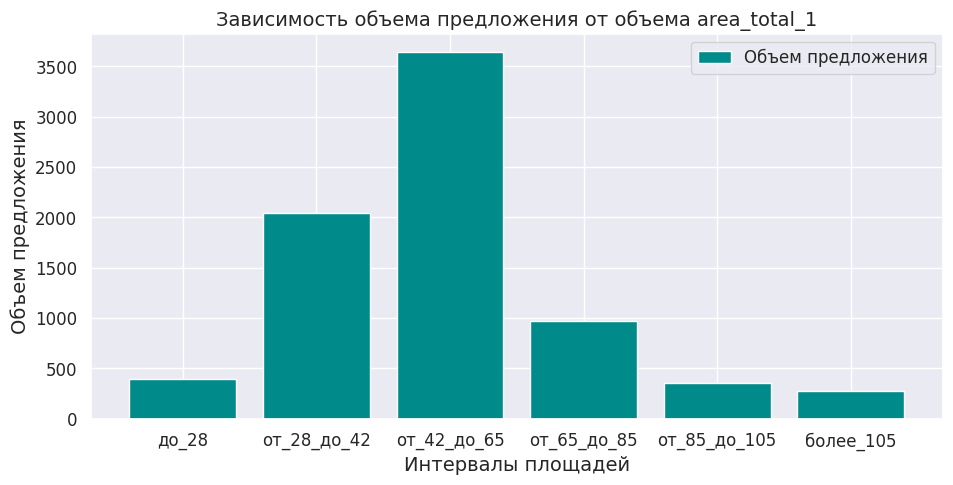

In [221]:
plt.figure(figsize = (11, 5))
ax = plt.subplot(111)

ax.bar(
       medians_['area_total_1'], 
       medians_['counts'], 
       label = 'Объем предложения', 
       #width = 0.35,
       color = 'darkcyan'
      )


# for i in range(len(medians_msk['medians'])):
#     plt.text(i - 0.03, medians_['unit_price'][i] - 160000, f'{medians_["unit_price"][i]:,.0f}', ha = 'right', va = 'bottom', fontsize = 12, rotation = 90)

ax.set_xlabel('Интервалы площадей', fontsize = 14)
ax.set_ylabel('Объем предложения', fontsize = 14)
ax.set_title('Зависимость объема предложения от объема area_total_1', fontsize = 14)

#plt.xticks(rotation = 90, fontsize = 7)
#ax.set_ylim((0, 850000))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

ax.legend(fontsize = 12)

plt.show();

По графикам выше видно, что удельная цена повышается для интервалов от 65 кв.м до 105 кв.м, при этом объем предложения таких квартир на рынке существенно мал относительно квартир площадью от 28 кв.м до 65 кв.м.  
Таким образом, учитываем данный фактор в модели.

In [222]:
second_nn['area_total_1'].value_counts()

от_42_до_65     3643
от_28_до_42     2041
от_65_до_85      975
до_28            393
от_85_до_105     351
более_105        272
Name: area_total_1, dtype: int64

In [223]:
second_nn['Объем_рынка'] = second_nn.groupby('area_total_1')['area_total_1'].transform('count')

In [224]:
second_nn['Объем_рынка'].value_counts()

3643    3643
2041    2041
975      975
393      393
351      351
272      272
Name: Объем_рынка, dtype: int64

# <font color='008B8B'> 10. PHIK </font> 🌞
После предобработки данных строим матрицу корреляции  
Проверяем обработанный df

In [225]:
second_nn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   cian_id                    7675 non-null   int64         
 1   url                        7675 non-null   object        
 2   bargainterms_price         7675 non-null   float64       
 3   area_total                 7675 non-null   float64       
 4   address                    7675 non-null   object        
 5   floor                      7675 non-null   float64       
 6   floors_count               7675 non-null   int64         
 7   wall_type                  7596 non-null   object        
 8   last_edited                7675 non-null   datetime64[ns]
 9   repair_type                7675 non-null   object        
 10  bti_year_built             1446 non-null   float64       
 11  lat                        7675 non-null   float64       
 12  lng   

In [226]:
second_nn.columns

Index(['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
       'floor', 'floors_count', 'wall_type', 'last_edited', 'repair_type',
       'bti_year_built', 'lat', 'lng', 'geo_region', 'geo_settlement',
       'geo_city', 'geo_street', 'geo_house_num', 'geo_microdistrict',
       'geo_city_district', 'description', 'days_after_edit', 'poly_okrug',
       'poly_district', 'bargainterms_price_ln', 'unit_price',
       'bargainterms_price_LN', 'unit_price_LN', 'nearest_metro',
       'distance_to_nearest_metro', 'lat_lng', 'distance_to_centre',
       'distance_to_centre_1', 'bargainterms_price_bins', 'is_elit',
       'housing_complex', 'floor_1', 'med_price', 'Районы_Kmeans',
       'year_release', 'subway_time', 'subway_name', 'subway_travel_type',
       'subway_time_1', 'area_total_1', 'Объем_рынка'],
      dtype='object')

In [227]:
X = second_nn[[
                'bargainterms_price_LN', 
                'unit_price_LN', 
                'area_total',
                'floor', 
                'floor_1', 
                'floors_count',
                'is_elit', 
                'poly_okrug',
                'poly_district',
                'Районы_Kmeans',
                'lat',
                'lng',
                'distance_to_nearest_metro',
                'subway_time_1', 
                'distance_to_centre', 
                'distance_to_centre_1', 
                'repair_type',
                'year_release',
                'Объем_рынка'
              ]]

In [228]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bargainterms_price_LN      7675 non-null   float64 
 1   unit_price_LN              7675 non-null   float64 
 2   area_total                 7675 non-null   float64 
 3   floor                      7675 non-null   float64 
 4   floor_1                    7675 non-null   object  
 5   floors_count               7675 non-null   int64   
 6   is_elit                    7675 non-null   object  
 7   poly_okrug                 7675 non-null   object  
 8   poly_district              7675 non-null   object  
 9   Районы_Kmeans              7675 non-null   int64   
 10  lat                        7675 non-null   float64 
 11  lng                        7675 non-null   float64 
 12  distance_to_nearest_metro  7675 non-null   object  
 13  subway_time_1              7675 n

**!Важно:** проверяем тип данных

Районы_Kmeans преобразовываем в категорию (т.к. это метка)  

Также я меняю тип данных на ***float*** у distance_to_nearest_metro и distance_to_centre

In [229]:
X['Районы_Kmeans'] = X['Районы_Kmeans'].astype(str)
X['distance_to_nearest_metro'] = X['distance_to_nearest_metro'].astype(float)
X['distance_to_centre'] = X['distance_to_centre'].astype(float)
X['floor'] = X['floor'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [230]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bargainterms_price_LN      7675 non-null   float64 
 1   unit_price_LN              7675 non-null   float64 
 2   area_total                 7675 non-null   float64 
 3   floor                      7675 non-null   int64   
 4   floor_1                    7675 non-null   object  
 5   floors_count               7675 non-null   int64   
 6   is_elit                    7675 non-null   object  
 7   poly_okrug                 7675 non-null   object  
 8   poly_district              7675 non-null   object  
 9   Районы_Kmeans              7675 non-null   object  
 10  lat                        7675 non-null   float64 
 11  lng                        7675 non-null   float64 
 12  distance_to_nearest_metro  7675 non-null   float64 
 13  subway_time_1              7675 n

In [838]:
# X.to_csv('!Выборка_Казань_2025_second.csv') # сохраняем готовую выборку

Импортируеи библиотеки и строим матрицу корреляции  

interval columns not set, guessing: ['bargainterms_price_LN', 'unit_price_LN', 'area_total', 'floor', 'floors_count', 'lat', 'lng', 'distance_to_nearest_metro', 'distance_to_centre', 'year_release', 'Объем_рынка']


<AxesSubplot:>

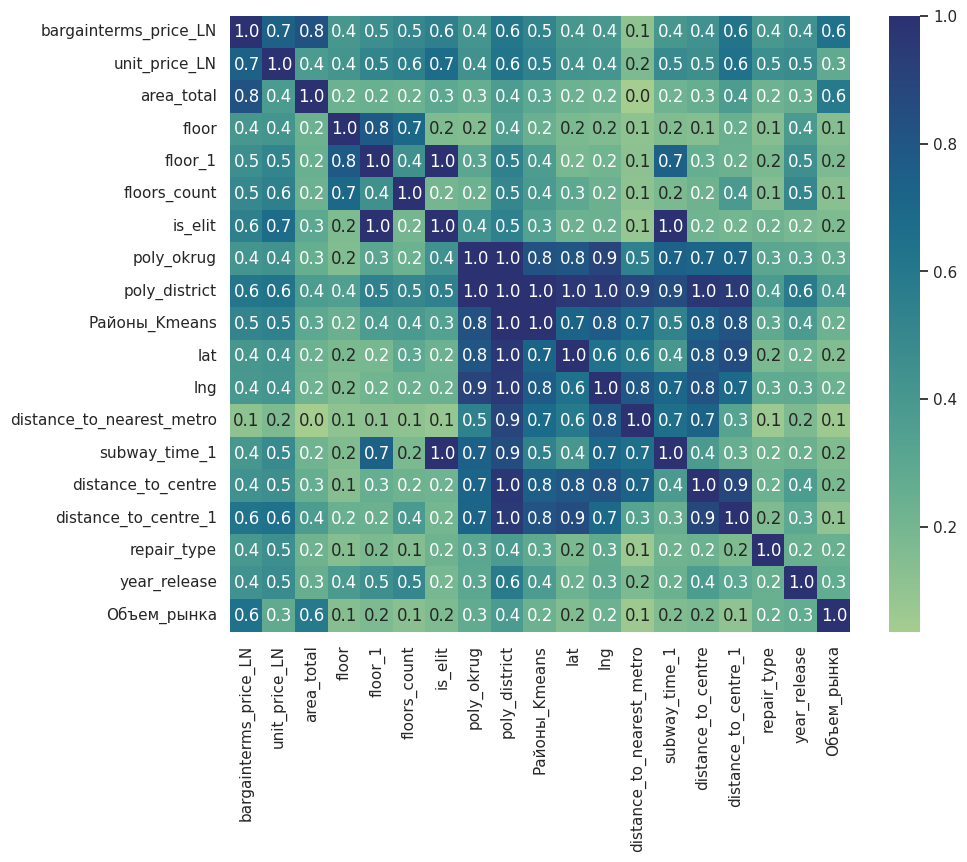

In [231]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = X.phik_matrix()

plt.figure(figsize = (10, 8))
sns.heatmap(phik_overview, 
            annot = True,
            fmt = '.1f',
            cmap = 'crest'
            )

# <font color='008B8B'> 11. Работа с выбросами </font> 🚮
В виду большого количества объектов, выбросы (аномальные объекты) определяем на основании 7 алгоритмов:
- IsolationForest,
- OneClassSVM,
- LocalOutlierFactor,
- COPOD,
- PCA,
- out_iqr – алгоритм iqr, определяющий выбросы по цене,
- out_iqr_kv – алгоритм iqr, определяющий выбросы по удельной цене.

Для поиска выбросов, используем следующие факторы:

In [232]:
X_fac = second_nn[[
                    'bargainterms_price_LN', 
                    #'unit_price_LN', 
                    'area_total',
                    #'floor', 
                    'floor_1', 
                    'floors_count',
                    'is_elit', 
                    #'poly_okrug',
                    #'poly_district',
                    #'Районы_Kmeans',
                    'lat',
                    'lng',
                    #'distance_to_nearest_metro',
                    'subway_time_1', 
                    #'distance_to_centre', 
                    'distance_to_centre_1', 
                    'repair_type',
                    'year_release',
                    'Объем_рынка'
                  ]]

In [706]:
#X_fac['Районы_Kmeans'] = X_fac['Районы_Kmeans'].astype('str')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [233]:
X_fac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   bargainterms_price_LN  7675 non-null   float64 
 1   area_total             7675 non-null   float64 
 2   floor_1                7675 non-null   object  
 3   floors_count           7675 non-null   int64   
 4   is_elit                7675 non-null   object  
 5   lat                    7675 non-null   float64 
 6   lng                    7675 non-null   float64 
 7   subway_time_1          7675 non-null   object  
 8   distance_to_centre_1   7675 non-null   category
 9   repair_type            7675 non-null   object  
 10  year_release           7675 non-null   int64   
 11  Объем_рынка            7675 non-null   int64   
dtypes: category(1), float64(4), int64(3), object(4)
memory usage: 667.4+ KB


#### 11.1 Преобразование категориальных переменных в числовые

Все категориальные факторы необходимо преобразовать в числовые значения при помощи OneHotEncoder и LabelEncoder

In [234]:
# для столбцов более чем с 2 категориями
enc = OneHotEncoder(handle_unknown = 'ignore')
enc_df = pd.DataFrame(enc.fit_transform(X_fac[['floor_1', 'subway_time_1', 'distance_to_centre_1', 'repair_type']]).toarray())

enc_df.columns = enc.get_feature_names() #см ниже
X_fac = X_fac.join(enc_df)

In [235]:
# для столбцов с 2 категориями
encoder = LabelEncoder()

X_fac['is_elit_enc'] = encoder.fit_transform(X_fac[['is_elit']])
X_fac

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


bargainterms_price_LN  area_total          floor_1  floors_count  \
0                 16.440179        82.2  от_5_до_9_этажа            10   
1                 16.618871       250.0           первый             3   
2                 15.483217        45.5        последний             5   
3                 16.791040        98.0  от_2_до_4_этажа            17   
4                 17.005987       125.5  от_2_до_4_этажа            17   
...                     ...         ...              ...           ...   
7670              15.894327        63.1  от_5_до_9_этажа            13   
7671              15.201805        28.4  от_5_до_9_этажа             9   
7672              15.464169        44.3        последний             5   
7673              15.363073        24.0  от_5_до_9_этажа            17   
7674              15.319588        31.0        последний             5   

     is_elit       lat       lng           subway_time_1 distance_to_centre_1  \
0        нет  56.30257  44.07780   нет_пешей_доступности         от_5_до_7_км   
1        нет  56.31702  43.95014      до_10_минут_пешком         от_2_до_5_км   
2        нет  56.23016  43.86029  больше_10_минут_пешком              от_8_км   
3        нет  56.30937  44.00477  больше_10_минут_пешком         от_2_до_5_км   
4        нет  56.30937  44.00477  больше_10_минут_пешком         от_2_до_5_км   
...      ...       ...       ...                     ...                  ...   
7670     нет  56.26037  43.85841   нет_пешей_доступности              от_8_км   
7671     нет  56.31739  43.87716   нет_пешей_доступности         от_7_до_8_км   
7672     нет  56.23016  43.86029  больше_10_минут_пешком              от_8_км   
7673     нет  56.21701  43.86342   нет_пешей_доступности              от_8_км   
7674     нет  56.34446  43.86781   нет_пешей_доступности              от_8_км   

     repair_type  year_release  Объем_рынка  x0_10_и_более  x0_не_важно  \
0       cosmetic          2009          975            0.0          0.0   
1       cosmetic          1905          272            0.0          0.0   
2       cosmetic          1973         3643            0.0          0.0   
3         design          2015          351            0.0          0.0   
4           euro          2015          272            0.0          0.0   
...          ...           ...          ...            ...          ...   
7670    cosmetic          1987         3643            0.0          0.0   
7671    cosmetic          1987         2041            0.0          0.0   
7672    cosmetic          1973         3643            0.0          0.0   
7673        euro          2014          393            0.0          0.0   
7674    cosmetic          1964         2041            0.0          0.0   

      x0_от_2_до_4_этажа  x0_от_5_до_9_этажа  x0_первый  x0_последний  \
0                    0.0                 1.0        0.0           0.0   
1                    0.0                 0.0        1.0           0.0   
2                    0.0                 0.0        0.0           1.0   
3                    1.0                 0.0        0.0           0.0   
4                    1.0                 0.0        0.0           0.0   
...                  ...                 ...        ...           ...   
7670                 0.0                 1.0        0.0           0.0   
7671                 0.0                 1.0        0.0           0.0   
7672                 0.0                 0.0        0.0           1.0   
7673                 0.0                 1.0        0.0           0.0   
7674                 0.0                 0.0        0.0           1.0   

      x1_больше_10_минут_пешком  x1_до_10_минут_пешком  x1_неважно  \
0                           0.0                    0.0         0.0   
1                           0.0                    1.0         0.0   
2                           1.0                    0.0         0.0   
3                           1.0                    0.0         0.0   
4               

In [236]:
list(X_fac.columns)

['bargainterms_price_LN',
 'area_total',
 'floor_1',
 'floors_count',
 'is_elit',
 'lat',
 'lng',
 'subway_time_1',
 'distance_to_centre_1',
 'repair_type',
 'year_release',
 'Объем_рынка',
 'x0_10_и_более',
 'x0_не_важно',
 'x0_от_2_до_4_этажа',
 'x0_от_5_до_9_этажа',
 'x0_первый',
 'x0_последний',
 'x1_больше_10_минут_пешком',
 'x1_до_10_минут_пешком',
 'x1_неважно',
 'x1_нет_пешей_доступности',
 'x2_до_2_км ',
 'x2_от_2_до_5_км',
 'x2_от_5_до_7_км',
 'x2_от_7_до_8_км',
 'x2_от_8_км',
 'x3_cosmetic',
 'x3_design',
 'x3_euro',
 'x3_no',
 'is_elit_enc']

Собираем все исходные числовые факторы и преобразованные в число с помощью OneHotEncoder и LabelEncoder факторы в df  

In [241]:
X_fac_num = X_fac[[
                     'bargainterms_price_LN',
                     'area_total',
                     #'floor_1',
                     'floors_count',
                     #'is_elit',
                     'lat',
                     'lng',
                     #'subway_time_1',
                     #'distance_to_centre_1',
                     #'repair_type',
                     'year_release',
                     'Объем_рынка',
                     'x0_10_и_более',
                     'x0_не_важно',
                     'x0_от_2_до_4_этажа',
                     'x0_от_5_до_9_этажа',
                     'x0_первый',
                     'x0_последний',
                     'x1_больше_10_минут_пешком',
                     'x1_до_10_минут_пешком',
                     'x1_неважно',
                     'x1_нет_пешей_доступности',
                     'x2_до_2_км ',
                     'x2_от_2_до_5_км',
                     'x2_от_5_до_7_км',
                     'x2_от_7_до_8_км',
                     'x2_от_8_км',
                     'x3_cosmetic',
                     'x3_design',
                     'x3_euro',
                     'x3_no',
                     'is_elit_enc'
]]

In [242]:
# проверяем, что все факторы числовые! Все ОК
X_fac_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bargainterms_price_LN      7675 non-null   float64
 1   area_total                 7675 non-null   float64
 2   floors_count               7675 non-null   int64  
 3   lat                        7675 non-null   float64
 4   lng                        7675 non-null   float64
 5   year_release               7675 non-null   int64  
 6   Объем_рынка                7675 non-null   int64  
 7   x0_10_и_более              7675 non-null   float64
 8   x0_не_важно                7675 non-null   float64
 9   x0_от_2_до_4_этажа         7675 non-null   float64
 10  x0_от_5_до_9_этажа         7675 non-null   float64
 11  x0_первый                  7675 non-null   float64
 12  x0_последний               7675 non-null   float64
 13  x1_больше_10_минут_пешком  7675 non-null   float

#### 11.2 Стандартизируем данные
Наши числовые данные нужно привести в один масштаб  
Для этого используем StandardScaler

In [243]:
scaler = StandardScaler()

X_fac_num_scaler = scaler.fit_transform(X_fac_num)
X_fac_num_scaler

array([[ 1.21009268,  1.13218122,  0.13569885, ..., -0.44507925,
        -0.47564085, -0.14261955],
       [ 1.54092516,  7.85370429, -1.15669975, ..., -0.44507925,
        -0.47564085, -0.14261955],
       [-0.56163975, -0.33790159, -0.78744301, ..., -0.44507925,
        -0.47564085, -0.14261955],
       ...,
       [-0.59690585, -0.3859697 , -0.78744301, ..., -0.44507925,
        -0.47564085, -0.14261955],
       [-0.78407661, -1.19912177,  1.42809744, ...,  2.2467909 ,
        -0.47564085, -0.14261955],
       [-0.86458556, -0.9187245 , -0.78744301, ..., -0.44507925,
        -0.47564085, -0.14261955]])

Также построим график PCA (но использовать не будем...)

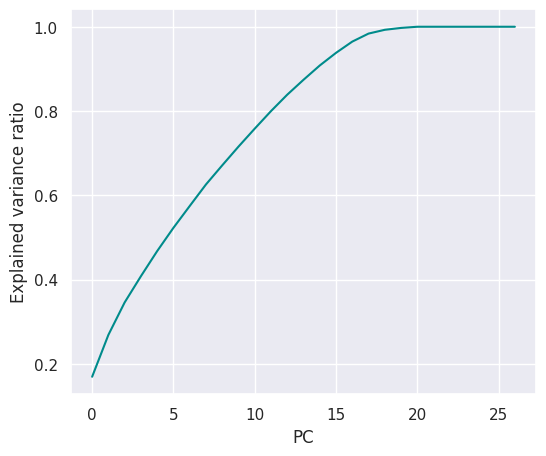

In [244]:
from sklearn.decomposition import PCA, _pca

pca = PCA(n_components = X_fac_num.shape[1])
dataf_scaler_pca = pca.fit(X_fac_num_scaler)
cum_sum = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize = (6, 5))
plt.plot(range(0, len(cum_sum)), 
         cum_sum,
         color = '#008B8B'
        )
plt.ylabel('Explained variance ratio')
plt.xlabel('PC')
plt.show()

#### 11.3 Применяем алгоритмы поиска выбросов

После применения каждого из алгоритмов, результат мы записываем в df в новые столбцы ‘IsolationForest’, ‘OneClassSVM’, ‘LOF’, ‘COPOD’, ‘PCA’,  
‘Manual_autoencoder’, ‘out_iqr’, ‘out_iqr_kv’, где 0 – это признак не выброса, 1 – признак выброса объекта по каждому из алгоритмов. 

In [245]:
iso = IsolationForest(n_estimators = 100, contamination = 0.1)
y_outliers = iso.fit_predict(X_fac_num_scaler)

# scores_pred = iso.decision_function(X)
# scores_pred

y_outliers[y_outliers == 1] = 0
y_outliers[y_outliers == -1] = 1

second_nn['IsolationForest'] = y_outliers

In [246]:
svm = OneClassSVM(kernel = 'rbf', gamma = 'scale', nu = 0.5)
svm.fit(X_fac_num_scaler)

pred = svm.predict(X_fac_num_scaler)

pred[pred == 1] = 0
pred[pred == -1] = 1

second_nn['OneClassSVM'] = pred

In [247]:
lof = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)

y_pred = lof.fit_predict(X_fac_num_scaler)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

second_nn['LOF'] = y_pred

In [248]:
copd = COPOD(contamination = 0.1)

copd.fit(X_fac_num_scaler)
#scores_pred = copd.decision_function(X)
y_pred_out = copd.predict(X_fac_num_scaler)

second_nn['COPOD'] = y_pred_out

In [249]:
from pyod.models.pca import PCA

pca = PCA(contamination = 0.1, 
          copy = True, 
          iterated_power = 'auto', 
          n_components = None,
          n_selected_components = None, 
          standardization = True, 
          svd_solver = 'auto', 
          tol = 0.0, 
          weighted = True,
          whiten = False)

pca.fit(X_fac_num_scaler)
#scores_pred = pca.decision_function(X)
y_pred_out = pca.predict(X_fac_num_scaler)

second_nn['PCA'] = y_pred_out

In [250]:
def finding_outlier(data, cat_col, price_col, method = 'iqr', multiplier = 1.5, log = True):
    '''
    data: DataFrame с данными.
    cat_col (str): Столбец с категориальным фактором, например, район города.
    price_col (str): Название столбца с ценами (руб. или кв.м/руб.).
    method (str, optional): Метод определения выбросов ('iqr' или 'zmod'). По умолчанию 'iqr'.
    multiplier (float, optional): Множитель для IQR или Z-оценки. По умолчанию 1.5 для IQR, для Z-оценки рассматривают порог 3.5.
                                  1.5 = 3 СКО, 1.75 * IQR = Zmod.
    log (bool, optional): Отвечает за логорифмирование цены (True), False - нет. По умолчанию 'True'.
    '''
    df_clean = data.copy()
    
    index_out = []

    for cat in df_clean[cat_col].unique():
        cat_data = df_clean[df_clean[cat_col] == cat]
        
        if log == True:
            cat_data[f'{price_col}_ln'] = np.log(cat_data[price_col])
            prices = cat_data[f'{price_col}_ln']
        else:
            prices = cat_data[price_col]

        if method == 'iqr':
            # Метод межквартильного размаха (IQR)
            Q1 = prices.quantile(0.25)
            Q3 = prices.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            # Индексы выбросов
            indexs = list(cat_data[(prices < lower_bound) | (prices > upper_bound)].index)
    
            if indexs != []:
                index_out.extend(indexs)

        elif method == 'zmod':
            # MAD
            MAD = np.abs(prices - prices.median()).median()
            # Метод измененной Z-оценки
            z_mod = np.abs((0.6745 * (prices - prices.median())) / (MAD + 1e-5))
            # Индексы выбросов
            indexs = list(cat_data[z_mod > multiplier].index)

        
        if indexs != []:
            index_out.extend(indexs)
        
    #np.array(sorted(index_out))
    outlier = np.zeros(len(df_clean), dtype = int)
    outlier[index_out] = 1

    return outlier

In [251]:
# применяем функцию - поиск по цене
arr_out_iqr = finding_outlier(
                              data = second_nn,          # наш исходный df
                              cat_col = 'poly_district',  # столбец с районами
                              price_col = 'bargainterms_price_LN', #LN(Цена) 'LN(Цена(кв.м.))'
                              method = 'iqr',
                              multiplier = 2, 
                              log = False
                             )

print(len(arr_out_iqr))
print(arr_out_iqr.sum())

7675
55


In [252]:
second_nn.columns

Index(['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
       'floor', 'floors_count', 'wall_type', 'last_edited', 'repair_type',
       'bti_year_built', 'lat', 'lng', 'geo_region', 'geo_settlement',
       'geo_city', 'geo_street', 'geo_house_num', 'geo_microdistrict',
       'geo_city_district', 'description', 'days_after_edit', 'poly_okrug',
       'poly_district', 'bargainterms_price_ln', 'unit_price',
       'bargainterms_price_LN', 'unit_price_LN', 'nearest_metro',
       'distance_to_nearest_metro', 'lat_lng', 'distance_to_centre',
       'distance_to_centre_1', 'bargainterms_price_bins', 'is_elit',
       'housing_complex', 'floor_1', 'med_price', 'Районы_Kmeans',
       'year_release', 'subway_time', 'subway_name', 'subway_travel_type',
       'subway_time_1', 'area_total_1', 'Объем_рынка', 'IsolationForest',
       'OneClassSVM', 'LOF', 'COPOD', 'PCA'],
      dtype='object')

In [253]:
# применяем функцию - поиск по цене за кв.м.
arr_out_iqr_kv = finding_outlier(
                                 data = second_nn,
                                 cat_col = 'poly_district',
                                 price_col = 'unit_price_LN', #LN(Цена) 'LN(Цена(кв.м.))'
                                 method = 'iqr',
                                 multiplier = 2, 
                                 log = False
                                )

print(len(arr_out_iqr_kv))
print(arr_out_iqr_kv.sum())

7675
36


In [254]:
second_nn['out_iqr'] = arr_out_iqr
second_nn['out_iqr_kv'] = arr_out_iqr_kv

In [255]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras import callbacks
from sklearn.metrics import roc_auc_score

In [256]:
X_train, X_test = train_test_split(X_fac_num_scaler, test_size = 0.2, random_state = 42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (6140, 27)
Shape of X_test: (1535, 27)


In [263]:
input_dim = X_train.shape[1]

input_layer = Input(shape = (input_dim, ))

# Encoder
encoded = Dense(64, activation = 'relu')(input_layer)
encoded = Dense(32, activation = 'relu')(encoded)
#encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation = 'relu')(encoded)  #bottleneck

# Decoder
decoded = Dense(32, activation = 'relu')(encoded)
decoded = Dense(64, activation = 'relu')(decoded)
decoded = Dense(input_dim, activation = 'linear')(decoded)

autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer = 'adam', loss = 'mse')

early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True) 

# Обучение модели
history =  autoencoder.fit(
                           X_train, 
                           X_train, 
                           epochs = 250, 
                           batch_size = 128, 
                           shuffle = True, 
                           validation_data = (X_test, X_test), 
                           verbose = 2,
                           callbacks = [early_stopping]
                          )

Epoch 1/250
48/48 - 1s - loss: 0.9105 - val_loss: 0.7486 - 1s/epoch - 24ms/step
Epoch 2/250
48/48 - 0s - loss: 0.5827 - val_loss: 0.4551 - 240ms/epoch - 5ms/step
Epoch 3/250
48/48 - 0s - loss: 0.3909 - val_loss: 0.3321 - 230ms/epoch - 5ms/step
Epoch 4/250
48/48 - 0s - loss: 0.2860 - val_loss: 0.2489 - 236ms/epoch - 5ms/step
Epoch 5/250
48/48 - 0s - loss: 0.2170 - val_loss: 0.1921 - 230ms/epoch - 5ms/step
Epoch 6/250
48/48 - 0s - loss: 0.1673 - val_loss: 0.1478 - 232ms/epoch - 5ms/step
Epoch 7/250
48/48 - 0s - loss: 0.1325 - val_loss: 0.1201 - 227ms/epoch - 5ms/step
Epoch 8/250
48/48 - 0s - loss: 0.1108 - val_loss: 0.1037 - 240ms/epoch - 5ms/step
Epoch 9/250
48/48 - 0s - loss: 0.0974 - val_loss: 0.0923 - 245ms/epoch - 5ms/step
Epoch 10/250
48/48 - 0s - loss: 0.0875 - val_loss: 0.0845 - 232ms/epoch - 5ms/step
Epoch 11/250
48/48 - 0s - loss: 0.0793 - val_loss: 0.0769 - 308ms/epoch - 6ms/step
Epoch 12/250
48/48 - 0s - loss: 0.0717 - val_loss: 0.0695 - 245ms/epoch - 5ms/step
Epoch 13/250
48

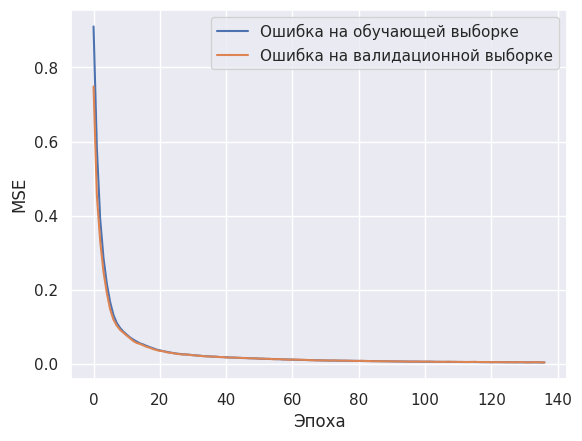

In [264]:
#Построение графика обучения
plt.plot(history.history['loss'], label = 'Ошибка на обучающей выборке')
plt.plot(history.history['val_loss'], label = 'Ошибка на валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [265]:
# Предсказание и расчет ошибки реконструкции
X_train_reconstructed = autoencoder.predict(X_train)
X_test_reconstructed = autoencoder.predict(X_test)
train_mse = np.mean(np.sum((X_train - X_train_reconstructed)**2, axis = 1))
test_mse = np.mean(np.sum((X_test - X_test_reconstructed)**2, axis = 1))

print(f"Среднеквадратическая ошибка на обучающей выборке: {train_mse}")
print(f"Среднеквадратическая ошибка на тестовой выборке: {test_mse}")

# Определение выбросов (настройте порог)
threshold = test_mse * 1.9 #Пример, подберите оптимальный порог

X_all_reconstructed = autoencoder.predict(X_fac_num_scaler)

all_errors = np.sum((X_fac_num_scaler - X_all_reconstructed)**2, axis = 1)
outliers = np.where(all_errors > threshold)[0]
#print(f"Индексы выбросов: {outliers}")

Среднеквадратическая ошибка на обучающей выборке: 0.11212341664795261
Среднеквадратическая ошибка на тестовой выборке: 0.11683971623310672


In [266]:
len(outliers)

892

In [267]:
outliers_autoencoders = np.zeros(len(second_nn))
outliers_autoencoders[outliers] = 1

print(outliers_autoencoders.sum())
outliers_autoencoders

892.0


array([0., 1., 0., ..., 0., 0., 0.])

In [268]:
second_nn['Manual_autoencoder'] = outliers_autoencoders.astype(int)

In [269]:
second_nn['sum_out_ml'] = second_nn[['IsolationForest', 'OneClassSVM', 'LOF', 'COPOD', 'PCA', 'Manual_autoencoder']].sum(axis = 1) #'OneClassSVM',
second_nn['sum_out_iqr'] = second_nn[['out_iqr', 'out_iqr_kv']].sum(axis = 1)

In [270]:
# сохраняем df с выбросами в csv
second_nn.to_csv('Выборка_Нижний_Новгород_2025_with_out_second.csv')

In [5]:
#second_kaz = pd.read_csv('Выборка_Казань_2025_out_second.csv')
#second_kaz.drop(columns={'Unnamed: 0'}, inplace=True)

In [271]:
second_nn.head(2)

cian_id                                      url  bargainterms_price  \
0  169401814  https://www.cian.ru/sale/flat/169401814          13800000.0   
1  190911020  https://www.cian.ru/sale/flat/190911020          16500000.0   

   area_total                                           address  floor  \
0        82.2   Россия, Нижний Новгород, улица Родионова, 195к2    7.0   
1       250.0  Россия, Нижний Новгород, улица Алёши Пешкова, 55    1.0   

   floors_count  wall_type last_edited repair_type  bti_year_built       lat  \
0            10    Блочный  2025-01-19    cosmetic             NaN  56.30257   
1             3  Кирпичный  2025-01-13    cosmetic             NaN  56.31702   

        lng             geo_region   geo_settlement         geo_city  \
0  44.07780  Нижегородская область  Нижний Новгород  Нижний Новгород   
1  43.95014  Нижегородская область  Нижний Новгород  Нижний Новгород   

            geo_street geo_house_num geo_microdistrict geo_city_district  \
0      улица Родионова         195к2  Печерская долина     Нижегородский   
1  улица Алеши Пешкова            55          Канавино       Канавинский   

                                         description  days_after_edit  \
0  Продам просторную 2-х комн. кв. 82/42,6/13,2 н...               17   
1  В "Старом Канавино" квартира 134м2 и пристроен...               23   

      poly_okrug            poly_district  bargainterms_price_ln  unit_price  \
0  Нижегородский         Печёрская_Долина              16.440179    167883.0   
1    Канавинский  Ярмарка_Старое_Канавино              16.618871     66000.0   

   bargainterms_price_LN  unit_price_LN nearest_metro  \
0              16.440179      12.031023   Горьковская   
1              16.618871      11.097410    Московская   

  distance_to_nearest_metro            lat_lng distance_to_centre  \
0                  5.309017   56.30257 44.0778           5.430419   
1                  0.494588  56.31702 43.95014           3.504196   

  distance_to_centre_1 bargainterms_price_bins is_elit housing_complex  \
0         от_5_до_7_км         от_12_до_15_млн     нет             нет   
1         от_2_до_5_км         от_15_до_20_млн     нет             нет   

           floor_1  med_price  Районы_Kmeans  year_release subway_time  \
0  от_5_до_9_этажа   202658.0             10          2009        10.0   
1           первый   137436.0              5          1905         7.0   

   subway_name subway_travel_type          subway_time_1 area_total_1  \
0  Горьковская          transport  нет_пешей_доступности  от_65_до_85   
1   Московская               walk     до_10_минут_пешком    более_105   

   Объем_рынка  IsolationForest  OneClassSVM  LOF  COPOD  PCA  out_iqr  \
0          975                0            0    0      0    0        0   
1          272                1            1    1      1    1        0   

   out_iqr_kv  Manual_autoencoder  sum_out_ml  sum_out_iqr  
0           0                   0           0            0  
1           0                   1           6            0

**Посмотрим распределение объектов по количеству обнаруженных алгоритмами выбросов**

In [272]:
second_nn['sum_out_ml'].value_counts()

0    3515
1    2342
2     915
3     313
4     289
5     268
6      33
Name: sum_out_ml, dtype: int64

In [273]:
second_nn['sum_out_iqr'].value_counts()

0    7588
1      83
2       4
Name: sum_out_iqr, dtype: int64

#### 11.4 Фильтруем от выбросов выборку
<font color='brightred'> Отсекаем из выборки выбросы по следующему условию: выбросом является объект, у которого сумма меток-единиц по алгоритмам  ‘IsolationForest’, ‘OneClassSVM’,  
 ‘LOF’, ‘COPOD’, ‘PCA’, ‘Manual_autoencoder’ больше либо равно 6 или хотя бы один из алгоритмов ‘out_iqr’, ‘out_iqr_kv’ поставил объекту метку-единицу  
Количество меток, по которым отсекаем выбросы, определяем самостоятельно в кажом случае  
В том числе смотрим на распределение % выбросов по районам </font> 

Выведем соотношение выбросных объектов к общему числу объектов по каждому из районов poly_district:

In [274]:
second_nn[(second_nn['sum_out_iqr'] >= 1) | (second_nn['sum_out_ml'] >= 6)]['poly_district'].value_counts()/second_nn['poly_district'].value_counts()

Авиационный_квартал_Орджоникидзе_Кооперативный_посёлок        0.031915
Агрокомбинат_Горьковский_микрорайон_Новый_Народный_посёлок         NaN
Александровская_слобода_Верхние_Печёры                        0.011152
Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_15_й_квартал    0.005747
Берёзовский_Красные_Зори                                      0.059172
Бурнаковский_Гордеевский                                           NaN
Володарский_посёлок                                           0.021978
Володарского_Дачный_посёлок                                   0.052632
Высоково                                                           NaN
Каштановый_дворик                                                  NaN
Комсомольская_площадь_Молитовка                               0.047244
Комсомольский_Ленгородок                                      0.004651
Красная_Этна_Ипподромный                                      0.005848
Кузнечиха                                                          NaN
Лапших

Получаем готовую выборку для модели:

In [ ]:
df_model = second_nn[second_nn['sum_out_ml'] < 6] # порог 6, так как при 5 удаляется много объектов из центра
df_model = df_model[df_model['sum_out_iqr'] == 0]
df_model.reset_index(drop = True , inplace = True )
df_model

# <font color='008B8B'> 12. Модель CatBoost </font> 🐈 🚀
После предобработки данных и работы с выбросами, мы получили выборку, готовую для использования в модели ✨  
Для удобства в модели будем использовать категориальные факторы расстояний (до центра, до метро)

<AxesSubplot:xlabel='bargainterms_price_LN', ylabel='is_elit'>

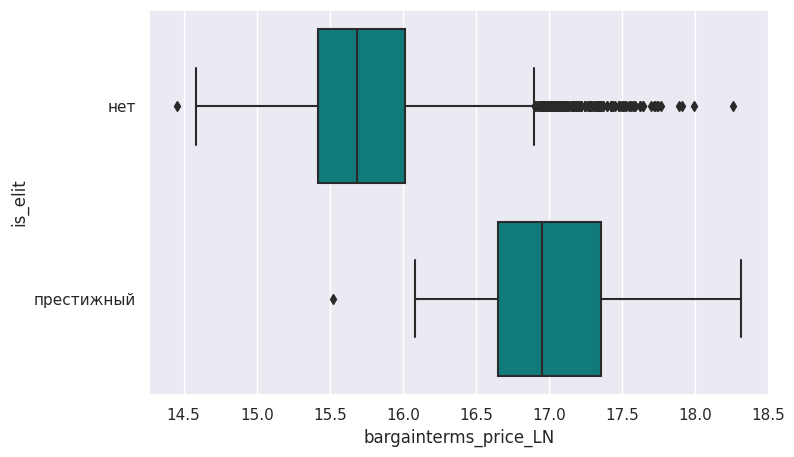

In [276]:
plt.figure(figsize = (8, 5))

sns.boxplot(data = df_model,
            x = 'bargainterms_price_LN',
            y = 'is_elit',
            color = 'darkcyan'
            )

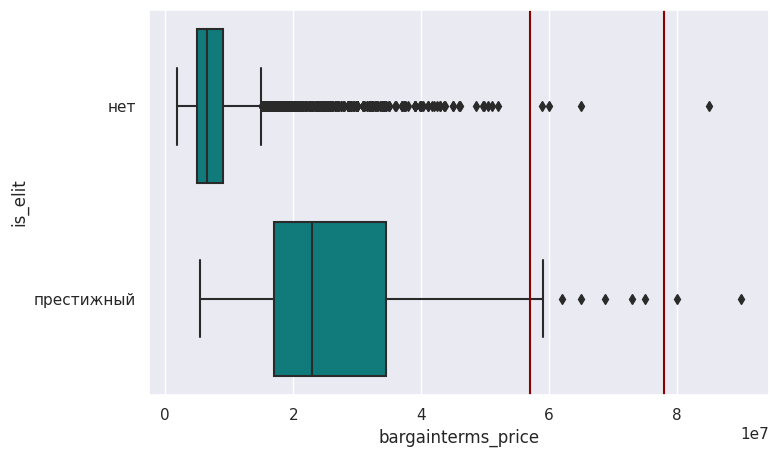

In [277]:
plt.figure(figsize = (8, 5))

sns.boxplot(data = df_model,
            x = 'bargainterms_price',
            y = 'is_elit',
            color = 'darkcyan'
            )

tr_1 = 57000000
tr_2 = 78000000
plt.axvline(tr_1, color = 'darkred')
plt.axvline(tr_2, color = 'darkred')

In [278]:
f_1 = df_model['is_elit'] == 'нет'
f_2 = df_model['bargainterms_price'] >= tr_1 
    
df_model_idx_1 = list(df_model[f_1 & f_2].index)

f_1 = df_model['is_elit'] != 'нет'
f_2 = df_model['bargainterms_price'] >= tr_2

df_model_idx_2 = list(df_model[f_1 & f_2].index)

df_model_idx_ = df_model_idx_1 + df_model_idx_2
#df_model_idx_

df_model_sc = df_model.drop(df_model_idx_)

df_model_sc.reset_index(drop = True , inplace = True )

len(df_model_sc)

7554

In [279]:
df_model_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   cian_id                    7554 non-null   int64         
 1   url                        7554 non-null   object        
 2   bargainterms_price         7554 non-null   float64       
 3   area_total                 7554 non-null   float64       
 4   address                    7554 non-null   object        
 5   floor                      7554 non-null   float64       
 6   floors_count               7554 non-null   int64         
 7   wall_type                  7476 non-null   object        
 8   last_edited                7554 non-null   datetime64[ns]
 9   repair_type                7554 non-null   object        
 10  bti_year_built             1421 non-null   float64       
 11  lat                        7554 non-null   float64       
 12  lng   

#### 12.1 Модель без выбросов и без весов 
Пробуем построить модель по выборке без выбросов (т.е. отфильтровываем их) и *не присваивая веса* для элитки

In [401]:
X = df_model_sc[[
                'area_total',
                'floor_1', 
                'floors_count',
                'is_elit',
                #'poly_okrug',
                #'poly_district', 
                'lat',
                'lng',
                'subway_time_1', 
                'distance_to_centre_1', 
                'repair_type',
                'year_release',
                'Объем_рынка'
              ]]

X_1 = df_model_sc[['bargainterms_price_bins']]

Y = df_model_sc['bargainterms_price_LN']

def get_categorical_indicies(X):  
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

cat_features = get_categorical_indicies(X)  # определяем категориальные факторы
print(cat_features)

[1, 3, 6, 7, 8]


In [402]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   area_total            7554 non-null   float64 
 1   floor_1               7554 non-null   object  
 2   floors_count          7554 non-null   int64   
 3   is_elit               7554 non-null   object  
 4   lat                   7554 non-null   float64 
 5   lng                   7554 non-null   float64 
 6   subway_time_1         7554 non-null   object  
 7   distance_to_centre_1  7554 non-null   category
 8   repair_type           7554 non-null   object  
 9   year_release          7554 non-null   int64   
 10  Объем_рынка           7554 non-null   int64   
dtypes: category(1), float64(3), int64(3), object(4)
memory usage: 597.9+ KB


In [291]:
#len(X.poly_district.unique())  # смотрим длину самого большого категориального признака

#### 12.1.1 CV

In [372]:
weights = [0.5, 1, 5]

def get_weight(price):
    if price < 14.9:        # 3 млн руб в логарифме
        return weights[0]
    #elif (price >= 16.52356) & (price < 16.811):     # 15-20 млн руб в логарифме
    #    return weights[2]
    elif price >= 16.8:     # 20 млн руб в логарифме
        return weights[2]
    else:
        return weights[1]

In [373]:
catb = CatBoostRegressor(
                         iterations = 1000, #максимальное количество построенных деревьев
                         random_seed = 5, 
                         learning_rate = 0.09, #скорость обучения, определяет насколько быстро или медленно модель будет учиться
                         max_depth = 6, #глубина дерева
                         #boosting_type = 'Ordered', #может дать хорошее качество при малых выборках, работает медленно
                         #l2_leaf_reg = 20, #коэффициент при члене регуляризации L2 функции потерь
                         #bagging_temperature = 1,
                         #random_strength = 1,
                         one_hot_max_size = 40, #не используем one hot encoding, а включаем one_hot_max_size
                         #loss_function = 'MAE', #по умолчанию
                         #eval_metric = 'MAPE', #MAPE
                         #od_type = 'Iter', #если модель переобучилась
                         #od_wait = 20
                         use_best_model = True,
                         early_stopping_rounds = 10
                        ) #делай остановку через 20 итераций
                         #если хотим хорошее качество, то уменьшаем learning_rate и увеличиваем iterations.
                         #если модель слишком рано переобучается, то l2_leaf_reg увеличиваем.

shuffle_split = ShuffleSplit(n_splits = 10, test_size = 0.15, random_state = 0)

#массив для сохранения итоговых оценок
all_rmse = [] 
all_mae = []
all_mape = []
all_r2 = []

for n, (tr_index, te_index) in enumerate(shuffle_split.split(X, Y)):
    print('Обработка процесса №', n)
    
    # Split data and target
    X_train = X.iloc[tr_index]
    Y_train = Y.iloc[tr_index]
    X_test = X.iloc[te_index]
    Y_test = Y.iloc[te_index]
    
    train_weights = [get_weight(price) for price in Y_train]

    catb.fit(X_train, Y_train, 
             cat_features = cat_features, #массив с индексами категориальных фичей
             eval_set = (X_test, Y_test),
             verbose = False,
             sample_weight = train_weights,
             #plot = True
            ) #включение графика
 
    pred_test = np.exp(catb.predict(X_test))
    mse_test = mse(np.exp(Y_test), pred_test)
    
    all_rmse.append(round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
    all_mae.append(round(mae(np.exp(Y_test), pred_test), 4))
    all_mape.append(round(mape(np.exp(Y_test), pred_test), 4))
    all_r2.append(r2_score(np.exp(Y_test), pred_test))

Обработка процесса № 0
Обработка процесса № 1
Обработка процесса № 2
Обработка процесса № 3
Обработка процесса № 4
Обработка процесса № 5
Обработка процесса № 6
Обработка процесса № 7
Обработка процесса № 8
Обработка процесса № 9


In [374]:
# массив оценок по k блокам
print('RMSE:', all_rmse)
print('MAE:', all_mae)
print('MAPE:', all_mape)
print('R2:', all_r2)

RMSE: [1608409.5779, 1522045.7794, 1639915.6574, 1567243.7112, 1398698.525, 1665438.4005, 1432758.6226, 1651624.0673, 1803882.166, 1973354.4421]
MAE: [875259.5307, 862673.2383, 874063.1269, 855585.2009, 822577.137, 898447.4985, 834644.7752, 874466.6369, 943810.8973, 915763.3941]
MAPE: [0.092, 0.0947, 0.0925, 0.0948, 0.0915, 0.0942, 0.0917, 0.0919, 0.098, 0.091]
R2: [0.9289221917274553, 0.9295810583246102, 0.9358249569672188, 0.9237288994799208, 0.9359093626936434, 0.9204669160092285, 0.950557530135738, 0.9386409670676245, 0.9054491773903162, 0.9163240221867348]


In [375]:
# среднее значение mae
print(f'RMSE_mean: {np.mean(all_rmse)}, std: {np.sqrt(np.array(all_rmse).var())}')
print(f'MAE_mean: {np.mean(all_mae)}, std: {np.sqrt(np.array(all_mae).var())}')
print(f'MAPE_mean: {np.mean(all_mape)}, std: {np.sqrt(np.array(all_mape).var())}')
print(f'R2_mean: {np.mean(all_r2)}, std: {np.sqrt(np.array(all_r2).var())}')

RMSE_mean: 1626337.0949399997, std: 160710.31633274799
MAE_mean: 875729.1435800001, std: 34420.74424464329
MAPE_mean: 0.09323, std: 0.002060121355648741
R2_mean: 0.9285405081982491, std: 0.012108454566688553


In [ ]:
# md = 6, lr = 0.09, полигоны
RMSE_mean: 1782519.6409200002, std: 212352.19647260706
MAE_mean: 907827.6733199998, std: 44440.56114033166
MAPE_mean: 0.09610999999999999, std: 0.0018035797736723508
R2_mean: 0.9164001214232342, std: 0.011177090398827957

# md = 6, lr = 0.09, координаты, веса {0.5, 1, 5}
RMSE_mean: 1626337.0949399997, std: 160710.31633274799
MAE_mean: 875729.1435800001, std: 34420.74424464329
MAPE_mean: 0.09323, std: 0.002060121355648741
R2_mean: 0.9285405081982491, std: 0.012108454566688553

#### 12.1.2 Модель

##### Разбиваем данные на train и test 

In [376]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, Y, test_size = 0.10, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6798, 11), (6798,), (756, 11), (756,))

##### Создаем веса для модели  
**Вариант 1 - ручной способ**

In [403]:
weights = [0.5, 1, 5]

def get_weight(price):
    if price < 14.9:        # 3 млн руб в логарифме
        return weights[0]
    #elif (price >= 16.52356) & (price < 16.811):     # 15-20 млн руб в логарифме
    #    return weights[2]
    elif price >= 16.8:     # 20 млн руб в логарифме
        return weights[2]
    else:
        return weights[1]

In [404]:
train_weights = [get_weight(price) for price in Y_train]
print(set(train_weights))

{0.5, 1, 5}


**Вариант 2 - через value_counts**

In [348]:
# Подсчет количества объектов в каждом классе
class_counts = X_train_1['bargainterms_price_bins'].value_counts()

# Вычисление весов, обратных частотам
train_weights = 1.0 / class_counts[X_train_1['bargainterms_price_bins']]
print(set(train_weights))

{0.0033444816053511705, 0.0004697040864255519, 0.003355704697986577, 0.0023752969121140144, 0.006802721088435374, 0.001358695652173913, 0.000361271676300578}


**Останавливаемся на ручном способе {0.5, 1, 5}**

##### Учим модель 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE на обучении: 538038.9492
RMSE на обучении: 831279.4786
MAPE на обучении: 0.0651
R2 на обучении: 0.9811
MAE на тесте: 845033.6994
RMSE на тесте: 1533310.0897
MAPE на тесте: 0.0913
R2 на тесте: 0.9431
MAE: 568762.8083
RMSE: 925828.7365
MAPE: 0.0677
R2: 0.9768


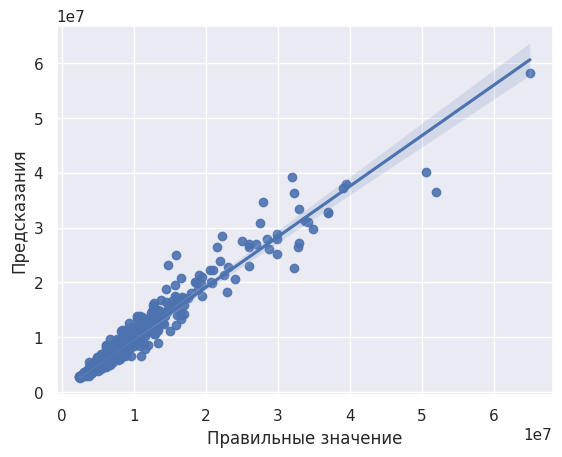

In [405]:
catb = CatBoostRegressor(iterations = 1000, #максимальное количество построенных деревьев
                         random_seed = 5, 
                         learning_rate = 0.09, #скорость обучения, определяет насколько быстро или медленно модель будет учиться
                         max_depth = 6, #глубина дерева
                         #boosting_type = 'Ordered', #может дать хорошее качество при малых выборках, работает медленно
                         #l2_leaf_reg = 20, #коэффициент при члене регуляризации L2 функции потерь
                         #bagging_temperature = 1,
                         #random_strength = 1,
                         one_hot_max_size = 40, #не используем one hot encoding, а включаем one_hot_max_size
                         #loss_function = 'MAE', #по умолчанию
                         #eval_metric = 'MAPE', #MAPE
                         #od_type = 'Iter', #если модель переобучилась
                         #od_wait = 20,
                         use_best_model = True,
                         early_stopping_rounds = 10
                        ) #делай остановку через 20 итераций
#если хотим хорошее качество, то уменьшаем learning_rate и увеличиваем iterations.
#если модель слишком рано переобучается, то l2_leaf_reg увеличиваем.

catb.fit(X_train, Y_train, 
         cat_features = cat_features, #массив с индексами категориальных фичей
         eval_set = (X_test, Y_test),
         verbose = False,
         sample_weight = train_weights, # веса для данных по цене
         plot = True) #включение графика

pred_1 = np.exp(catb.predict(X))

pred_train = np.exp(catb.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(catb.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

print("MAE:", round(mae(np.exp(Y), pred_1), 4))
print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test, scatter_kws = {'alpha': 0.9}) # регулируя alpha мы можем увидеть как много точек отходит от прямой
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [ ]:
# md = 6, lr = 0.09 полигоны
MAE на обучении: 713616.6689
RMSE на обучении: 1278998.0138
MAPE на обучении: 0.0792
R2 на обучении: 0.9552
===============================
MAE на тесте: 878003.367
RMSE на тесте: 1658868.4821
MAPE на тесте: 0.0936
R2 на тесте: 0.9334
===============================
MAE: 730068.3957
RMSE: 1321940.0266
MAPE: 0.0806
R2: 0.9527

# md = 6, lr = 0.09 координаты
MAE на обучении: 626296.9286
RMSE на обучении: 1079721.6811
MAPE на обучении: 0.0708
R2 на обучении: 0.968
===============================
MAE на тесте: 851660.5153
RMSE на тесте: 1593658.6363
MAPE на тесте: 0.0909
R2 на тесте: 0.9385
===============================
MAE: 648851.1875
RMSE: 1141622.9381
MAPE: 0.0728
R2: 0.9647

# md = 6, lr = 0.09 координаты, {0.5, 1, 5}
MAE на обучении: 538038.9492
RMSE на обучении: 831279.4786
MAPE на обучении: 0.0651
R2 на обучении: 0.9811
===============================
MAE на тесте: 845033.6994
RMSE на тесте: 1533310.0897
MAPE на тесте: 0.0913
R2 на тесте: 0.9431
===============================
MAE: 568762.8083
RMSE: 925828.7365
MAPE: 0.0677
R2: 0.9768

# md = 6, lr = 0.09 координаты, {0.0033444816053511705, 0.0004697040864255519, 0.003355704697986577, 0.0023752969121140144, 0.006802721088435374, 0.001358695652173913, 0.000361271676300578}
MAE на тесте: 931000

In [380]:
# Объем квартир стоимостью до 20 млн. руб. в тестовом наборе данных
pr = 20000000
pr_ln = np.log(pr)
print('Всего:', len(Y_test))
print('Меньше pr_ln:', len(Y_test[Y_test <= pr_ln]))

Всего: 756
Меньше pr_ln: 717


In [381]:
rmse = catb.get_evals_result()

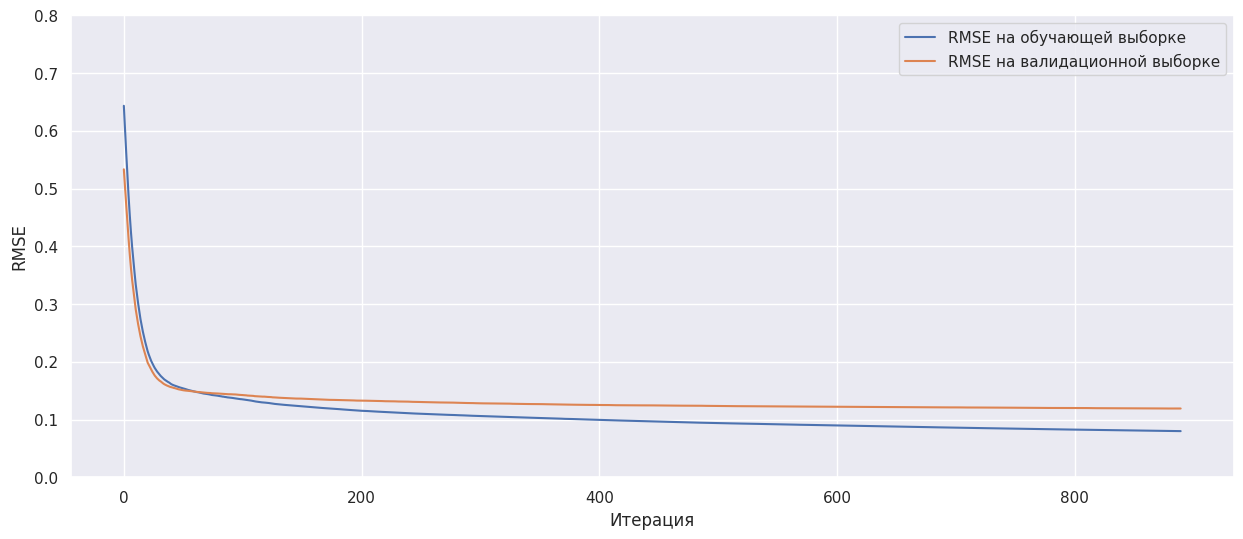

In [382]:
plt.figure(figsize = (15, 6))

plt.plot(rmse['learn']['RMSE'], label = 'RMSE на обучающей выборке')
plt.plot(rmse['validation']['RMSE'], label = 'RMSE на валидационной выборке')
plt.xlabel('Итерация')
plt.ylabel('RMSE')

plt.ylim((0, 0.8))

plt.legend()
plt.show()

#### 12.1.3 График важности признаков

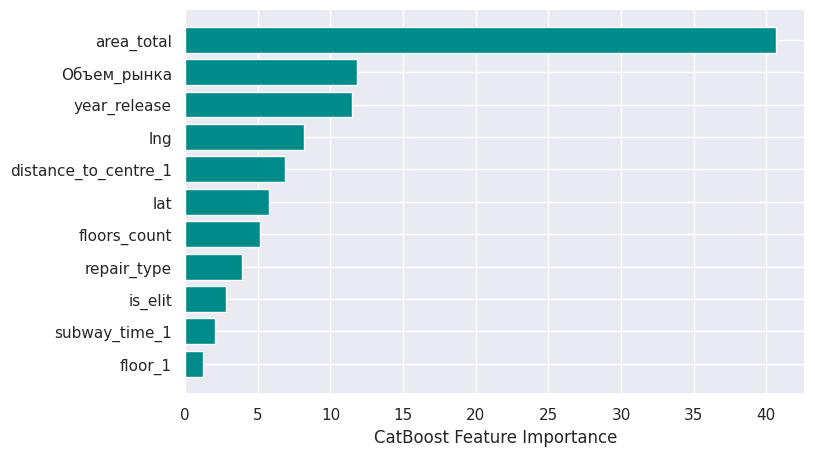

In [383]:
feature_names = ['area_total',
                'floor_1', 
                'floors_count',
                'is_elit',
                #'poly_okrug',
                #'poly_district', 
                'lat',
                'lng',
                'subway_time_1', 
                'distance_to_centre_1', 
                'repair_type',
                'year_release',
                'Объем_рынка'
               ]
features = np.array(feature_names)

sorted_feature_importance = catb.feature_importances_.argsort()
plt.figure(figsize = (8, 5))
plt.barh(features[sorted_feature_importance], 
         catb.feature_importances_[sorted_feature_importance], 
         color = 'darkcyan')
plt.xlabel('CatBoost Feature Importance')
plt.show()

#### 13.1.4 Графики learning_curve и validation_curve

In [384]:
X = df_model_sc[[
                'area_total',
                'floor_1', 
                'floors_count',
                'is_elit',
                #'poly_okrug',
                #'poly_district', 
                'lat',
                'lng',
                'subway_time_1', 
                'distance_to_centre_1', 
                'repair_type',
                'year_release',
                'Объем_рынка'
              ]]

Y = df_model_sc['bargainterms_price_LN']

In [385]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   area_total            7554 non-null   float64 
 1   floor_1               7554 non-null   object  
 2   floors_count          7554 non-null   int64   
 3   is_elit               7554 non-null   object  
 4   lat                   7554 non-null   float64 
 5   lng                   7554 non-null   float64 
 6   subway_time_1         7554 non-null   object  
 7   distance_to_centre_1  7554 non-null   category
 8   repair_type           7554 non-null   object  
 9   year_release          7554 non-null   int64   
 10  Объем_рынка           7554 non-null   int64   
dtypes: category(1), float64(3), int64(3), object(4)
memory usage: 597.9+ KB


In [386]:
# для столбцов более чем с 2 категориями
enc = OneHotEncoder(handle_unknown = 'ignore')
enc_df = pd.DataFrame(enc.fit_transform(X[['floor_1', 'subway_time_1', 'distance_to_centre_1', 'repair_type']]).toarray())

enc_df.columns = enc.get_feature_names() #см ниже
X = X.join(enc_df)

In [ ]:
# для столбцов с 2 категориями
encoder = LabelEncoder()

X['is_elit_nn'] = encoder.fit_transform(X[['is_elit']])
X

In [388]:
list(X.columns)

['area_total',
 'floor_1',
 'floors_count',
 'is_elit',
 'lat',
 'lng',
 'subway_time_1',
 'distance_to_centre_1',
 'repair_type',
 'year_release',
 'Объем_рынка',
 'x0_10_и_более',
 'x0_не_важно',
 'x0_от_2_до_4_этажа',
 'x0_от_5_до_9_этажа',
 'x0_первый',
 'x0_последний',
 'x1_больше_10_минут_пешком',
 'x1_до_10_минут_пешком',
 'x1_неважно',
 'x1_нет_пешей_доступности',
 'x2_до_2_км ',
 'x2_от_2_до_5_км',
 'x2_от_5_до_7_км',
 'x2_от_7_до_8_км',
 'x2_от_8_км',
 'x3_cosmetic',
 'x3_design',
 'x3_euro',
 'x3_no',
 'is_elit_nn']

Собираем все исходные числовые факторы и преобразованные в число с помощью OneHotEncoder и LabelEncoder факторы в df  

In [389]:
X_num = X[[  'area_total',
             #'floor_1',
             'floors_count',
             #'is_elit',
             'lat',
             'lng',
             #'subway_time_1',
             #'distance_to_centre_1',
             #'repair_type',
             'year_release',
             'Объем_рынка',
             'x0_10_и_более',
             'x0_не_важно',
             'x0_от_2_до_4_этажа',
             'x0_от_5_до_9_этажа',
             'x0_первый',
             'x0_последний',
             'x1_больше_10_минут_пешком',
             'x1_до_10_минут_пешком',
             'x1_неважно',
             'x1_нет_пешей_доступности',
             'x2_до_2_км ',
             'x2_от_2_до_5_км',
             'x2_от_5_до_7_км',
             'x2_от_7_до_8_км',
             'x2_от_8_км',
             'x3_cosmetic',
             'x3_design',
             'x3_euro',
             'x3_no',
             'is_elit_nn'
        ]]

In [390]:
# проверяем, что все факторы числовые! Все ОК
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_total                 7554 non-null   float64
 1   floors_count               7554 non-null   int64  
 2   lat                        7554 non-null   float64
 3   lng                        7554 non-null   float64
 4   year_release               7554 non-null   int64  
 5   Объем_рынка                7554 non-null   int64  
 6   x0_10_и_более              7554 non-null   float64
 7   x0_не_важно                7554 non-null   float64
 8   x0_от_2_до_4_этажа         7554 non-null   float64
 9   x0_от_5_до_9_этажа         7554 non-null   float64
 10  x0_первый                  7554 non-null   float64
 11  x0_последний               7554 non-null   float64
 12  x1_больше_10_минут_пешком  7554 non-null   float64
 13  x1_до_10_минут_пешком      7554 non-null   float

In [392]:
weights = [get_weight(price) for price in Y]
print(set(train_weights))

{0.5, 1, 5}


In [394]:
catb_lv = CatBoostRegressor(iterations = 1200, #максимальное количество построенных деревьев
                            random_seed = 5, 
                            learning_rate = 0.09, #скорость обучения, определяет насколько быстро или медленно модель будет учиться
                            max_depth = 6, #глубина дерева
                            od_type = 'Iter', #если модель переобучилась
                            od_wait = 10,
                            #use_best_model = True,
                            #early_stopping_rounds = 10,
                            verbose = False
                           )

In [395]:
shuffle_split = ShuffleSplit(n_splits = 5, test_size = 0.05, random_state = 0)

train_sizes, train_scores, test_scores = learning_curve(
                                                        catb_lv,
                                                        X_num, 
                                                        Y,
                                                        cv = shuffle_split,
                                                        scoring = 'neg_root_mean_squared_error', # 'neg_root_mean_squared_error'
                                                        train_sizes = np.linspace(0.05, 0.95, 20, endpoint = True),
                                                        #train_sizes = np.linspace(0.05, 0.95, 20) * 7586,
                                                        #train_sizes = [0.05, 0.1, 0.15, 0.2, 0.25, 
                                                        #               0.3, 0.35, 0.4, 0.45, 0.50, 
                                                        #               0.55, 0.6, 0.65, 0.7, 0.75, 
                                                        #               0.8, 0.85, 0.9, 0.95],
                                                        verbose = False,
                                                        fit_params = {'sample_weight': weights}
                                                        )
#максимальный train_sizes будет зависить от cv, где устанавливается фиксированный размер testa, сейчас он = 10%
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

<function matplotlib.pyplot.show(close=None, block=None)>

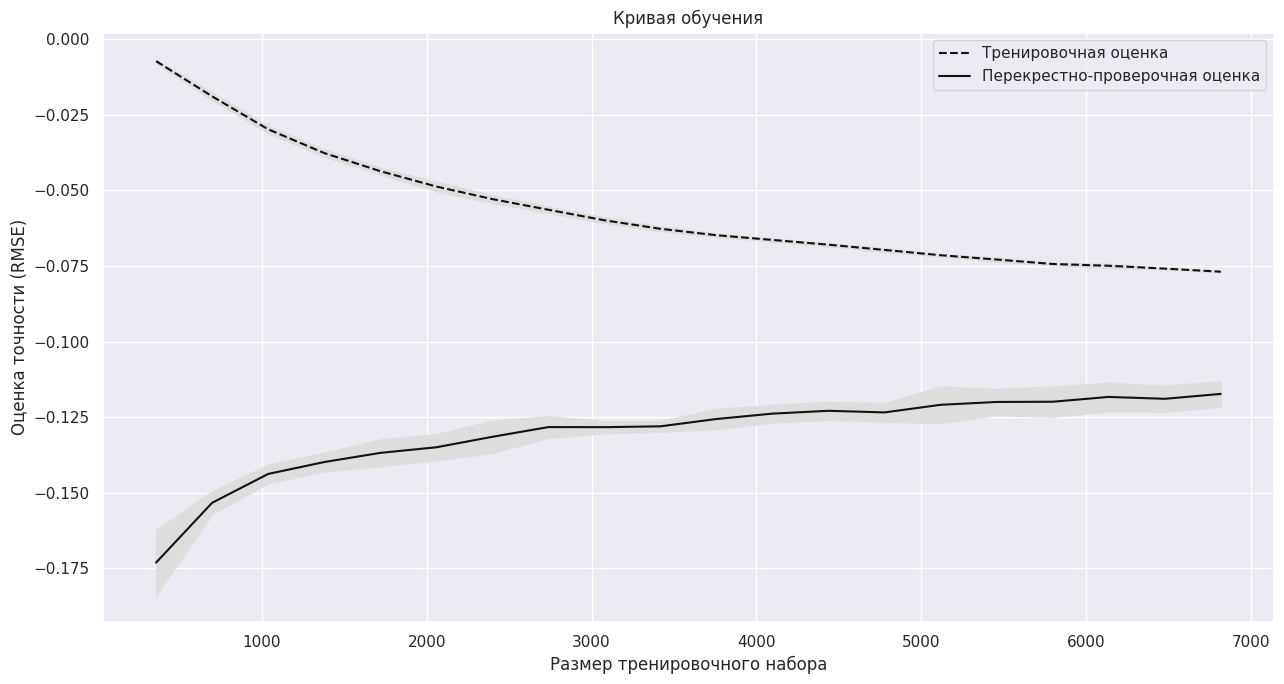

In [396]:
plt.figure(figsize = (13, 7))
plt.plot(train_sizes, train_mean, '--', color = "#111111",
         label = "Тренировочная оценка")
plt.plot(train_sizes, test_mean, color = "#111111",
         label = "Перекрестно-проверочная оценка")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#DDDDDD")

plt.title("Кривая обучения")
plt.xlabel("Размер тренировочного набора")
plt.ylabel("Оценка точности (RMSE)")
plt.legend(loc = "best")
plt.tight_layout()
plt.show

In [397]:
shuffle_split = ShuffleSplit(n_splits = 5, test_size = 0.05, random_state = 0)

train_sizes, train_scores, test_scores = learning_curve(
                                                        catb_lv,
                                                        X_num, 
                                                        Y,
                                                        cv = shuffle_split,
                                                        scoring = 'neg_mean_absolute_error', # 'neg_root_mean_squared_error'
                                                        train_sizes = np.linspace(0.05, 0.95, 20, endpoint = True),
                                                        #train_sizes = np.linspace(0.05, 0.95, 20) * 7586,
                                                        #train_sizes = [0.05, 0.1, 0.15, 0.2, 0.25, 
                                                        #               0.3, 0.35, 0.4, 0.45, 0.50, 
                                                        #               0.55, 0.6, 0.65, 0.7, 0.75, 
                                                        #               0.8, 0.85, 0.9, 0.95],
                                                        verbose = False,
                                                        fit_params = {'sample_weight': weights}
                                                        )
#максимальный train_sizes будет зависить от cv, где устанавливается фиксированный размер testa, сейчас он = 10%
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

<function matplotlib.pyplot.show(close=None, block=None)>

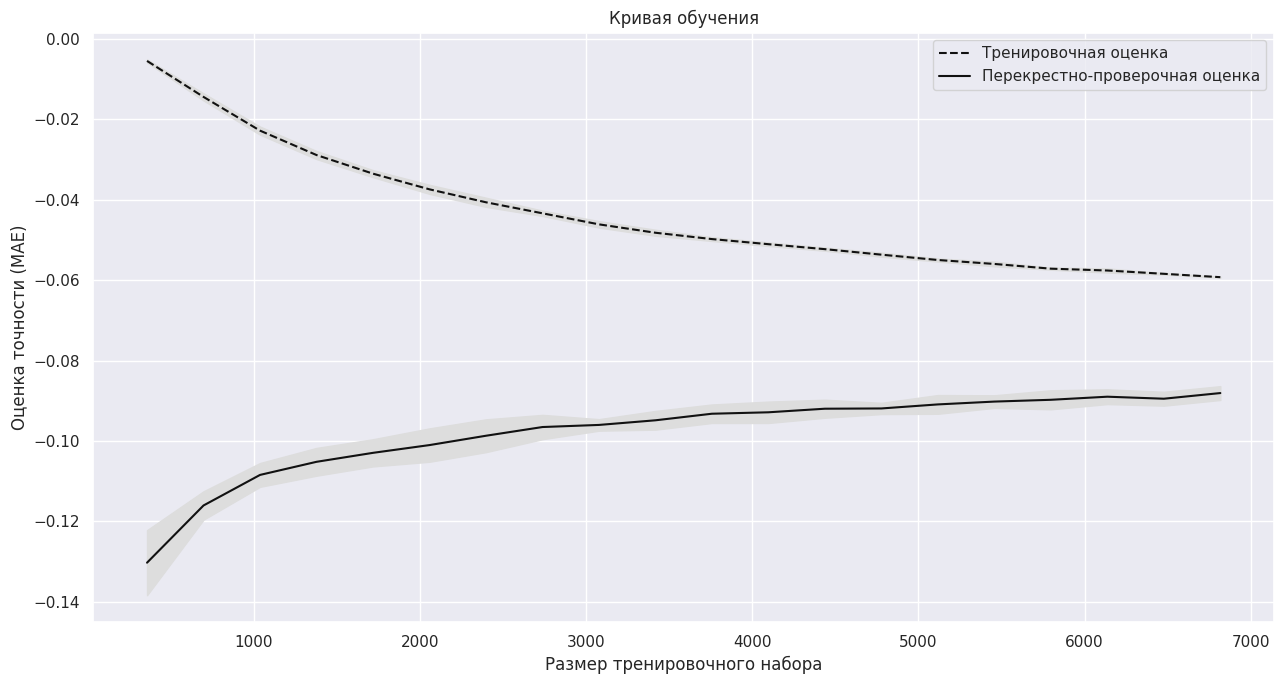

In [398]:
plt.figure(figsize = (13, 7))
plt.plot(train_sizes, train_mean, '--', color = "#111111",
         label = "Тренировочная оценка")
plt.plot(train_sizes, test_mean, color = "#111111",
         label = "Перекрестно-проверочная оценка")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#DDDDDD")

plt.title("Кривая обучения")
plt.xlabel("Размер тренировочного набора")
plt.ylabel("Оценка точности (MAE)")
plt.legend(loc = "best")
plt.tight_layout()
plt.show

Кривая обучения показывает как ошибка/точность модели меняется в зависимости от размера обучающей выборки. Наша точность оценивается по RMSE в логарифмическом масштабе. По мере увеличения обучающей выборки качество модели на тесте растет. Разрыв между кривыми показывает на переобучение/недообучение. В нашем случае разрыв несущественный, кроме того, в части RMSE необходимо помнить о ее зависимости от выбросов. В части MAE разрыв уменьшается в 2 раза относительно RMSE (влияние выбросов), таким образом, по RMSE можно переоценить переобучение.

<function matplotlib.pyplot.show(close=None, block=None)>

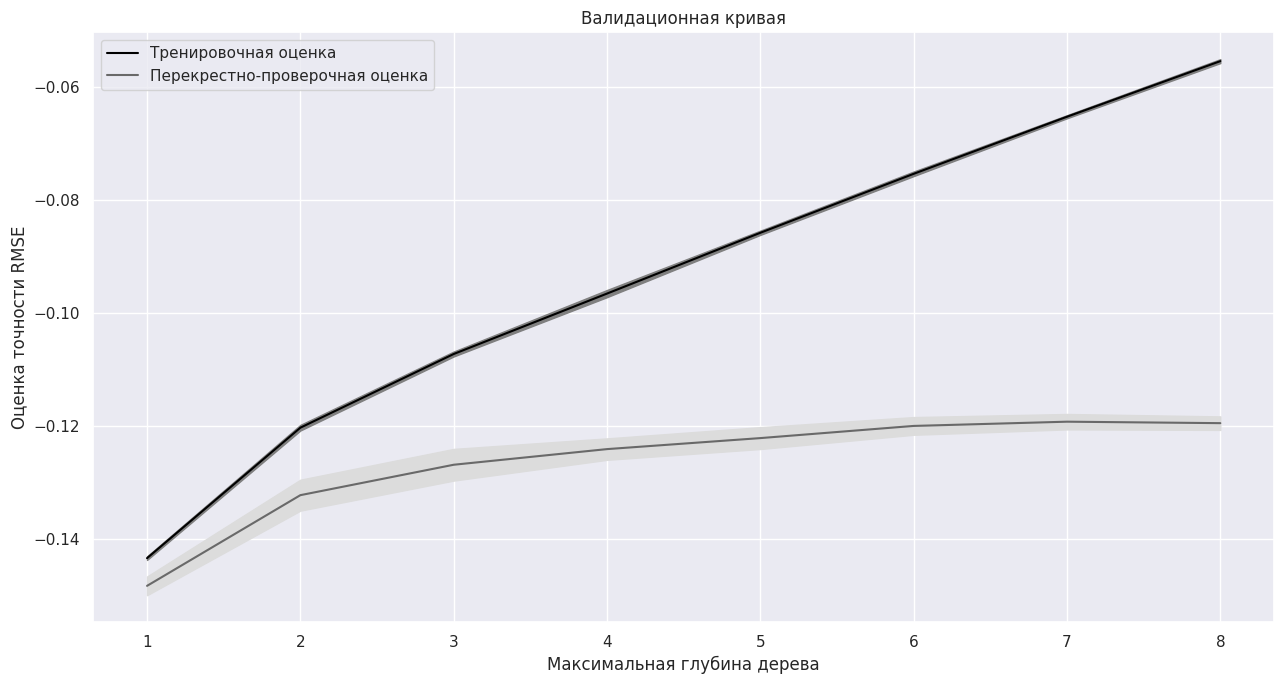

In [399]:
shuffle_split = ShuffleSplit(n_splits = 5, test_size = 0.15, random_state = 0)
param_range = np.arange(1, 9, 1)

train_scores, test_scores = validation_curve(
                                             catb_lv,
                                             X_num, 
                                             Y,
                                             cv = shuffle_split,
                                             scoring = 'neg_root_mean_squared_error',
                                             param_name = "max_depth",
                                             param_range = param_range,
                                             n_jobs = -1,
                                             verbose = False,
                                             fit_params = {'sample_weight': weights}
                                            )

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.figure(figsize = (13, 7))
plt.plot(param_range, train_mean, color = "black",
         label = "Тренировочная оценка")
plt.plot(param_range, test_mean, color = "dimgrey",
         label = "Перекрестно-проверочная оценка")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color = "gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color = "gainsboro")

plt.title("Валидационная кривая")
plt.xlabel("Максимальная глубина дерева")
plt.ylabel("Оценка точности RMSE")
plt.legend(loc = "best")
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

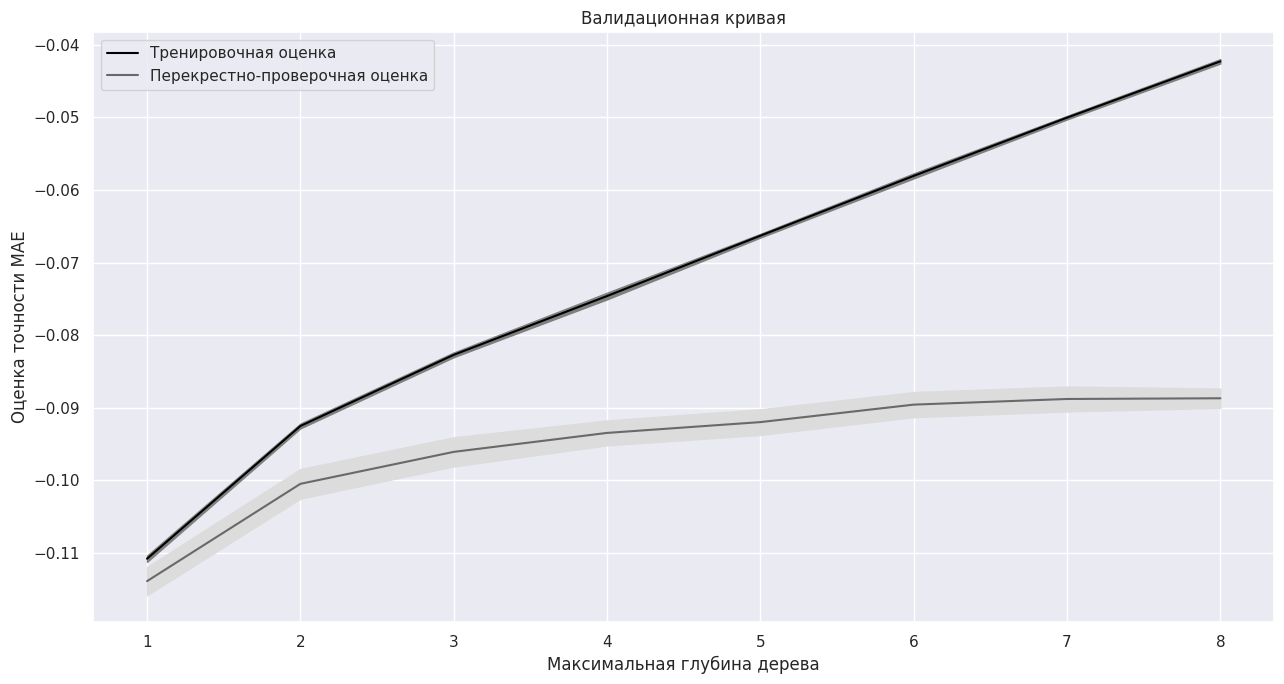

In [400]:
shuffle_split = ShuffleSplit(n_splits = 5, test_size = 0.15, random_state = 0)
param_range = np.arange(1, 9, 1)

train_scores, test_scores = validation_curve(
                                             catb_lv,
                                             X_num, 
                                             Y,
                                             cv = shuffle_split,
                                             scoring = 'neg_mean_absolute_error',
                                             param_name = "max_depth",
                                             param_range = param_range,
                                             n_jobs = -1,
                                             verbose = False,
                                             fit_params = {'sample_weight': weights}
                                            )

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.figure(figsize = (13, 7))
plt.plot(param_range, train_mean, color = "black",
         label = "Тренировочная оценка")
plt.plot(param_range, test_mean, color = "dimgrey",
         label = "Перекрестно-проверочная оценка")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color = "gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color = "gainsboro")

plt.title("Валидационная кривая")
plt.xlabel("Максимальная глубина дерева")
plt.ylabel("Оценка точности MAE")
plt.legend(loc = "best")
plt.tight_layout()
plt.show

Кривая валидации показывает, как меняется качество модели в зависимости от значения гиперпараметра. В нашем случае мы взяли один из самых важных гиперпараметров – глубина дерева. По графику видно, что по мере увеличения глубина дерева качество модели на тесте растет медленно, при этом, разрыв между тренировочной оценкой и валидационной оценкой растет, что может привести к переобучению модели. Исходя из графика выше, лучше принять max_depth = 6 или добавить регуляризацию l2_leaf_reg, что позволит не сильно потерять в качестве на тесте, но существенно уменьшить разрыв.

#### 12.1.5 Сохраняем модель

In [407]:
import pickle
pickle.dump(catb, open('catmodel_nn_2025_reg.pkl', 'wb')) #6 выбросов

In [58]:
#pickle.dump(catb, open('catmodel_kzn_2025_wo_out_5.pkl', 'wb'))

# <font color='008B8B'> 13. Анализ ошибок модели </font> 🔍

In [456]:
model_cat = pickle.load(open('catmodel_nn_2025_reg.pkl', 'rb'))  # загружаем модель

In [463]:
pd.options.display.float_format = '{:.6f}'.format

#### 13.1 Ошибки по районам
<font color='steelblue'>
• RMSE (Root Mean Squared Error): Показывает среднее квадратичное отклонение предсказанных значений от фактических. Большое значение RMSE может быть вызвано несколькими факторами: наличием выбросов, нелинейностью зависимости, недостатком данных. В вашем случае, высокое RMSE может быть обусловлено, прежде всего, очень высокими ценами на некоторые квартиры.  
• MAE (Mean Absolute Error): Показывает среднюю абсолютную ошибку предсказания. Менее чувствительно к выбросам, чем RMSE.  
• MAPE (Mean Absolute Percentage Error): Показывает среднюю абсолютную процентную ошибку. Полезно для сравнения моделей на разных наборах данных. 8.5% — это относительно небольшая ошибка, если рассматривать её как процент от стоимости квартиры. MAPE может быть полезной, но с осторожностью: если в районе есть объекты с очень низкими ценами, MAPE может давать искаженные результаты.  
• R-squared (R²): Показывает, какую долю дисперсии целевой переменной объясняет модель. 95% — очень хороший показатель, указывает на высокую объяснительную способность модели.  
• Межквартильный размах (IQR):  Более устойчиво к выбросам.  Показывает разницу между 75-м и 25-м процентилями данных.  


Если вам важна точность предсказания в абсолютных значениях, то MAE может быть предпочтительнее, чем RMSE.  Если важно минимизировать процентную ошибку, то MAPE — лучший выбор.  
Из-за влияния выбросов (дорогих квартир) на RMSE, MAE и MAPE могут быть более информативными, чем RMSE.  
R² показывает общую объяснительную способность модели.

При наличии объектов с очень высокими ценами (выбросы), MAE становится более надежной метрикой, чем RMSE, так как RMSE усиливает влияние выбросов (из-за квадратичной шкалы).
    
Вместо средней цены можно использовать медиану или другие квантили.  Если в ваших данных есть выбросы (очень дорогие квартиры), медиана будет более устойчивым показателем центральной тенденции.

Посмотрите на распределение цен на квартиры. Если оно сильно скошено вправо (как в случае с квартирами в Москве,  где есть очень дорогие объекты),  то  relative_mae  и relative_rmse могут быть обманчивыми, потому что они будут сильно искажены выбросами.  В этом случае,  лучше сегментировать данные по ценовым категориям и оценить relative_mae и relative_rmse отдельно для каждой категории.

Если RelMAE < 10%, модель можно считать адекватной.
                  

**IQR (межквартильный размах)** показывает, насколько вариативны ошибки модели для 50% объектов (между 25-м и 75-м процентилями). Если IQR по MAE значительно больше самого MAE, это говорит о высокой вариативности ошибок.  
Однако, это не всегда проблема, если абсолютные значения MAE и IQR относительно низкие (например, в контексте цен на квартиры). Важно учитывать их масштаб относительно средней или медианной цены в районе.  
Если ошибки (MAE и IQR) малы относительно цены (например, менее 10% медианной цены), даже высокий IQR не обязательно указывает на нестабильность модели. Это может быть просто особенностью распределения ошибок.  
Если IQR велик (больше MAE) и при этом метрики \( R^2 \), MAE, RMSE хорошие, это говорит скорее о том, что модель справляется в среднем, но на некоторых объектах есть сильные отклонения.


In [458]:
features = [
            'area_total',
            'floor_1', 
            'floors_count',
            'is_elit',
            #'poly_okrug',
            #'poly_district', 
            'lat',
            'lng',
            'subway_time_1', 
            'distance_to_centre_1', 
            'repair_type',
            'year_release',
            'Объем_рынка'
          ]

In [464]:
metrics = []
div = 10**12 # подбираем в ручную для расчета SS_res и SS_tot

for distr in df_model_sc['poly_district'].unique():
    pred_1 = np.exp(model_cat.predict(df_model_sc[df_model_sc['poly_district'] == distr][features]))

    Y = df_model_sc[df_model_sc['poly_district'] == distr]['bargainterms_price_LN']
    
    MAE = round(mae(np.exp(Y), pred_1), 4)
    RMSE = round(sqrt(mse(np.exp(Y), pred_1)), 4)
    MAPE = round(mape(np.exp(Y), pred_1), 4)
    R2 = round(r2_score(np.exp(Y), pred_1), 4) # R2 = 1 - SS_res/SS_tot
    
    Y_mean = np.mean(np.exp(Y))
    SS_res = np.sum((np.exp(Y) - pred_1) ** 2) / div # Вычисление SSres (сумма квадратов отклонений от прогноза). div - это делитель, необходимый для уменьшения квадратичной суммы
    SS_tot = np.sum((np.exp(Y) - Y_mean) ** 2) / div # Вычисление SStot (сумма квадратов отклонений от среднего значения). div - это делитель, необходимый для уменьшения квадратичной суммы
    
    iqr_MAE = np.percentile((np.exp(Y)-pred_1), 75) - np.percentile((np.exp(Y)-pred_1), 25)
    delta_iqr_MAE = round(iqr_MAE/MAE, 2)
    n_objects = len(pred_1)
    relMAE = round(MAE/np.median(np.exp(Y)), 4)
    relRMSE = round(RMSE/np.median(np.exp(Y)), 4)
    minim = np.min(np.exp(Y))
    maxim = np.max(np.exp(Y))
    mean_p = np.mean(np.exp(Y))
    median_p = np.median(np.exp(Y))

    metrics.append([distr, MAE, RMSE, MAPE, R2, SS_res, SS_tot, iqr_MAE, delta_iqr_MAE, n_objects, relMAE, relRMSE, minim, maxim, mean_p, median_p])
    
table = pd.DataFrame(metrics, columns = ['district', 'MAE', 'RMSE', 'MAPE', 'R2', 'SS_res', 'SS_tot', 'iqr_MAE', 'delta_iqr_MAE', 'n_objects', 
                                         'relMAE', 'relRMSE', 'minim', 'maxim', 'mean_p', 'median_p']).sort_values('MAE', ascending = False)

#pd.options.display.float_format = '{:.2f}'.format
table[:40]

district            MAE  \
13                             Старый_Нижний_Новгород 1313387.844400   
0                                    Печёрская_Долина  961408.624200   
2                                            Высоково  908090.291500   
3                            Север_Советского_района   813933.929500   
7                                     Мещерское_Озеро  800130.946300   
31                              Юг_Советского_района   771885.463900   
6                            Комсомольский_Ленгородок  610419.814800   
17             Александровская_слобода_Верхние_Печёры  578357.048300   
19                                         Усиловский  559224.437400   
10                                           Соцгород  555245.225500   
11                                   Лапшиха_Нагорный  537459.956700   
4                                           Кузнечиха  509692.605100   
21                                Володарский_посёлок  505795.362700   
28  Новая_Стройка_Караваиха_Стройгаз_Суриковский_Д...  500887.733200   
8                            Бурнаковский_Гордеевский  486414.382000   
34                            Ярмарка_Старое_Канавино  479527.686400   
12            Сормова_Вождей_Революции_10_мкр_Дарьино  468895.326600   
14                                           Щербинки  464054.142300   
30                                  Каштановый_дворик  451891.550200   
23  Молитовский_Затон_Двигатель_Революции_Станкозавод  441152.636400   
5                              Стройплощадка_Северный  434358.012300   
9                              Спортивный_Калининский  430102.679200   
22                    Комсомольская_площадь_Молитовка  419216.791300   
16                           Красная_Этна_Ипподромный  371938.098400   
27                                 посёлок_Колхозный   355936.198200   
25            Лесной_Городок_Вторчермет_Сортировочный  355772.872700   
20  Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_...  354385.629900   
32                           Берёзовский_Красные_Зори  336092.011700   
26  Авиационный_квартал_Орджоникидзе_Кооперативный...  335649.006100   
18                                       Мончегорский  331709.346900   
24         Светлоярский_5_7_мкр_Комсомольский_посёлок  328696.608000   
1                          Народная_Стройка_завод_ГАЗ  321178.253700   
35                        Володарского_Дачный_посёлок  318033.288700   
33                            Юго_Западный_Юг_6_й_мкр  308349.178400   
15  Агрокомбинат_Горьковский_микрорайон_Новый_Наро...  282684.431800   
29                    Мостоотряд_посёлок_Стахановский  254830.624300   

             RMSE     MAPE       R2      SS_res       SS_tot        iqr_MAE  \
13 2039257.261700 0.079000 0.974600 2166.615063 85143.447344 1663991.932872   
0  1402040.829800 0.068900 0.952300  463.909563  9732.398439 1196635.997547   
2  1320247.333400 0.069400 0.970500  615.297716 20876.201666 1208106.013442   
3  1210452.259900 0.062700 0.970900  253.478678  8711.399951  987163.184505   
7  1097665.013600 0.075100 0.920100  380.738440  4766.721104 1157738.814062   
31 1161817.882500 0.079800 0.930100  309.108961  4421.775713 1056377.245759   
6   920280.838900 0.079600 0.906800  181.240200  1943.968247  730769.769481   
17  850173.988800 0.061700 0.935600  192.263686  2984.750654  770914.074767   
19  808750.545600 0.069500 0.860500   73.910751   529.783549  799342.448562   
10  790730.517000 0.076400 0.927300  216.963398  2984.991269  823065.730083   
11  812958.961000 0.074000 0.893600  158.616545  1491.022201  727887.566659   
4   683786.248600 0.061200 0.947700   74.810181  1429.314264  798031.230345   
21  662500.066500 0.074100 0.923800   39.062664   512.458466  722018.219672   
28  732393.993900 0.066400 0.952400  162.529492  3411.924931  735975.212197   
8   678100.001300 0.069600 0.908700  139.325342  1526.191789  674603.746755   
34  740412.750800 0.066500 0.932900   42.212250   629.024956  615166.125360   
12  643874.438600 0.067100 0.962800  

#### 13.2 Ошибки по интервалам площадей

In [468]:
X_1 = df_model_sc[[
                    'area_total',
                    'floor_1', 
                    'floors_count',
                    'is_elit',
                    #'poly_okrug',
                    #'poly_district', 
                    'lat',
                    'lng',
                    'subway_time_1', 
                    'distance_to_centre_1', 
                    'repair_type',
                    'year_release',
                    'Объем_рынка',
                    'area_total_1'
                  ]]

In [469]:
X_1['area_total_1'].unique()

['от_65_до_85', 'от_42_до_65', 'от_85_до_105', 'более_105', 'от_28_до_42', 'до_28']
Categories (6, object): ['до_28' < 'от_28_до_42' < 'от_42_до_65' < 'от_65_до_85' < 'от_85_до_105' < 'более_105']

In [470]:
metrics = []
pred = np.exp(model_cat.predict(X))
X_1['pred'] = pred
div = 10**12 # подбираем в ручную для расчета SS_res и SS_tot

list_1 = ['до_28', 'от_28_до_42', 'от_42_до_65', 'от_65_до_85', 'от_85_до_105', 'более_105']
for sq in list_1:
    
    pred_1 = X_1[X_1['area_total_1'] == sq]['pred']
    Y = df_model_sc[df_model_sc['area_total_1'] == sq]['bargainterms_price_LN']
    
    MAE = round(mae(np.exp(Y), pred_1), 4)
    RMSE = round(sqrt(mse(np.exp(Y), pred_1)), 4)
    MAPE = round(mape(np.exp(Y), pred_1), 4)
    R2 = round(r2_score(np.exp(Y), pred_1), 4) # R2 = 1 - SS_res/SS_tot
    
    Y_mean = np.mean(np.exp(Y))
    SS_res = np.sum((np.exp(Y) - pred_1) ** 2) / div # Вычисление SSres (сумма квадратов отклонений от прогноза). div - это делитель, необходимый для уменьшения квадратичной суммы
    SS_tot = np.sum((np.exp(Y) - Y_mean) ** 2) / div # Вычисление SStot (сумма квадратов отклонений от среднего значения). div - это делитель, необходимый для уменьшения квадратичной суммы
    
    iqr_MAE = np.percentile((np.exp(Y)-pred_1), 75) - np.percentile((np.exp(Y)-pred_1), 25)
    delta_iqr_MAE = round(iqr_MAE/MAE, 2)
    n_objects = len(pred_1)
    relMAE = round(MAE/np.median(np.exp(Y)), 4)
    relRMSE = round(RMSE/np.median(np.exp(Y)), 4)
    minim = np.min(np.exp(Y))
    maxim = np.max(np.exp(Y))
    mean_p = np.mean(np.exp(Y))
    median_p = np.median(np.exp(Y))

    metrics.append([sq, MAE, RMSE, MAPE, R2, SS_res, SS_tot, iqr_MAE, delta_iqr_MAE, n_objects, relMAE, relRMSE, minim, maxim, mean_p, median_p])
    
table = pd.DataFrame(metrics, columns = ['area_total_1', 'MAE', 'RMSE', 'MAPE', 'R2', 'SS_res', 'SS_tot', 'iqr_MAE', 'delta_iqr_MAE', 'n_objects', 
                                         'relMAE', 'relRMSE', 'minim', 'maxim', 'mean_p', 'median_p']).sort_values('MAE', ascending = False)
table


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


area_total_1            MAE           RMSE     MAPE       R2      SS_res  \
5     более_105 1608327.153500 2501352.014200 0.059000 0.953200 1451.568761   
4  от_85_до_105 1304490.437100 1828528.453400 0.077300 0.940300 1126.764995   
3   от_65_до_85  890648.133300 1241061.268000 0.074700 0.932000 1483.244447   
2   от_42_до_65  513264.555900  727639.013100 0.068900 0.923000 1920.346100   
1   от_28_до_42  339434.483900  478635.181600 0.064000 0.927100  464.368748   
0         до_28  207474.678000  279191.848900 0.055300 0.947400   28.684897   

        SS_tot        iqr_MAE  delta_iqr_MAE  n_objects   relMAE  relRMSE  \
5 30993.155901 2068402.459589       1.290000        232 0.059600 0.092700   
4 18883.991251 1907028.827850       1.460000        337 0.081600 0.114400   
3 21807.070084 1275917.009547       1.430000        963 0.077800 0.108400   
2 24924.388714  739162.326086       1.440000       3627 0.077200 0.109400   
1  6372.248110  496456.107790       1.460000       2027 0.070000 0.098700   
0   545.448122  316189.663226       1.520000        368 0.058900 0.079200   

           minim           maxim          mean_p        median_p  
5 8700000.000000 75000000.000000 29211082.439655 26993400.000000  
4 6750000.000000 68700000.000000 17773249.255193 15990000.000000  
3 4600000.000000 43000000.000000 12189449.424714 11450000.000000  
2 3100000.000000 39800000.000000  7274662.873449  6650000.000000  
1 2150000.000000 17000000.000000  5300141.115442  4850000.000000  
0 1900000.000000  8900000.000000  3820301.788043  3525000.000000

#### 13.3 Анализ MAPE

In [471]:
pred = np.exp(model_cat.predict(X))
df_model_sc['pred_price'] = pred

In [ ]:
df_model.head(2)

In [473]:
df_model_sc['APE'] = (df_model_sc['bargainterms_price'] - df_model_sc['pred_price']) / df_model_sc['bargainterms_price']

In [474]:
df_model_sc['abs_APE'] = abs(df_model_sc['APE'])

In [475]:
df_model_sc['abs_APE'].describe()

count   7554.000000
mean       0.067739
std        0.057508
min        0.000015
25%        0.025188
50%        0.053309
75%        0.095209
max        0.582665
Name: abs_APE, dtype: float64

In [476]:
len(df_model_sc[df_model_sc['abs_APE'] >= 0.2])

239

In [477]:
len(df_model_sc[df_model_sc['abs_APE'] >= 0.5])

2

In [ ]:
df_model_err = df_model_sc[df_model_sc['abs_APE'] >= 0.2]
df_model_err.reset_index(drop = True , inplace = True )
df_model_err.head(4)

In [479]:
df_model_err['poly_district'].value_counts().head(15)

Старый_Нижний_Новгород                                        37
Печёрская_Долина                                              15
Комсомольский_Ленгородок                                      13
Мещерское_Озеро                                               13
Юг_Советского_района                                          13
Новая_Стройка_Караваиха_Стройгаз_Суриковский_Дубенки_Цветы    12
Соцгород                                                      12
Лапшиха_Нагорный                                              12
Высоково                                                      11
Александровская_слобода_Верхние_Печёры                        10
Бурнаковский_Гордеевский                                      10
Стройплощадка_Северный                                         9
Лесной_Городок_Вторчермет_Сортировочный                        7
Усиловский                                                     7
Светлоярский_5_7_мкр_Комсомольский_посёлок                     7
Name: poly_district, dtyp

In [480]:
df_model_err['distance_to_centre_1'].value_counts()

от_2_до_5_км    95
от_8_км         61
от_5_до_7_км    41
до_2_км         34
от_7_до_8_км     8
Name: distance_to_centre_1, dtype: int64

In [481]:
df_model_err['area_total_1'].value_counts()

от_42_до_65     100
от_28_до_42      54
от_65_до_85      48
от_85_до_105     19
более_105        13
до_28             5
Name: area_total_1, dtype: int64

In [482]:
df_model_err['is_elit'].value_counts()

нет           235
престижный      4
Name: is_elit, dtype: int64

In [483]:
df_model_err.groupby(['poly_district', 'med_price'])['unit_price'].agg(['mean', 'median', 'min', 'max'])

mean  \
poly_district                                      med_price                     
Авиационный_квартал_Орджоникидзе_Кооперативный_... 115730.000000  77759.000000   
Агрокомбинат_Горьковский_микрорайон_Новый_Народ... 98328.000000   71384.000000   
Александровская_слобода_Верхние_Печёры             153846.000000 131018.800000   
Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_1... 112903.000000 130517.666667   
Берёзовский_Красные_Зори                           112727.000000 174529.000000   
Бурнаковский_Гордеевский                           145555.000000 132163.100000   
Володарский_посёлок                                121042.000000 147172.666667   
Володарского_Дачный_посёлок                        112734.000000  87883.000000   
Высоково                                           194117.000000 189348.090909   
Комсомольская_площадь_Молитовка                    136000.000000 157881.666667   
Комсомольский_Ленгородок                           140271.000000 157263.153846   
Красная_Этна_Ипподромный                           121921.000000 125551.000000   
Кузнечиха                                          143390.000000 129741.000000   
Лапшиха_Нагорный                                   141086.000000 158712.666667   
Лесной_Городок_Вторчермет_Сортировочный            110375.000000 101072.857143   
Мещерское_Озеро                                    180412.000000 166931.692308   
Молитовский_Затон_Двигатель_Революции_Станкозавод  131578.000000 121293.200000   
Мончегорский                                       120460.000000 162204.250000   
Народная_Стройка_завод_ГАЗ                         115820.000000  85955.000000   
Новая_Стройка_Караваиха_Стройгаз_Суриковский_Ду... 149296.000000 128613.500000   
Печёрская_Долина                                   202658.000000 203798.666667   
Светлоярский_5_7_мкр_Комсомольский_посёлок         111668.000000  94441.571429   
Север_Советского_района                            200218.000000 197908.800000   
Сормова_Вождей_Революции_10_мкр_Дарьино            129545.000000 123529.333333   
Соцгород                                           126005.000000 117853.500000   
Спортивный_Калининский                             122503.000000 157061.500000   
Старый_Нижний_Новгород                             223865.000000 214108.243243   
Стройплощадка_Северный                             121576.000000 133811.333333   
Усиловский                                         150000.000000 153823.142857   
Щербинки                                           139984.000000 152950.000000   
Юг_Советского_района                               168943.000000 164311.076923   
Ярмарка_Старое_Канавино                            137436.000000 146981.500000   
посёлок_Колхозный                                  124851.000000  75613.000000   

                                                                        median  \
poly_district                                      med_price                     
Авиационный_квартал_Орджоникидзе_Кооперативный_... 115730.000000  77759.000000   
Агрокомбинат_Горьковский_микрорайон_Новый_Народ... 98328.000000   71384.000000   
Александровская_слобода_Верхние_Печёры             153846.000000 122108.500000   
Берёзовая_Пойма_Юдинцева_Берёзовский_Карповка_1... 112903.000000 143678.000000   
Берёзовский_Красные_Зори                           112727.000000 174529.000000   
Бурнаковский_Гордеевский                           145555.000000 109951.500000   
Володарский_посёлок                                121042.000000 163934.000000   
Володарского_Дачный_посёлок                        112734.000000  87883.000000   
Высоково                                           194117.000000 203208.000000   
Комсомольская_площадь_Молитовка                    136000.000000 178787.000000   
Комсомольский_Ленгородок                           140271.000000 151666.000000   
Красная_Этна_Ипподромный                           121921.000000 125551.000000   
Кузнечиха                                          1433

#### 13.4 Ошибки по интервалам цен

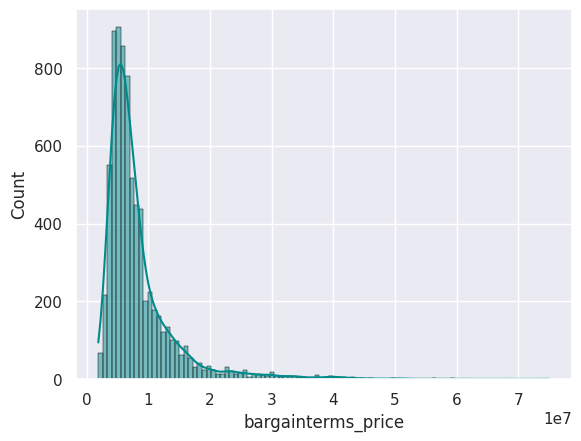

In [484]:
sns.histplot(df_model_sc['bargainterms_price'],
             kde=True,
             color='darkcyan',
             edgecolor='black',
             bins=100)
plt.show()

Разбиваем выборку на категории, исходя из цены объекта bargainterms_price  
Создаем новый столбец bargainterms_price_bins

In [865]:
# разбиваем на бины
# p_labels = ['до_3_млн','от_3_до_6_млн ', 'от_6_до_9_млн', 'от_9_до_12_млн', 'от_12_до_15_млн', 'от_15_до_20_млн', 'свыше_20_млн']  
# p_bins = [0, 3000000, 6000000, 9000000, 12000000, 15000000, 20000000, 900000000]
# df_model_sc['bargainterms_price_bins'] = pd.cut(df_model_sc['bargainterms_price'], bins = p_bins, labels = p_labels)

In [485]:
df_model_sc['bargainterms_price_bins'].value_counts()

от_3_до_6_млн      3085
от_6_до_9_млн      2358
от_9_до_12_млн      824
от_12_до_15_млн     461
свыше_20_млн        337
от_15_до_20_млн     327
до_3_млн            162
Name: bargainterms_price_bins, dtype: int64

In [486]:
df_model_sc.columns

Index(['cian_id', 'url', 'bargainterms_price', 'area_total', 'address',
       'floor', 'floors_count', 'wall_type', 'last_edited', 'repair_type',
       'bti_year_built', 'lat', 'lng', 'geo_region', 'geo_settlement',
       'geo_city', 'geo_street', 'geo_house_num', 'geo_microdistrict',
       'geo_city_district', 'description', 'days_after_edit', 'poly_okrug',
       'poly_district', 'bargainterms_price_ln', 'unit_price',
       'bargainterms_price_LN', 'unit_price_LN', 'nearest_metro',
       'distance_to_nearest_metro', 'lat_lng', 'distance_to_centre',
       'distance_to_centre_1', 'bargainterms_price_bins', 'is_elit',
       'housing_complex', 'floor_1', 'med_price', 'Районы_Kmeans',
       'year_release', 'subway_time', 'subway_name', 'subway_travel_type',
       'subway_time_1', 'area_total_1', 'Объем_рынка', 'IsolationForest',
       'OneClassSVM', 'LOF', 'COPOD', 'PCA', 'out_iqr', 'out_iqr_kv',
       'Manual_autoencoder', 'sum_out_ml', 'sum_out_iqr', 'pred_price', 'APE',
   

In [487]:
X_2 = df_model_sc[[
                    'area_total',
                    'floor_1', 
                    'floors_count',
                    'is_elit',
                    #'poly_okrug',
                    #'poly_district', 
                    'lat',
                    'lng',
                    'subway_time_1', 
                    'distance_to_centre_1', 
                    'repair_type',
                    'year_release',
                    'Объем_рынка',
                    'bargainterms_price_bins',
                    'pred_price'
                  ]]

In [488]:
metrics = []

pred = np.exp(model_cat.predict(X))
X_2['pred'] = pred
list_2 = ['до_3_млн','от_3_до_6_млн ', 'от_6_до_9_млн', 'от_9_до_12_млн', 'от_12_до_15_млн', 'от_15_до_20_млн', 'свыше_20_млн'] 
div = 10**12 # подбираем в ручную для расчета SS_res и SS_tot

for price in list_2:
    
    pred_1 = X_2[X_2['bargainterms_price_bins'] == price]['pred']
    Y = df_model_sc[df_model_sc['bargainterms_price_bins'] == price]['bargainterms_price_LN']
    
    MAE = round(mae(np.exp(Y), pred_1), 4)
    RMSE = round(sqrt(mse(np.exp(Y), pred_1)), 4)
    MAPE = round(mape(np.exp(Y), pred_1), 4)
    R2 = round(r2_score(np.exp(Y), pred_1), 4)
    
    Y_mean = np.mean(np.exp(Y))
    SS_res = np.sum((np.exp(Y) - pred_1) ** 2) / div # Вычисление SSres (сумма квадратов отклонений от прогноза). div - это делитель, необходимый для уменьшения квадратичной суммы
    SS_tot = np.sum((np.exp(Y) - Y_mean) ** 2) / div # Вычисление SStot (сумма квадратов отклонений от среднего значения). div - это делитель, необходимый для уменьшения квадратичной суммы

    iqr_MAE = np.percentile((np.exp(Y)-pred_1), 75) - np.percentile((np.exp(Y)-pred_1), 25)
    delta_iqr_MAE = round(iqr_MAE/MAE, 2)
    n_objects = len(pred_1)
    relMAE = round(MAE/np.median(np.exp(Y)), 4)
    relRMSE = round(RMSE/np.median(np.exp(Y)), 4)
    minim = np.min(np.exp(Y))
    maxim = np.max(np.exp(Y))
    mean_p = np.mean(np.exp(Y))
    median_p = np.median(np.exp(Y))

    metrics.append([price, MAE, RMSE, MAPE, R2, SS_res, SS_tot, iqr_MAE, delta_iqr_MAE, n_objects, relMAE, relRMSE, minim, maxim, mean_p, median_p])
    
table = pd.DataFrame(metrics, columns = ['bargainterms_price_bins', 'MAE', 'RMSE', 'MAPE', 'R2', 'SS_res', 'SS_tot', 'iqr_MAE', 'delta_iqr_MAE', 'n_objects', 
                                         'relMAE', 'relRMSE', 'minim', 'maxim', 'mean_p', 'median_p']).sort_values('R2', ascending = False)
table[:30]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


bargainterms_price_bins            MAE           RMSE     MAPE        R2  \
6            свыше_20_млн 1525590.755700 2364338.360200 0.048700  0.934800   
1          от_3_до_6_млн   300175.456800  391333.796200 0.062800  0.755900   
2           от_6_до_9_млн  495821.423900  655847.799700 0.067300  0.402300   
0                до_3_млн  223509.191200  284481.904800 0.084100 -0.300700   
3          от_9_до_12_млн  810067.365800 1046825.237500 0.077300 -0.457300   
5         от_15_до_20_млн 1454484.344700 1908176.379500 0.085400 -0.853900   
4         от_12_до_15_млн 1101521.883300 1471105.265400 0.081500 -2.112900   

       SS_res       SS_tot        iqr_MAE  delta_iqr_MAE  n_objects   relMAE  \
6 1883.862312 28872.845628 1896178.808500       1.240000        337 0.056500   
1  472.443502  1935.399052  460730.324244       1.530000       3085 0.062500   
2 1014.261481  1697.013981  784987.439423       1.580000       2358 0.068300   
0   13.110653    10.079999  325962.184879       1.460000        162 0.082800   
3  902.974696   619.607478 1278797.001038       1.580000        824 0.077200   
5 1190.651830   642.226349 2166158.997790       1.490000        327 0.086600   
4  997.673474   320.498279 1708508.179580       1.550000        461 0.081700   

   relRMSE           minim           maxim          mean_p        median_p  
6 0.087600 20100000.000000 75000000.000000 29977305.747774 27000000.000000  
1 0.081500  3050000.000000  6000000.000000  4781363.524473  4800000.000000  
2 0.090300  6050000.000000  9000000.000000  7352972.731128  7262500.000000  
0 0.105400  1900000.000000  3000000.000000  2694160.870370  2700000.000000  
3 0.099800  9050000.000000 12000000.000000 10452136.978155 10490000.000000  
5 0.113600 15093620.000000 20000000.000000 17069599.688073 16800000.000000  
4 0.109100 12051600.000000 15000000.000000 13487013.065076 13490000.000000

В таблице выше R2 указывает на плохое качество модели при разбивке данных на ценовые интервалы. При этом, стоит обратить внимание, что такие метрики как MAE, RMSE и MAPE остаются в адекватных пределах. Такое явление с R2 может быть связано с тем, что в каждом ценовом интервале диапазон цен (вариация Y) сильно сужается. Модель обучалась на более широком диапазоне цен, и ее ошибки в узком интервале могут быть сопоставимы или даже больше вариации Y в этом интервале. Это приводит к большой SS_res относительно SS_tot, и R2 становится отрицательным. Негативные значения R2 не обязательно указывают на плохую модель, они скорее отражают ограниченность разбиения на интервалы и особенности распределения цен. Если в целом метрики по всей выборке и в других разрезах (например, по районам или площадям) адекватны, модель нельзя считать плохой только из-за отрицательных значений R2 в отдельных интервалах цен. Если метрики MAE, RMSE и MAPE остаются стабильными, это говорит о том, что ошибки модели не аномальны. R2 менее полезен в случае сильно ограниченных подмножеств данных (например, узкие интервалы цен), в таких случаях MAE, relMAE и MAPE более информативны.

***Выведем графики по бинам:***

In [489]:
df_model_sc['AE'] = df_model_sc['bargainterms_price'] - df_model_sc['pred_price']

In [490]:
df_model_sc['bargainterms_price_bins'].unique()

['от_12_до_15_млн', 'от_3_до_6_млн ', 'от_15_до_20_млн', 'свыше_20_млн', 'от_6_до_9_млн', 'от_9_до_12_млн', 'до_3_млн']
Categories (7, object): ['до_3_млн' < 'от_3_до_6_млн ' < 'от_6_до_9_млн' < 'от_9_до_12_млн' < 'от_12_до_15_млн' < 'от_15_до_20_млн' < 'свыше_20_млн']

Всего: 162
two_mae (> 447018.3824)_количество: 18
two_mae (> 447018.3824)_доля: 0.111




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<function matplotlib.pyplot.show(close=None, block=None)>

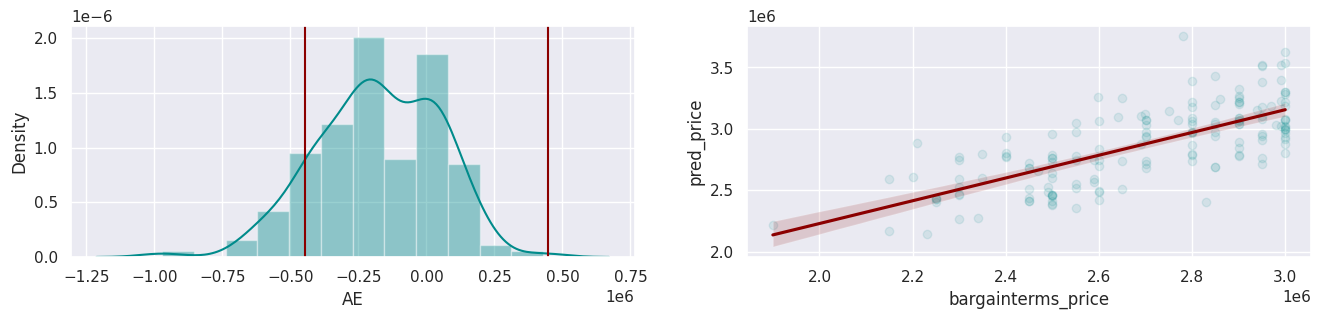

In [491]:
price_bin = 'до_3_млн'  # здесь меняем бины

df_price_bin = df_model_sc[df_model_sc['bargainterms_price_bins'] == price_bin]
two_mae = table[table['bargainterms_price_bins'] == price_bin]['MAE'].values[0] * 2

print('Всего:', len(df_price_bin['AE']))
print(f'two_mae (> {two_mae})_количество:', len(df_price_bin[(df_price_bin['AE'] < -two_mae) | (df_price_bin['AE'] > two_mae)]))
print(f'two_mae (> {two_mae})_доля:', round(len(df_price_bin[(df_price_bin['AE'] < -two_mae) | (df_price_bin['AE']  > two_mae)]) / len(df_price_bin['AE'] ), 3))

fig, ax = plt.subplots(1, 2, figsize = (16, 3))

sns.distplot(df_price_bin['AE'],
             color = 'darkcyan',
             ax = ax[0]
            )

sns.regplot(data = df_price_bin,
            x = 'bargainterms_price',
            y = 'pred_price',
            scatter_kws = {'alpha': 0.1},
            color = 'darkcyan',
            line_kws = {'color': 'darkred'},
            ax = ax[1]
            )

ax[0].axvline(-two_mae, color = 'darkred')
ax[0].axvline(two_mae, color = 'darkred')

plt.show

R2 сильно зависит от величины интервала и разнообразия цен внутри него. Если посмотреть на график выше, где мы рассматриваем интервал от 12 млн. до 15 млн., и на график ниже, где приведены все данные (рассматриваемый интервал выделен красными линиями), то наглядно увидим влияние чанка на R2. Становится очевидным, что если из общей массы (картины) взять чанк (фрагмент), то  R2 может значительно ухудшится. Таким образом, чем уже будет интервал, тем менее стабилен будет R2. В таких случаях MAE, relMAE и MAPE более информативны

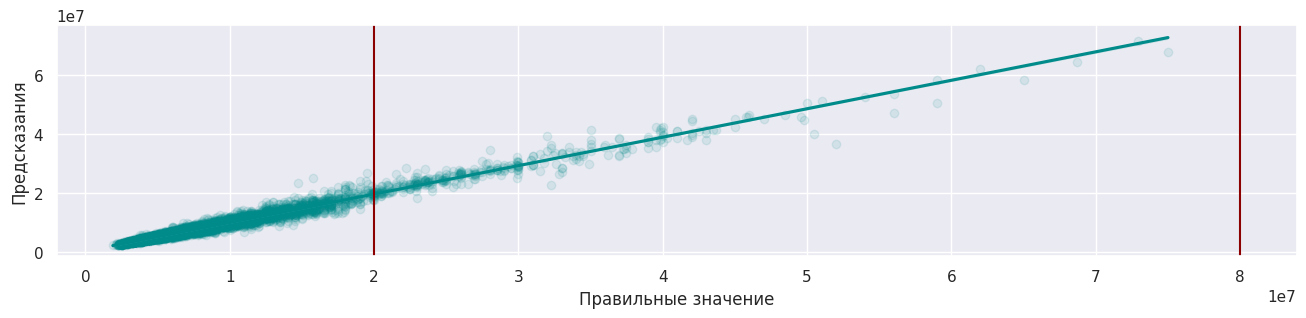

In [492]:
l_1 = 20000000
l_2 = 80000000

plt.figure(figsize = (16, 3))

sns.regplot(data = df_model_sc,
            x = 'bargainterms_price',
            y = 'pred_price',
            scatter_kws = {'alpha': 0.1},
            color = 'darkcyan'
            )

plt.axvline(l_1, color = 'darkred')
plt.axvline(l_2, color = 'darkred')

plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

#### 13.5 График по МАЕ (вся выборка)

In [493]:
g = 2000000 # граница для MAE - примерно 2 * МАЕ

In [494]:
df_model_sc['abs_AE'] = abs(df_model_sc['AE'])

In [495]:
print('Всего:', len(df_model_sc['AE']))
print(f'MAE ({str(g)[0] + "." + str(g)[1]} млн)_количество:', len(df_model_sc[(df_model_sc['AE'] < -g) | (df_model_sc['AE'] > g)]))
print(f'MAE ({str(g)[0] + "." + str(g)[1]} млн)_доля:', round(len(df_model_sc[(df_model_sc['AE'] < -g) | (df_model_sc['AE']  > g)]) / len(df_model_sc['AE'] ), 3))

Всего: 7554
MAE (2.0 млн)_количество: 302
MAE (2.0 млн)_доля: 0.04




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



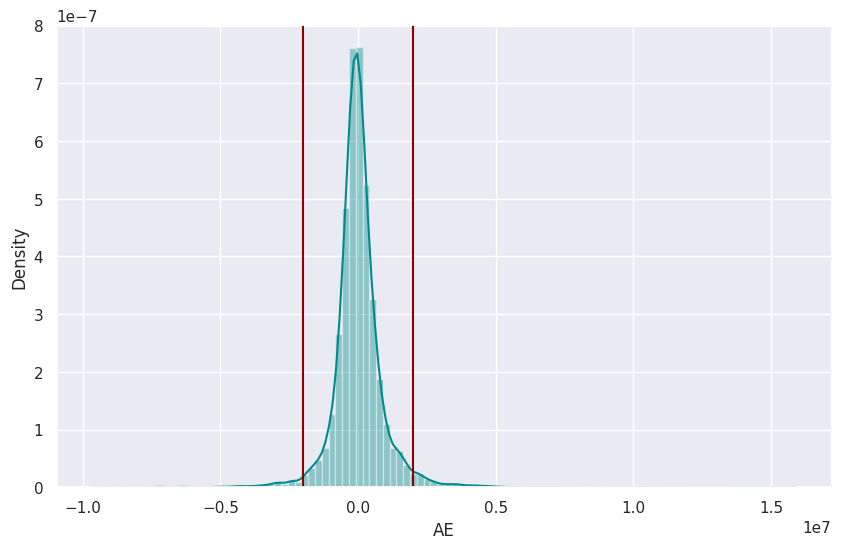

In [496]:
sns.set()
plt.figure(figsize = (10, 6))
sns.distplot(df_model_sc['AE'],
             color = 'darkcyan',
             bins = 100
            )

plt.axvline(-g, color = 'darkred')
plt.axvline(g, color = 'darkred')
plt.show()

In [ ]:
df_model_sc[df_model_sc['AE'] > 7000000]

632 - квартира с улучшенным ремонтом, в продаже с марта 2024, цена постепенно снижается (401 т.р./кв.м), седняя квартира с аналогичным ремонтом стоит дешевле (369 т.р./кв.м).  
1736 - видовая квартира, отделка улучшенная-стандарт, в продаже с лета 2024. Соседняя квартира с ремонтом стандарт продается за 42 млн.  
2515 - цена 283 т.р./кв.м, снято с продажи, соседняя аналогичная по площади квартира с ценой 241 т.р./кв.м, цена снижается.  
2848 - квартира с улучшенной отделкой и террасой, в продаже с сентября 2024. Относительно других квартир в этом доме цена завышена. Наша цена с террасой составит 53 млн. руб.  
5792 - ремонт не является улучшенным, в продаже с декабря 2024, есть аналогичные квартиры с ценой ниже.  
6595 - это квартира в доме, который не сдан, дом элитный.  

In [ ]:
ind = 2070

df_model_sc.loc[ind:ind]

#### 13.6 График по MAPE (вся выборка)

In [503]:
g = 0.2 # граница для MAPE - примерно 2 * relMAE

In [504]:
print('Всего:', len(df_model_sc['APE']))
print(f'MAPE {g}_количество:', len(df_model_sc[(df_model_sc['APE'] < -g) | (df_model_sc['APE'] > g)]))
print(f'MAPE {g}_доля:', round(len(df_model_sc[(df_model_sc['APE'] < -g) | (df_model_sc['APE'] > g)]) / len(df_model_sc['APE']), 3))

Всего: 7554
MAPE 0.2_количество: 239
MAPE 0.2_доля: 0.032




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



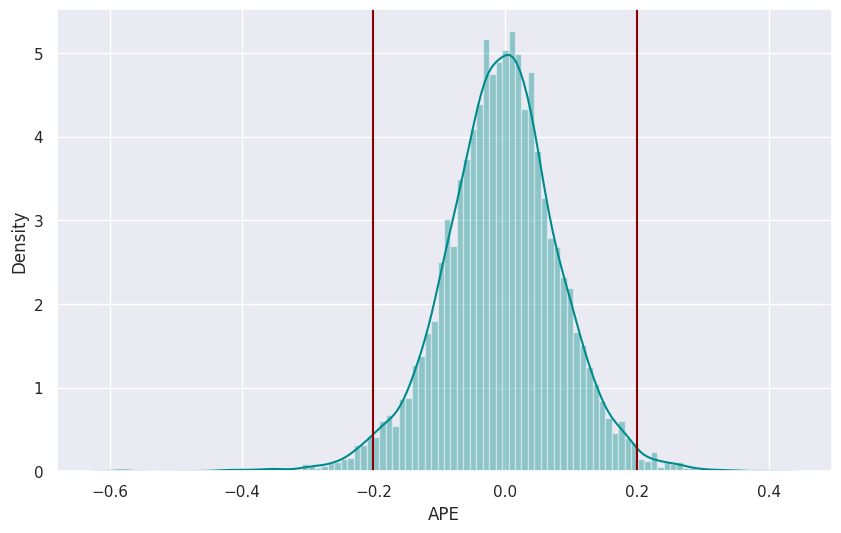

In [505]:
sns.set()
plt.figure(figsize = (10, 6))
sns.distplot(df_model_sc['APE'],
             color = 'darkcyan',
             bins = 100
            )

plt.axvline(-g, color = 'darkred')
plt.axvline(g, color = 'darkred')

#### 13.7 Regplot (вся выборка)

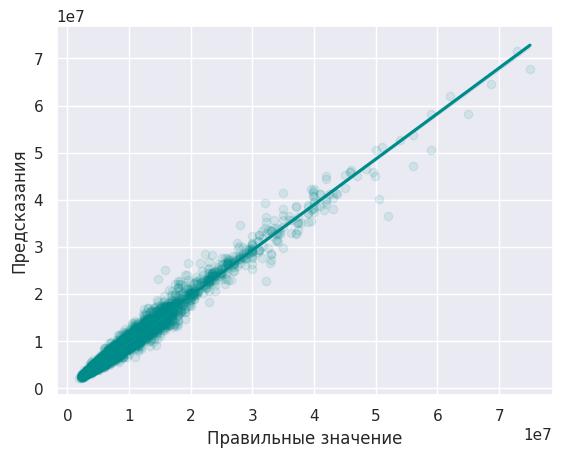

In [506]:
sns.regplot(data = df_model_sc,
            x = 'bargainterms_price',
            y = 'pred_price',
            scatter_kws = {'alpha': 0.1},
            color = 'darkcyan'
            )
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

Наклон прямой вправо относительно диагонали говорит о том, что модель немного недооценивает квартиры.

In [507]:
len(df_model_sc)

7554

#### 13.8 График зависимости остатков от прогноза (вся выборка)

In [508]:
# находим остатки
df_model_sc['residuals'] = df_model_sc['bargainterms_price'] - df_model_sc['pred_price']

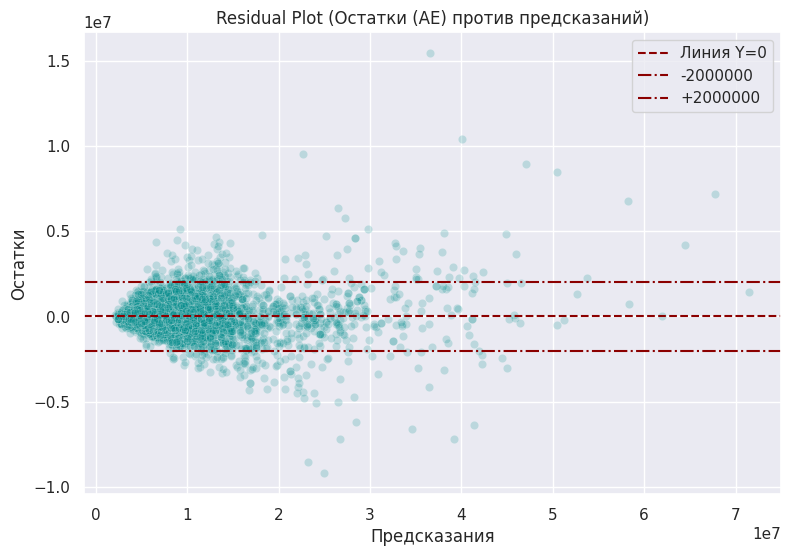

In [509]:
g = 2000000

plt.figure(figsize = (9, 6))
sns.scatterplot(data = df_model_sc,
                x = 'pred_price', 
                y = 'residuals',
                alpha = 0.2,
                color = 'darkcyan'
               )
plt.axhline(0, color = 'darkred', linestyle = '--', label = 'Линия Y=0')

plt.axhline(-g, color = 'darkred', linestyle = '-.', label = f'-{g}')
plt.axhline(g, color = 'darkred', linestyle = '-.', label = f'+{g}')

plt.title('Residual Plot (Остатки (AE) против предсказаний)')
plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.legend()

In [510]:
g = 2000000

print('Переоценивает:', len(df_model_sc[df_model_sc['residuals'] < -g]))
print('Не дооценивает:', len(df_model_sc[df_model_sc['residuals'] > g]))

Переоценивает: 117
Не дооценивает: 185


In [511]:
# находим остатки
df_model_sc['residuals_ape'] = (df_model_sc['bargainterms_price'] - df_model_sc['pred_price']) / df_model_sc['bargainterms_price']

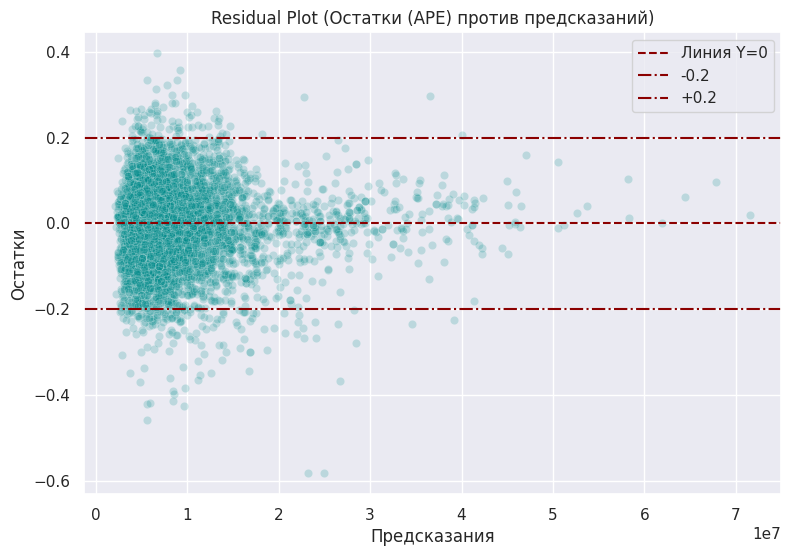

In [512]:
g = 0.2

plt.figure(figsize = (9, 6))
sns.scatterplot(data = df_model_sc,
                x = 'pred_price', 
                y = 'residuals_ape',
                alpha = 0.2,
                color = 'darkcyan'
               )
plt.axhline(0, color = 'darkred', linestyle = '--', label = 'Линия Y=0')

plt.axhline(-g, color = 'darkred', linestyle = '-.', label = f'-{g}')
plt.axhline(g, color = 'darkred', linestyle = '-.', label = f'+{g}')

plt.title('Residual Plot (Остатки (APE) против предсказаний)')
plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.legend()

In [513]:
g = 0.2

print('Переоценивает:', len(df_model_sc[df_model_sc['residuals_ape'] < -g]))
print('Не дооценивает:', len(df_model_sc[df_model_sc['residuals_ape'] > g]))

Переоценивает: 158
Не дооценивает: 81


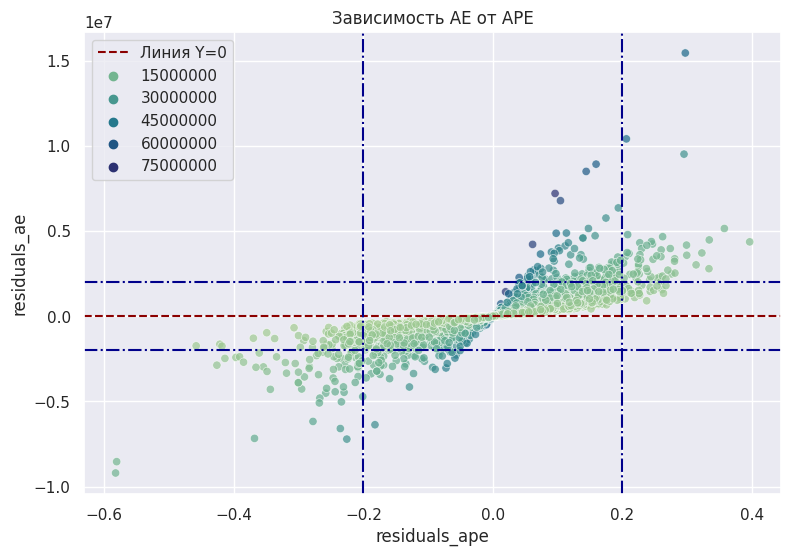

In [514]:
plt.figure(figsize = (9, 6))
sns.scatterplot(data = df_model_sc,
                x = 'residuals_ape', 
                y = 'residuals',
                hue = 'bargainterms_price',
                alpha = 0.7,
                palette = 'crest'
               )
plt.axhline(0, color = 'darkred', linestyle = '--', label = 'Линия Y=0')

plt.axhline(-2000000, color = 'darkblue', linestyle = '-.')
plt.axhline(2000000, color = 'darkblue', linestyle = '-.')

plt.axvline(-0.2, color = 'darkblue', linestyle = '-.')
plt.axvline(0.2, color = 'darkblue', linestyle = '-.')

plt.title('Зависимость AE от APE')
plt.xlabel('residuals_ape')
plt.ylabel('residuals_ae')
plt.legend()

Наилучший прогноз находится в пределах плюс/минус 0.2 по residuals_ape. residuals_ape - это доля residuals_ae в фактической цене объекта. Чтобы получить фактическую цену квартиры, необходимо воспользоваться формулой ниже: 

<font color='darkred'> **Цена_факт = residuals_ae / residuals_ape** </font> 

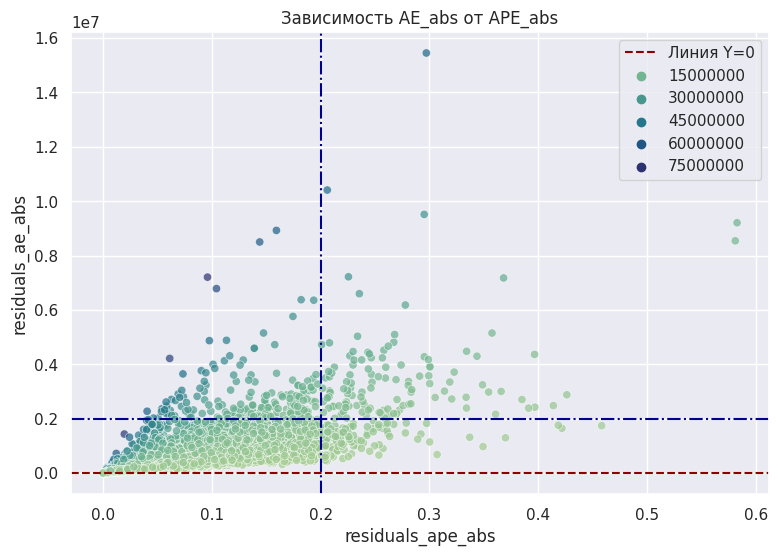

In [515]:
df_model_sc['residuals_ape_abs'] = abs(df_model_sc['residuals_ape'])
df_model_sc['residuals_ae_abs'] = abs(df_model_sc['residuals'])

plt.figure(figsize = (9, 6))
sns.scatterplot(data = df_model_sc,
                x = 'residuals_ape_abs', 
                y = 'residuals_ae_abs',
                hue = 'bargainterms_price',
                alpha = 0.7,
                palette = 'crest'
               )
plt.axhline(0, color = 'darkred', linestyle = '--', label = 'Линия Y=0')

plt.axhline(2000000, color = 'darkblue', linestyle = '-.')
plt.axvline(0.2, color = 'darkblue', linestyle = '-.')

plt.title('Зависимость AE_abs от APE_abs')
plt.xlabel('residuals_ape_abs')
plt.ylabel('residuals_ae_abs')
plt.legend()

In [516]:
quarter_1 = df_model_sc[(df_model_sc['residuals_ae_abs'] > 2000000) & (df_model_sc['residuals_ape_abs'] > 0.2)]
quarter_2 = df_model_sc[(df_model_sc['residuals_ae_abs'] > 2000000) & (df_model_sc['residuals_ape_abs'] < 0.2)]
quarter_3 = df_model_sc[(df_model_sc['residuals_ae_abs'] <= 2000000) & (df_model_sc['residuals_ape_abs'] <= 0.2)]
quarter_4 = df_model_sc[(df_model_sc['residuals_ae_abs'] < 2000000) & (df_model_sc['residuals_ape_abs'] > 0.2)]

print(f'Объем quarter_1: {len(quarter_1)}, доля: {round(len(quarter_1) / len(df_model_sc), 3)}')
print(f'Объем quarter_2: {len(quarter_2)}, доля: {round(len(quarter_2) / len(df_model_sc), 3)}')
print(f'Объем quarter_3: {len(quarter_3)}, доля: {round(len(quarter_3) / len(df_model_sc), 3)}')
print(f'Объем quarter_4: {len(quarter_4)}, доля: {round(len(quarter_4) / len(df_model_sc), 3)}')
print('---------------------------------')
print('Сумма quarter_1-4:', len(quarter_1)+len(quarter_2)+len(quarter_3)+len(quarter_4))
print('Общий объем:', len(df_model_sc))

Объем quarter_1: 123, доля: 0.016
Объем quarter_2: 179, доля: 0.024
Объем quarter_3: 7136, доля: 0.945
Объем quarter_4: 116, доля: 0.015
---------------------------------
Сумма quarter_1-4: 7554
Общий объем: 7554


На графике выше синими пунктирными с точкой линиями проведены границы по MAE (порог 2 млн. руб.) и MAPE (порог 20%). Эти линии делят весь график на 4 четверти:  
В 1 четверти находятся объекты с MAE > 2 млн. руб. и MAPE > 20% (MAE большой и его доля в фактической цене высокая).  
Во 2 четверти находятся объекты с MAE > 2 млн. руб. и MAPE < 20%.  
В 3 четверти находятся объекты с MAE < 2 млн. руб. и MAPE < 20%.  
В 4 четверти находятся объекты с MAE < 2 млн. руб. и MAPE > 20% (MAE маленький, при этом его доля в фактической цене высокая).  

#### 13.9 Определение интервала

In [517]:
# Используем линейную регрессию для прогнозирования стандартного отклонения по цене
X1 = np.log(df_model_sc['pred_price'])
Y1 = np.log(np.abs(df_model_sc['residuals']))  # Моделируем абсолютные ошибки, берем log для исключения отрицательных значений при прогнозе

#regressor = LinearRegression()
#regressor.fit(X, y)

X_ols = sm.add_constant(X1) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model_resid = sm.OLS(Y1, X_ols)
results_resid = model_resid.fit()

print(results_resid.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     1594.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):          1.64e-316
Time:                        15:31:18   Log-Likelihood:                -11706.
No. Observations:                7554   AIC:                         2.342e+04
Df Residuals:                    7552   BIC:                         2.343e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4822      0.404     -8.622      0.0

In [518]:
df_model_sc['residuals_pred'] = results_resid.predict(X_ols)

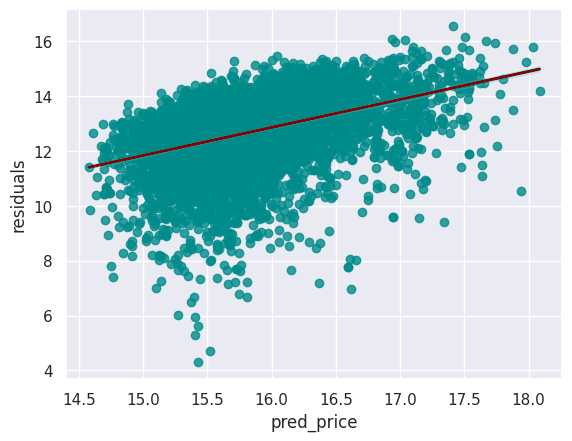

In [519]:
sns.regplot(x = np.log(df_model_sc['pred_price']), 
            y = np.log(np.abs(df_model_sc['residuals'])),
            color = 'darkcyan'
           )
plt.plot(np.log(df_model_sc['pred_price']), 
         df_model_sc['residuals_pred'],
         color = 'darkred'
        )

In [520]:
coefficients = results_resid.params
print("Intercept:", coefficients['const'])
print("Slope:", coefficients['pred_price'])

Intercept: -3.4821846814237016
Slope: 1.0214607168966294


***Формула расчета интервала предсказанной цены выглядит следующим образом:***  
<font color='darkred'> **Resid = np.exp(-3,4822 + 1,0215 * pred_price )  
pred_price - Resid * k &lt;= pred_price &lt;= pred_price + Resid * k** </font> 


***Подбор множителя k:***

In [529]:
# Абсолютные ошибки (остатки)
absolute_errors = np.abs(df_model_sc['residuals'])  # Возьмем модуль остатков

# Рассчитаем стандартное отклонение остатков
std_error = np.std(absolute_errors)

# Рассчитаем множитель k для покрытия 90% остатков
alpha = 0.1 # Для доверительного интервала 90%
k = np.percentile(absolute_errors / std_error, 100 * (1 - alpha / 2))  # Нормируем на стандартное отклонение

print(f"Множитель k: {k}")

Множитель k: 2.4812116816798353


***Расчет интервала для pred_price***

In [530]:
p = 17.6
k = 2.48

Y_1 = [1, p]

print('Цена квартиры:', np.exp(p))

pr = np.exp(results_resid.predict(Y_1)) * k

print('Интервал:', pr[0])
print('Интервал (доля):',pr[0] / np.exp(p))

Цена квартиры: 44013193.53483411
Интервал: 4895282.264543866
Интервал (доля): 0.11122306452653814


# <font color='008B8B'> 14. SHAP 🦄 </font>

In [916]:
shap.initjs()

**Загружаем модель, df_model, выбираем факторы, по которым строили модель**

In [531]:
model_cat = pickle.load(open('catmodel_nn_2025_reg.pkl', 'rb'))  # модель без выбросов

In [ ]:
df_model_sc.head()  # df с отфильтрованными выбросами 

In [533]:
# факторы модели CatBoost
X = df_model_sc[[                                       
                'area_total',
                'floor_1', 
                'floors_count',
                'is_elit',
                #'poly_okrug',
                #'poly_district', 
                'lat',
                'lng',
                'subway_time_1', 
                'distance_to_centre_1', 
                'repair_type',
                'year_release',
                'Объем_рынка'
              ]]

**Находим SHAP-значения**

In [534]:
explainer = shap.TreeExplainer(model_cat)
exp = explainer(X)
shap_values = explainer.shap_values(X)

#### 14.1 SHAP Summary Plot

С помощью summary_plot можно посмотреть на все факторы сразу и их степень влияния на таргет. 
- Каждая точка на графике - это отдельное наблюдение,   
- Цветом обозначаются значения соответствующего признака: высокие значения - красным цветом, низкие - синим цветом,  
- Признаки расположены по оси y по мере убывания их важности,
- по оси х находятся значения Шепли, которые либо положительно, либо отрицательно влияют на стоимость. 

По данному графику видим, что наиболее важный признак - это area_total. Чем он больше, тем выше будет цена. 

Минусом является то, что график не дает в полной мере оценить значения для категориальных признаков (из графика мы не видим, какие значения и как влияют на стоимость) -  
значения для категориальных признаков на графике подкрашены серым цветом. 

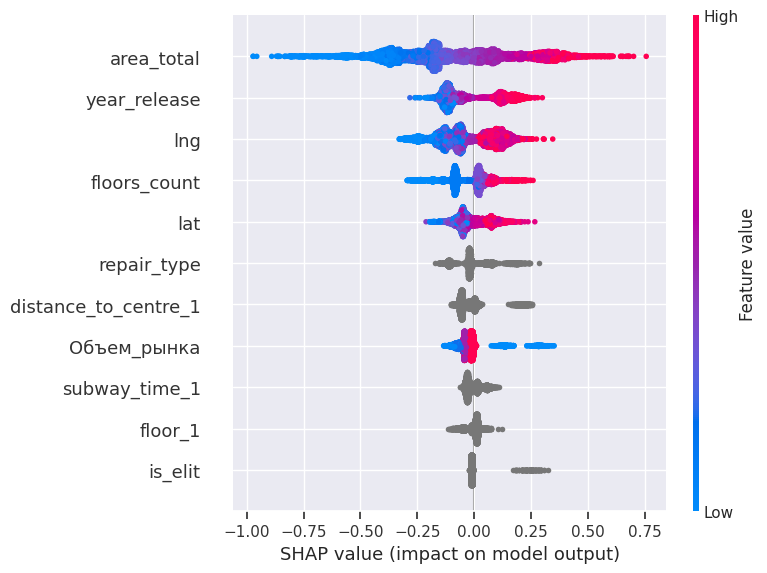

In [535]:
shap.summary_plot(shap_values, X)  # то же самое - shap.plots.beeswarm(exp)

#### 14.2 SHAP Dependence Plot

Влияние конкретных значений **категориальных** и количественных признаков на решения, принимаемые моделью, можно увидеть, используя dependence_plot,  
который строится для каждого признака отдельно.  
По оси Х выводится значение признака, по оси Y  - значение SHAP для него  

Цветом показывается также значение по другому признаку (здесь выбирается автоматически, но можно настроить, указав параметр interaction_index)

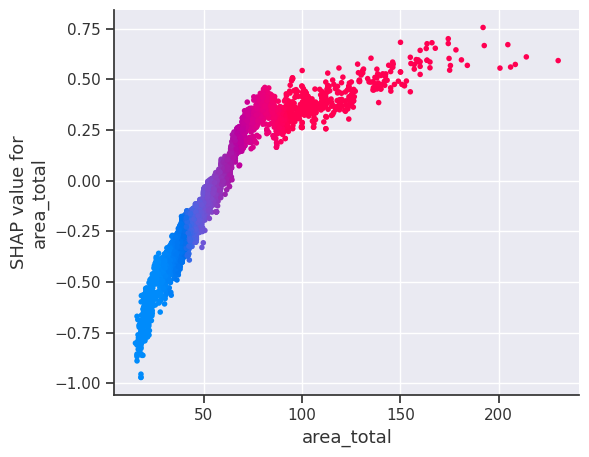

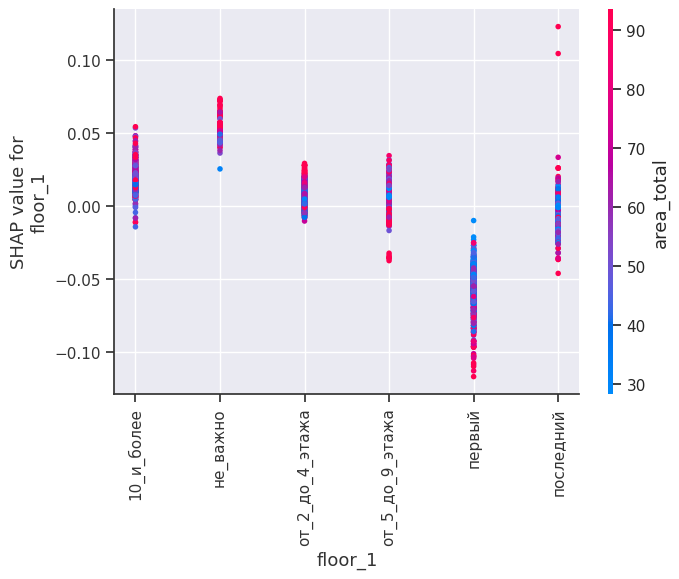

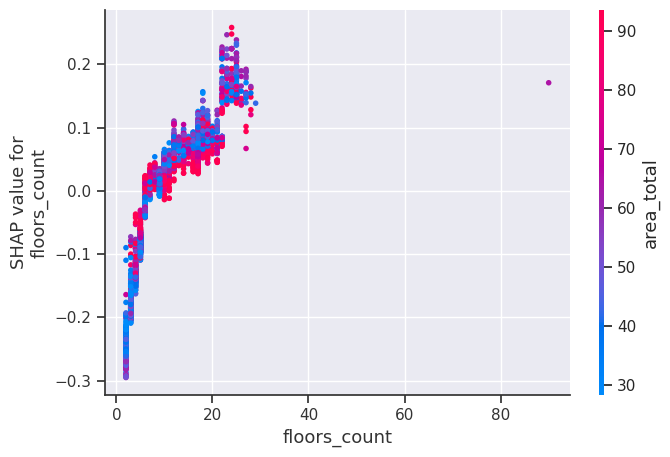

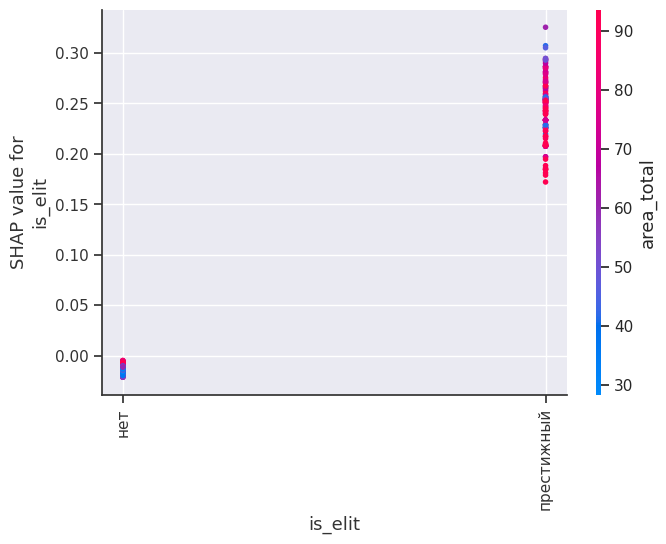

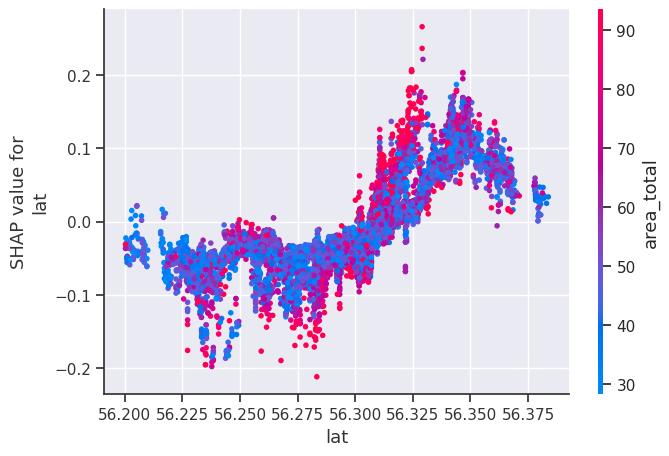

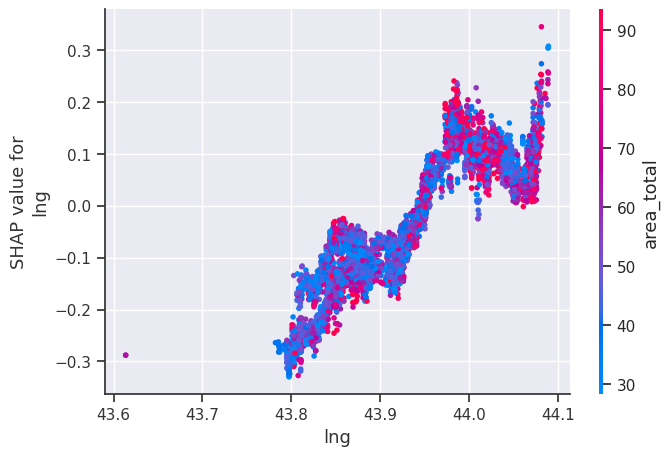

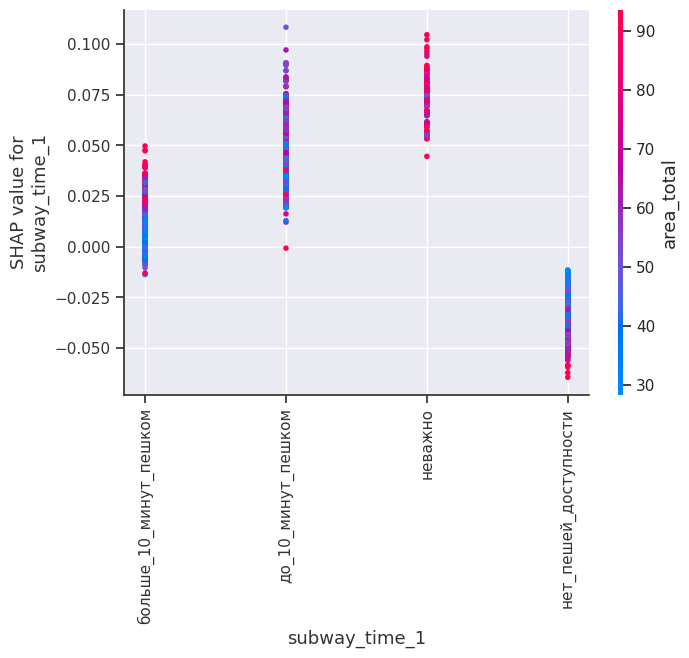

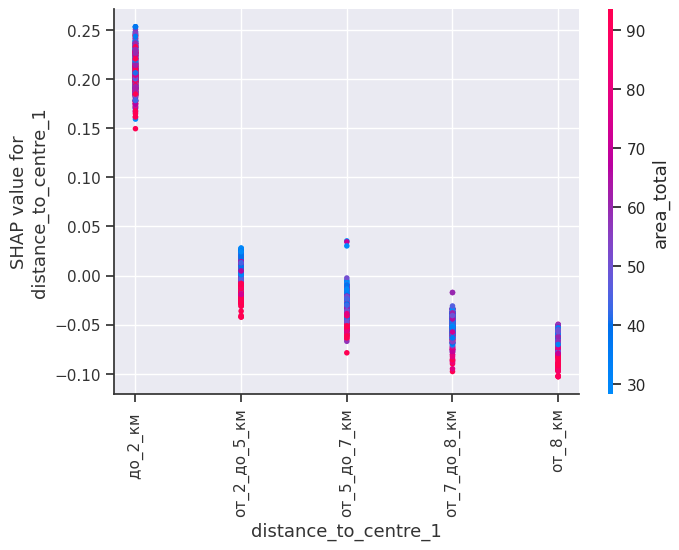

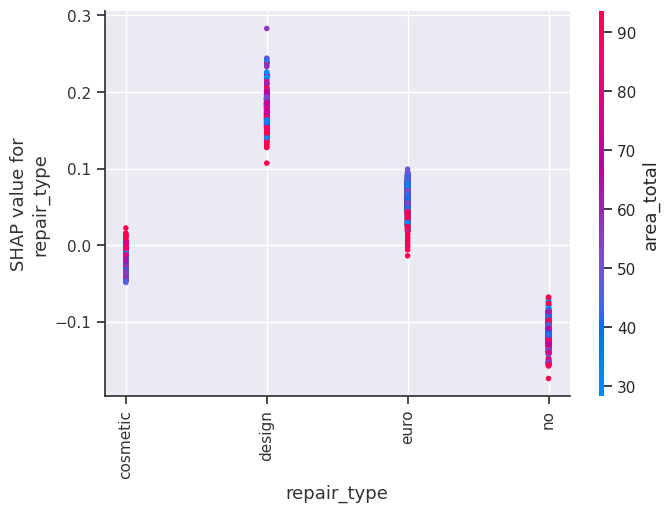

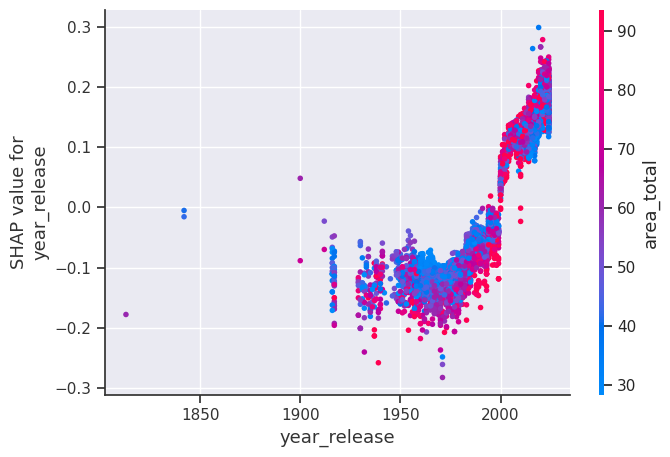

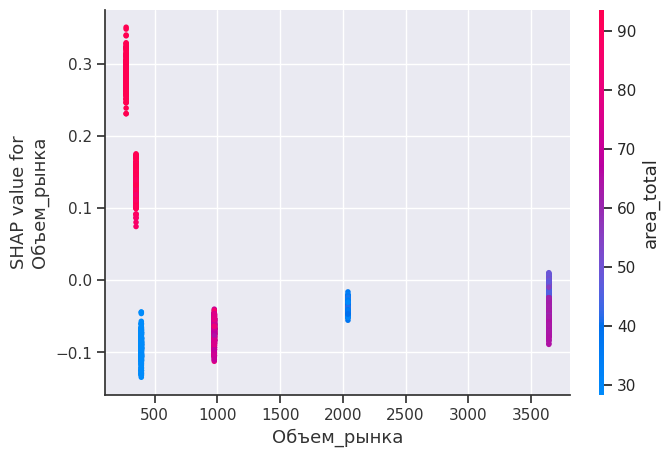

In [536]:
# строим графики сразу для всех признаков с помощью цикла
interaction_index = 'area_total'

for name in X.columns:
    shap.dependence_plot(name, 
                         shap_values, 
                         X,
                         interaction_index = interaction_index
                         ) 

#### 14.3 SHAP Waterfall plot

График позволяет визуализировть SHAP значения для конкретного объекта в наборе данных. 
С помощью цикла построим для первых 5 объектов.

- E&lbrack;f(x)&rbrack; = 16.003 - это ожидаемое прогнозируемое значение (среднее значение всех спрогнозированных значений)
- f(x) - это значение, спрогнозированное для конкретного объекта

По 1 объекту видим, что положительное влияние оказывают значения для признаков: площадь, расстояние до центра, объем рынка, округ, тип отделки, расстояние до метро, район,  
признак Казань/пригород.  
Отрицательное влияние - значения для признаков: год постройки, этаж, этажность, элитность. 

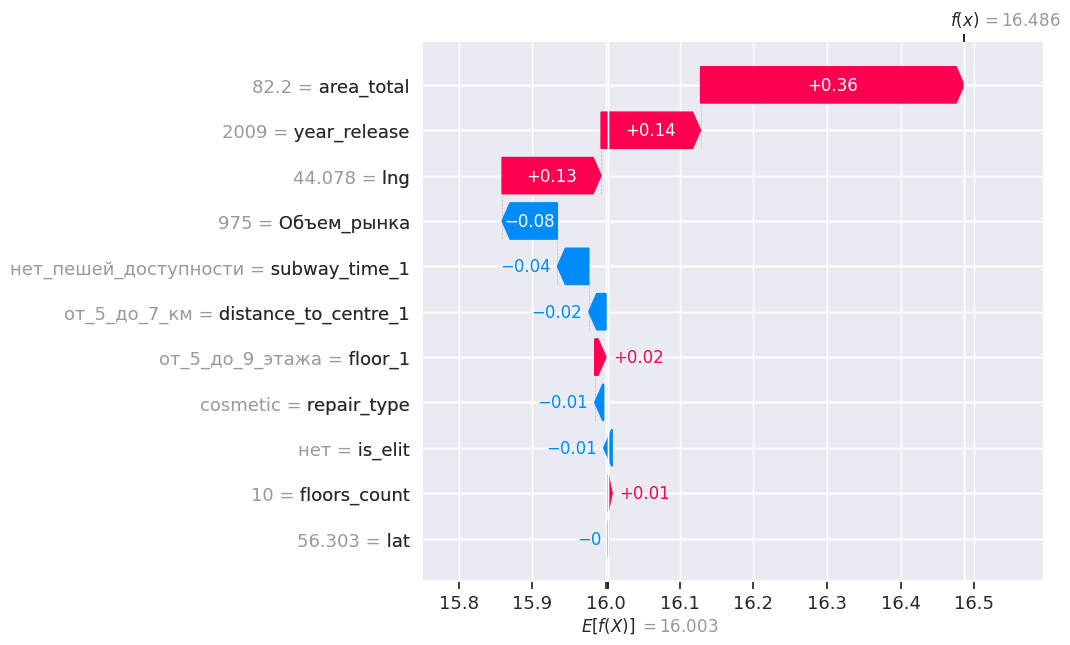

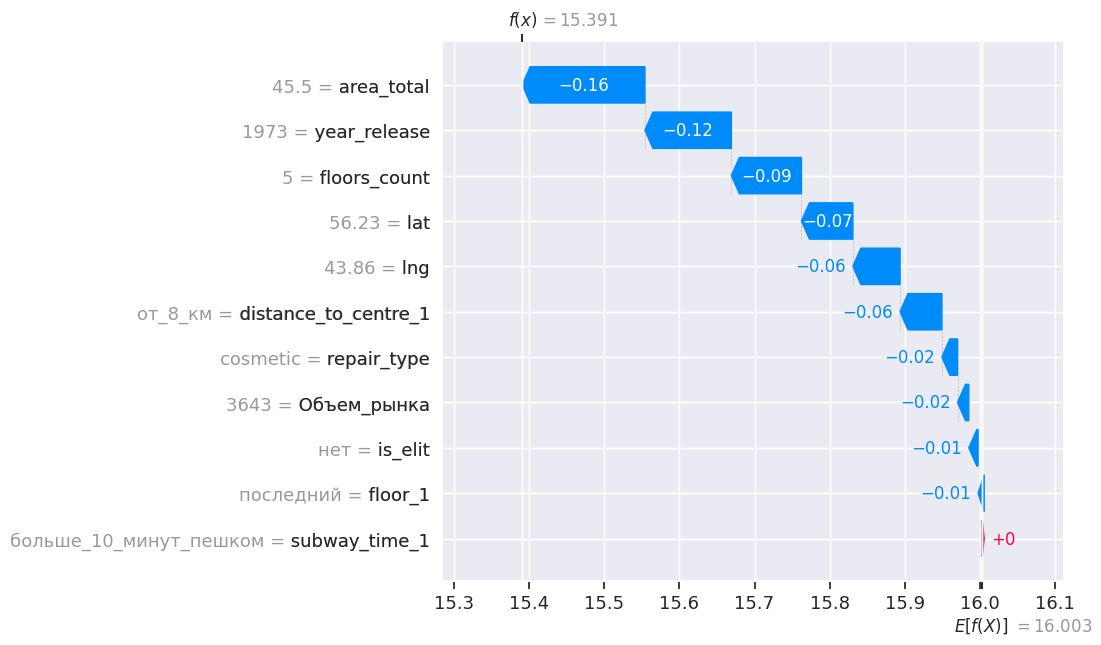

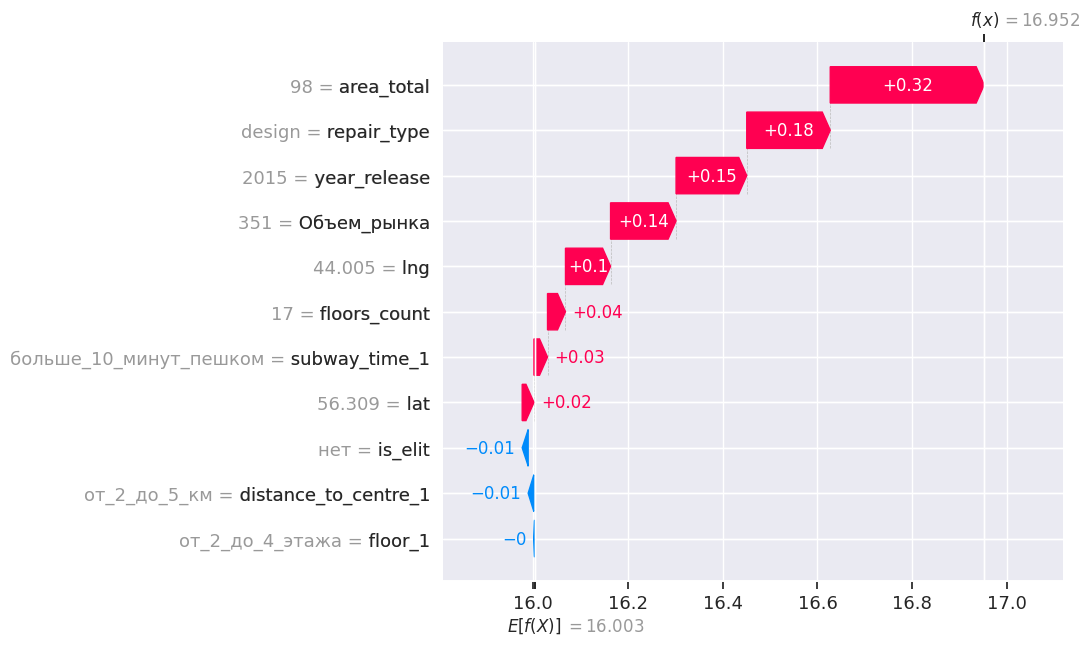

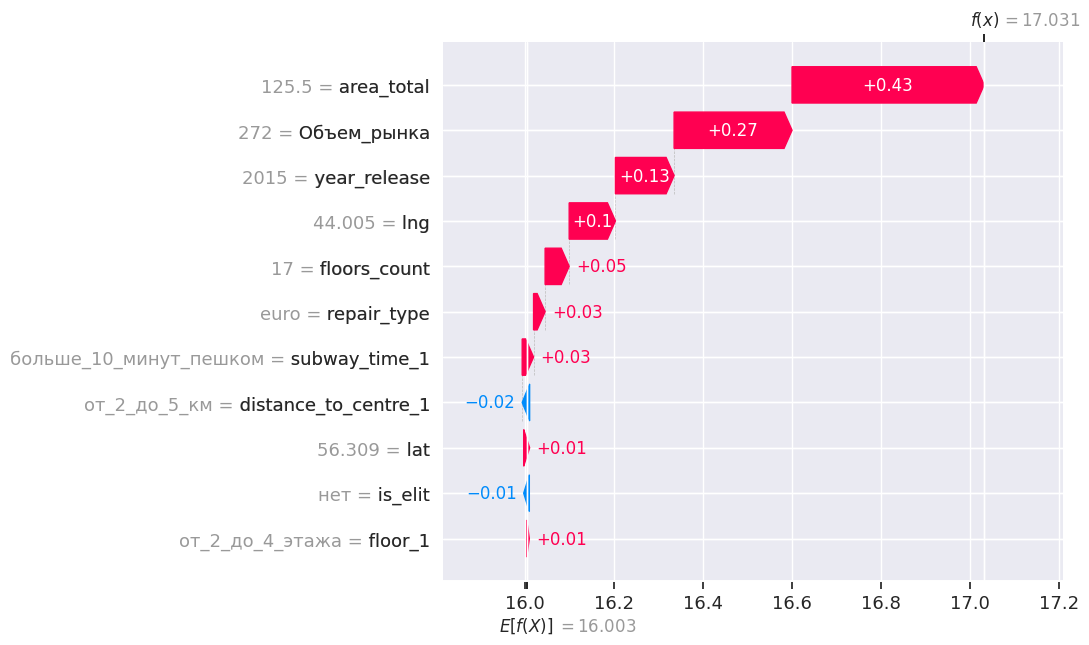

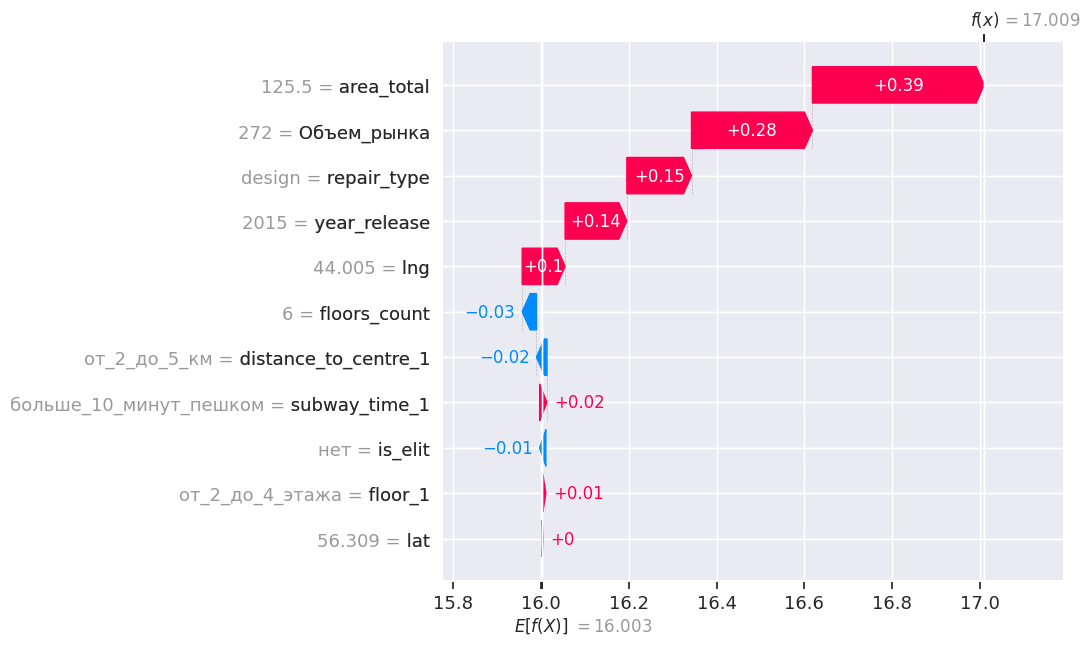

In [537]:
for num in range(5):
    shap.plots.waterfall(exp[num],
                         max_display = 15  # максимальное количество отображаемых параметров
                        )

Посмотрим самые переоцененные и недооцененные моделью объекты:

In [538]:
print(f'Максимальная переоценка: {df_model_sc["residuals"].min()}, \
      индекс: {df_model_sc["residuals"].idxmin()}, \
      прогноз: {round(df_model_sc["pred_price"].loc[df_model_sc["residuals"].idxmin()], 0)}, \
      url: {df_model_sc["url"].loc[df_model_sc["residuals"].idxmin()]}')

print(f'Максимальная недоценка: {df_model_sc["residuals"].max()}, \
      индекс: {df_model_sc["residuals"].idxmax()}, \
      прогноз: {round(df_model_sc["pred_price"].loc[df_model_sc["residuals"].idxmax()], 0)}, \
      url: {df_model_sc["url"].loc[df_model_sc["residuals"].idxmax()]}')

Максимальная переоценка: -9206102.583045185,       индекс: 4051,       прогноз: 25006103.0,       url: https://www.cian.ru/sale/flat/309069218
Максимальная недоценка: 15451265.921730228,       индекс: 5792,       прогноз: 36548734.0,       url: https://www.cian.ru/sale/flat/310694729


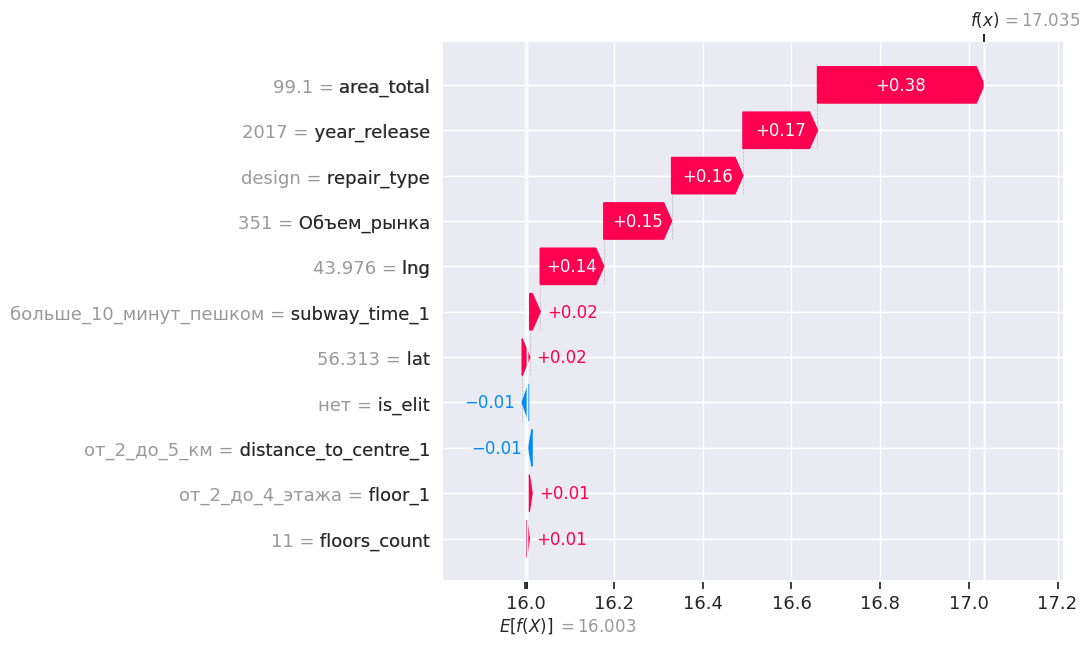

In [540]:
shap.plots.waterfall(exp[4051],
                     max_display = 15  # максимальное количество отображаемых параметров
                    )
# квартира с дизайнерской отделкой, в центре, ГП = 2017 с ценой 150 т.р./кв.м, цена низкая для центра, цена как у квартиры без отделки.

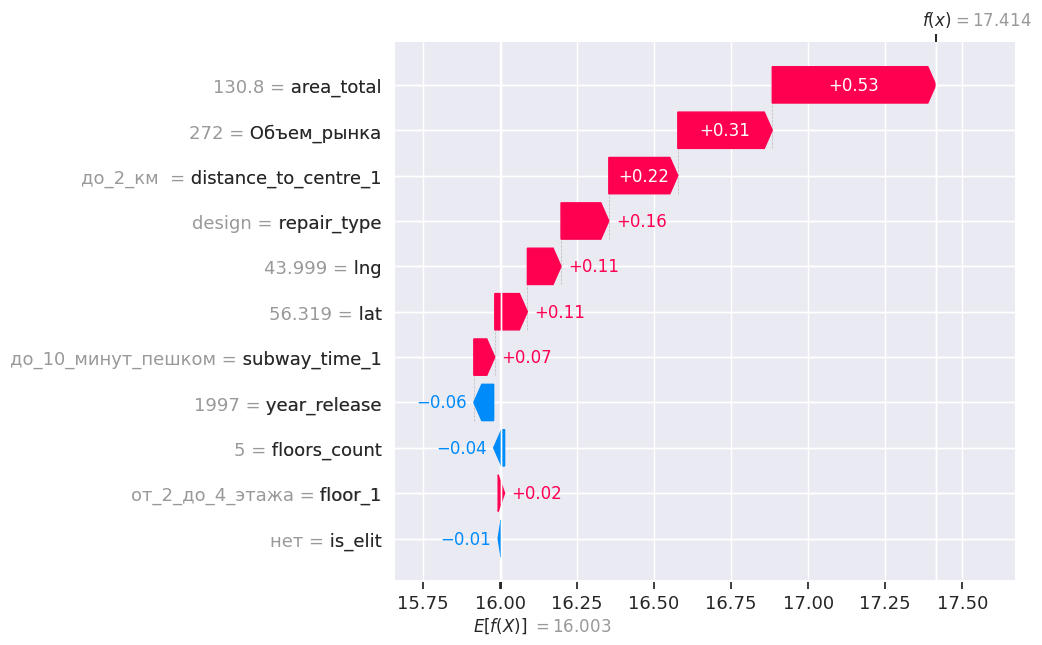

In [541]:
shap.plots.waterfall(exp[5792],
                     max_display = 15  # максимальное количество отображаемых параметров
                    )
# анализировал выше

Теперь посмотрим объект, относящийся к элитному сегменту, и оценим влияние SHAP значений для него:

In [ ]:
df_model_sc[df_model_sc.is_elit == 'престижный'].sample(2)

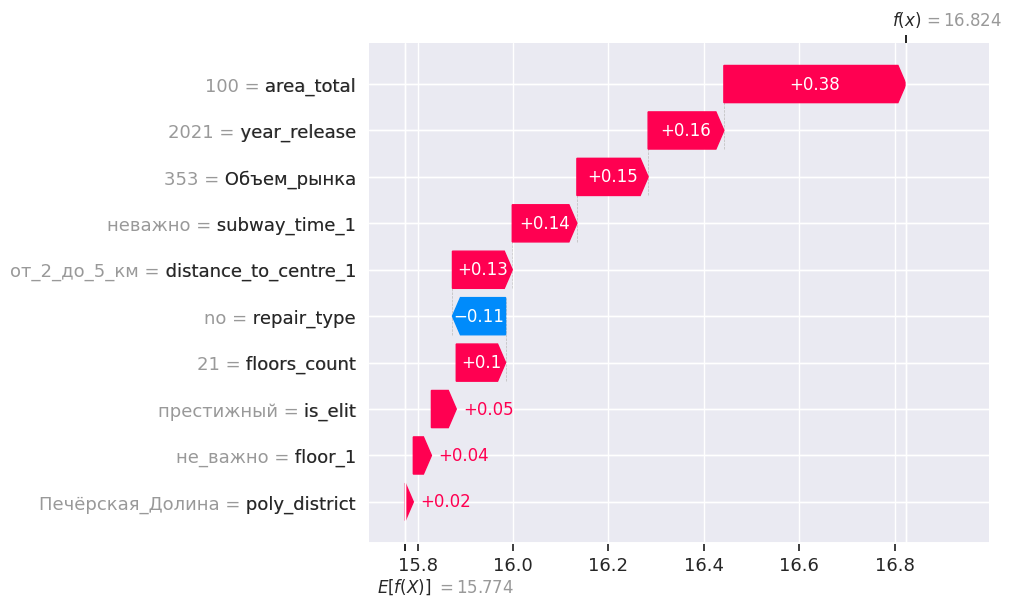

In [928]:
shap.plots.waterfall(exp[432],
                     max_display = 15  # максимальное количество отображаемых параметров
                    )

#### 14.4 Оцениваем средний вклад признаков в решения модели

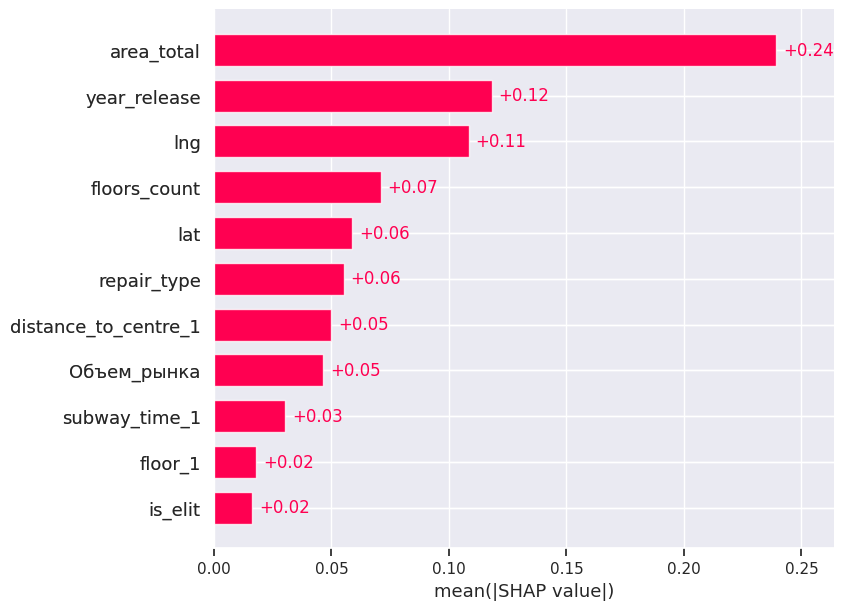

In [543]:
shap.plots.bar(exp,
               max_display = 15
              )

Из графика видим, что общая площадь area_total показывает самое высокое абсолютное значение SHAP, что отражает, что эта переменная наиболее важна в предсказании цены объекта. 